In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import impyute.imputation as imp
from statsmodels.tsa.stattools import adfuller
import statistics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

In [122]:
# Função para completar os dados faltantes
def completa_serie(dados,ano):
    print('-'*50)
    print('-'*24,ano,'-'*20)
    print('-'*50)
    
    # Reseta o index da série para ser por linha
    miss_dados = dados.isna().sum().sum()/(dados.shape[0]*dados.shape[1])*100
    print(f'{miss_dados.round(2)}% dos dados da bases são faltantes')
    
    # Completa os dados por Expect Maximization(EM)
    dados_filled = imp.cs.em(dados.values,loops=50)    
    d = [str(i) for i in range(1,25)]
    dados_completados = pd.DataFrame(data=dados_filled.round(0),columns=d)
    
    # Dados completados por EM
    print('*'*40,'  Base de dados completada  ','*'*40)
    display(dados_completados.head())

    # Formato da base dados
    print('*'*40,'  Formato da base dados  ','*'*40)
    display(dados_completados.shape)

    # Média diária dos dados
    print('*'*40,'Média diária dos dados','*'*40)
    dados_medios_completados = dados_completados.mean(axis='columns')
    display(dados_medios_completados)
    
    return dados_medios_completados

# Aplicar o Teste de Dickey-Fuller
def teste_estacionariedade(serie_temporal):
    
    #Teste estatístico
    print('Resultados do teste Dickey Fuller:')
    dftest = adfuller(serie_temporal.values)
    p_value = dftest[1]
    dfoutput = pd.Series(dftest[0:4], index=['Teste estatístico','p-value','#Lags Usados','Número de observações usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valores críticos (%s)'%key] = value
    print(dfoutput)
    return p_value

def MAPE(serie_suavizada,serie_original):
    return sum(abs((serie_suavizada-serie_original)*100)/serie_original)/serie_suavizada.shape[0]

def MQE(serie_suavizada,serie_original):
    return sum(pow(serie_suavizada-serie_original,2))/serie_suavizada.shape[0]

def MAE(serie_suavizada,serie_original):
    return sum(abs(serie_suavizada-serie_original))/serie_suavizada.shape[0]


def alisar_serie(serie_temporal_n_tratada,p_value,alpha=0.3):
    df_modelo_suavisado,df_suavisado = pd.DataFrame({}),pd.DataFrame({})
    vMAPE,vMAE,vMQE = [],[],[]
    
    if p_value < 0.05:
        janelas = [5,15,25,35,45,55,65,75]
        for janela in janelas:
            #Média movel para séries estácionária
            modelo_suavisado = serie_temporal_n_tratada.rolling(janela).mean()
            
            modelo_suavisado.reset_index(drop=True,inplace=True)
            modelo_suavisado.dropna(inplace=True)
            df_modelo_suavisado = df_modelo_suavisado.append(modelo_suavisado,ignore_index=True)
            
            vMAPE.append(MAPE(modelo_suavisado,serie_temporal_n_tratada[janela-1:]))
            vMAE.append(MAE(modelo_suavisado,serie_temporal_n_tratada[janela-1:]))
            vMQE.append(MQE(modelo_suavisado,serie_temporal_n_tratada[janela-1:]))
            
        moda = statistics.mode([vMAPE.index(min(vMAPE)),vMAE.index(min(vMAE)),vMQE.index(min(vMQE))])
        df_modelo_suavisado = df_modelo_suavisado.T
        df_suavisado = df_modelo_suavisado[moda].dropna()
        
    elif p_value > 0.05:
            modelo_suavisado = [serie_temporal_n_tratada[0]] # first value is same as series
            for n in range(1, len(serie_temporal_n_tratada)):
                modelo_suavisado.append(alpha * serie_temporal_n_tratada[n] + (1 - alpha) * modelo_suavisado[n-1])                
            df_suavisado = df_suavisado.append(modelo_suavisado,ignore_index=True)
            vMAPE.append(MAPE(df_suavisado,serie_temporal_n_tratada))
            vMAE.append(MAE(df_suavisado,serie_temporal_n_tratada))
            vMQE.append(MQE(df_suavisado,serie_temporal_n_tratada))

    
    print(f'MAPE:{min(vMAPE)}')
    print(f'MAE:{min(vMAE)}')
    print(f'MQE:{min(vMQE)}')
    #Plotar valores para verficar visualmente
    plt.figure(figsize=(40,5))
    st_plot = plt.plot(serie_temporal_n_tratada,'*-', color='red',label='Original')
    st_plot = plt.plot(df_suavisado,'*-', color='blue',label='Suavizado')
    plt.legend(loc='best')
    plt.show(block=False)
    
    return df_suavisado

# Etapa 1: Carregar os dados

In [123]:
dados2016 = pd.read_csv('..\/01.Dados\/CSV\/CO_P_Pedro_2016.csv')
dados2017 = pd.read_csv('..\/01.Dados\/CSV\/CO_P_Pedro_2017.csv')
dados2018 = pd.read_csv('..\/01.Dados\/CSV\/CO_P_Pedro_2018.csv')
dados2019 = pd.read_csv('..\/01.Dados\/CSV\/CO_P_Pedro_2019.csv')
dados2020 = pd.read_csv('..\/01.Dados\/CSV\/CO_P_Pedro_2020.csv')

# Etapa 2: Tratamento de dados faltantes

In [124]:
dados_medios_completados_2016 = completa_serie(dados2016,2016)
dados_medios_completados_2017 = completa_serie(dados2017,2017)
dados_medios_completados_2018 = completa_serie(dados2018,2018)
dados_medios_completados_2019 = completa_serie(dados2019,2019)
dados_medios_completados_2020 = completa_serie(dados2020,2020)

--------------------------------------------------
------------------------ 2016 --------------------
--------------------------------------------------
15.63% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1    2    3    4    5    6    7    8    9   10  ...   15   16   17   18  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    19   20   21   22   23   24  
0  0.0  0.0  0.0  0.0  1.0  1.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(213, 24)

**************************************** Média diária dos dados ****************************************


0      0.083333
1      0.083333
2      0.000000
3      0.000000
4      0.000000
         ...   
208    0.166667
209    0.000000
210    0.000000
211    0.208333
212    0.291667
Length: 213, dtype: float64

--------------------------------------------------
------------------------ 2017 --------------------
--------------------------------------------------
6.76% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1    2    3    4    5    6    7    8    9   10  ...   15   16   17   18  \
0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0   

    19   20   21   22   23   24  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(212, 24)

**************************************** Média diária dos dados ****************************************


0      0.083333
1      0.000000
2      0.000000
3      0.125000
4      0.041667
         ...   
207    0.375000
208    0.333333
209    0.208333
210    0.125000
211    0.625000
Length: 212, dtype: float64

--------------------------------------------------
------------------------ 2018 --------------------
--------------------------------------------------
2.4% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1    2    3    4    5    6    7    8    9   10  ...   15   16   17   18  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    19   20   21   22   23   24  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(212, 24)

**************************************** Média diária dos dados ****************************************


0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
207    0.750000
208    0.791667
209    0.583333
210    0.416667
211    0.041667
Length: 212, dtype: float64

--------------------------------------------------
------------------------ 2019 --------------------
--------------------------------------------------
9.0% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1    2    3    4    5    6    7    8    9   10  ...   15   16   17   18  \
0 -1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  1.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    19   20   21   22   23   24  
0  0.0  0.0 -0.0  1.0  0.0  1.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(212, 24)

**************************************** Média diária dos dados ****************************************


0      0.125000
1      0.083333
2      0.041667
3      0.083333
4      0.000000
         ...   
207    0.333333
208    0.000000
209    0.000000
210    0.208333
211    0.666667
Length: 212, dtype: float64

--------------------------------------------------
------------------------ 2020 --------------------
--------------------------------------------------
3.79% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1    2    3    4    5    6    7    8    9   10  ...   15   16   17   18  \
0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0 -0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    19   20   21   22   23   24  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(213, 24)

**************************************** Média diária dos dados ****************************************


0      0.208333
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
208    0.458333
209    0.583333
210    0.000000
211    0.000000
212    0.000000
Length: 213, dtype: float64

# Etapa 3: Decompondo cada série

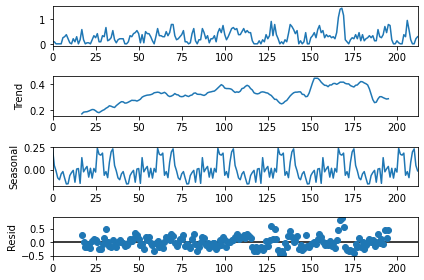

In [125]:
resultado_2016 = seasonal_decompose(dados_medios_completados_2016,period=35)
resultado_2016.plot();

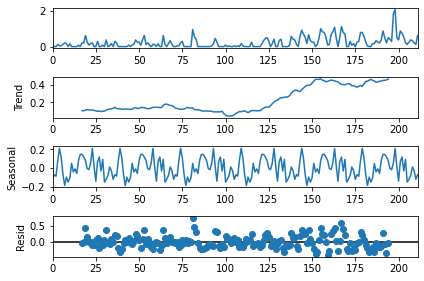

In [126]:
resultado_2017 = seasonal_decompose(dados_medios_completados_2017,period=35)
resultado_2017.plot();

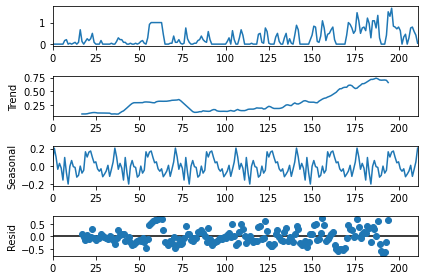

In [127]:
resultado_2018 = seasonal_decompose(dados_medios_completados_2018,period=35)
resultado_2018.plot();

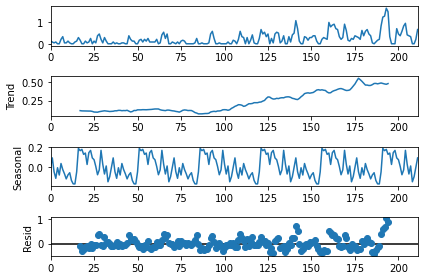

In [128]:
resultado_2019 = seasonal_decompose(dados_medios_completados_2019,period=35)
resultado_2019.plot();

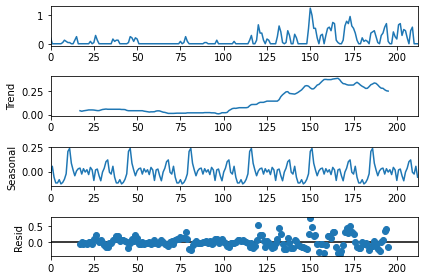

In [129]:
resultado_2020 = seasonal_decompose(dados_medios_completados_2020,period=35)
resultado_2020.plot();

# Etapa 4: Teste Estacionariedade da série
## **Teste de Dickey-Fuller**

Pode ser tamém chamdo de ADF(Augmented Dickey-Fuller):

$\Delta y_t = \beta_t + \beta_{2t} + \delta_{yt-1} + \sum_{i=1}^{m}{\alpha_i \Delta_{yt-1} + \epsilon_t}$

$\beta_1$ - intercepto drift da série

$\beta_2$ - intercepto de tendência

$\delta$  - coeficiente de presença de raiz.

m - número de defasagens tomadas na série.


+ Hipótese nula é se $\delta$ = 0;

Fazemos a regressão de $\Delta_{y_t}$ em que $y_{t-1}$ e repetindo em $\Delta_{y_{t-1}}$ em que $y_{t-2}$ e assim sucesivamente e calculamos a estatística T dada por:

$T = \frac{\delta}{se(\delta)}$

$\^\delta$ - estimador de $\delta$

$se(\^ \delta)$ - estimador do desvio padrão do erro de $\delta$

Resultados do teste Dickey Fuller:
Teste estatístico              -7.607780e+00
p-value                         2.297696e-11
#Lags Usados                    2.000000e+00
Número de observações usadas    2.100000e+02
Valores críticos (1%)          -3.461879e+00
Valores críticos (5%)          -2.875404e+00
Valores críticos (10%)         -2.574159e+00
dtype: float64


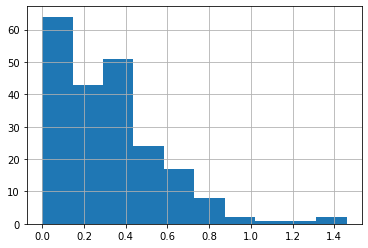

In [130]:
p_v_2016 = teste_estacionariedade(dados_medios_completados_2016)
dados_medios_completados_2016.hist()

Resultados do teste Dickey Fuller:
Teste estatístico                -3.399221
p-value                           0.010985
#Lags Usados                      5.000000
Número de observações usadas    206.000000
Valores críticos (1%)            -3.462499
Valores críticos (5%)            -2.875675
Valores críticos (10%)           -2.574304
dtype: float64


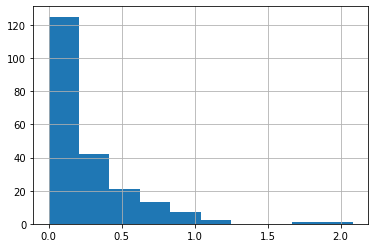

In [131]:
p_v_2017 = teste_estacionariedade(dados_medios_completados_2017)
dados_medios_completados_2017.hist()

Resultados do teste Dickey Fuller:
Teste estatístico                -4.902970
p-value                           0.000034
#Lags Usados                      2.000000
Número de observações usadas    209.000000
Valores críticos (1%)            -3.462032
Valores críticos (5%)            -2.875471
Valores críticos (10%)           -2.574195
dtype: float64


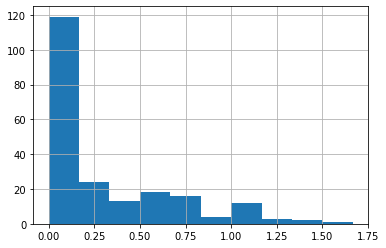

In [132]:
p_v_2018 = teste_estacionariedade(dados_medios_completados_2018)
dados_medios_completados_2018.hist()

Resultados do teste Dickey Fuller:
Teste estatístico              -6.377288e+00
p-value                         2.267316e-08
#Lags Usados                    1.000000e+00
Número de observações usadas    2.100000e+02
Valores críticos (1%)          -3.461879e+00
Valores críticos (5%)          -2.875404e+00
Valores críticos (10%)         -2.574159e+00
dtype: float64


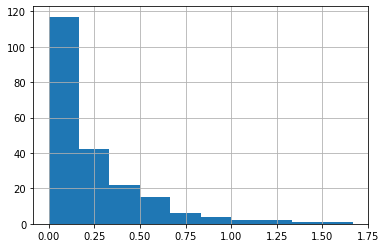

In [133]:
p_v_2019 = teste_estacionariedade(dados_medios_completados_2019)
dados_medios_completados_2019.hist()

Resultados do teste Dickey Fuller:
Teste estatístico                -1.688329
p-value                           0.437136
#Lags Usados                     11.000000
Número de observações usadas    201.000000
Valores críticos (1%)            -3.463309
Valores críticos (5%)            -2.876029
Valores críticos (10%)           -2.574493
dtype: float64


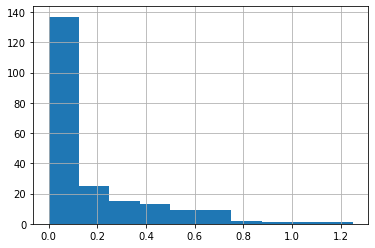

In [134]:
p_v_2020 = teste_estacionariedade(dados_medios_completados_2020)
dados_medios_completados_2020.hist()

# Etapa 5: Autocorrelação para verificar a periodicidade e sazonalidade da série

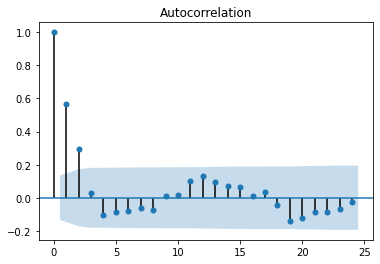

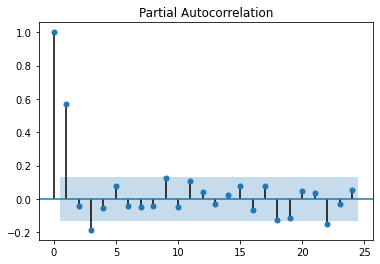

In [135]:
plot_acf(dados_medios_completados_2016);
plot_pacf(dados_medios_completados_2016);

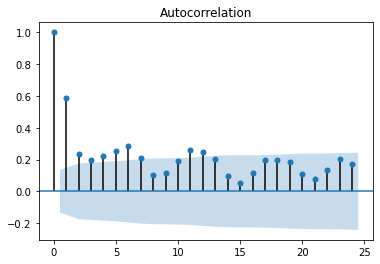

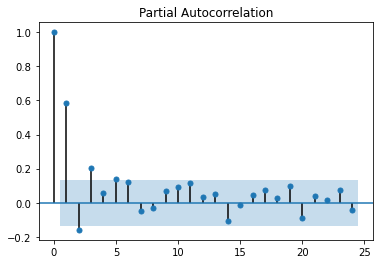

In [136]:
plot_acf(dados_medios_completados_2017);
plot_pacf(dados_medios_completados_2017);

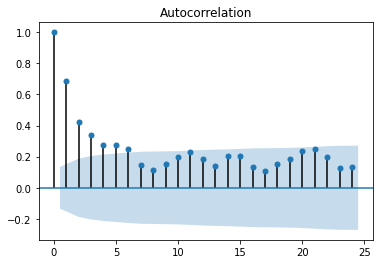

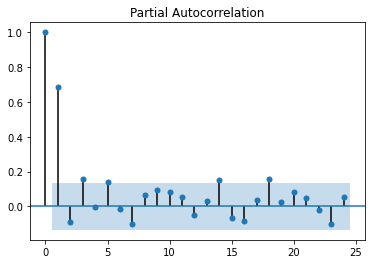

In [137]:
plot_acf(dados_medios_completados_2018);
plot_pacf(dados_medios_completados_2018);

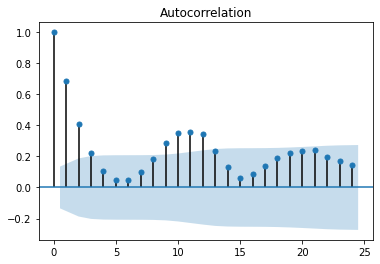

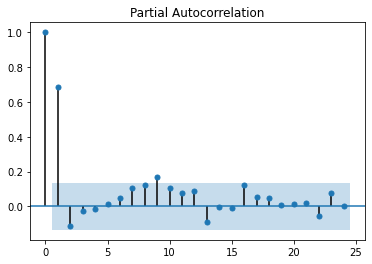

In [138]:
plot_acf(dados_medios_completados_2019);
plot_pacf(dados_medios_completados_2019);

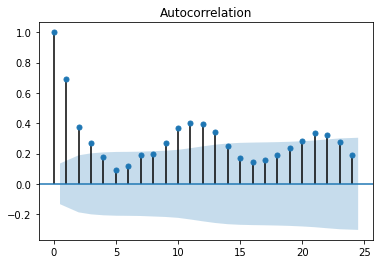

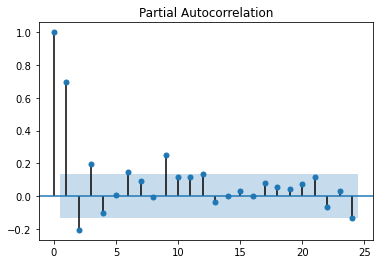

In [139]:
plot_acf(dados_medios_completados_2020);
plot_pacf(dados_medios_completados_2020);

# Etapa 6: Verificando variação nos dados - velocidade de mudança

In [140]:
def ano_bisexto(ano):
    nome_eixo_x = pd.DataFrame({'Dia':[]})
    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-01-0'+str(i)},ignore_index=True)    
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-01-'+str(i)},ignore_index=True)            

    for i in range(1,30):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-02-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-02-'+str(i)},ignore_index=True)           

    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-03-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-03-'+str(i)},ignore_index=True)   


    for i in range(1,31):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-04-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-04-'+str(i)},ignore_index=True)   

    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-05-0'+str(i)},ignore_index=True)       
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-05-'+str(i)},ignore_index=True)       

    for i in range(1,31):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-06-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-06-'+str(i)},ignore_index=True)


    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-07-0'+str(i)},ignore_index=True)       
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-07-'+str(i)},ignore_index=True)

    return nome_eixo_x


def ano_normal(ano):
    nome_eixo_x = pd.DataFrame({'Dia':[]})
    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-01-0'+str(i)},ignore_index=True)    
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-01-'+str(i)},ignore_index=True)            

    for i in range(1,29):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-02-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-02-'+str(i)},ignore_index=True)           

    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-03-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-03-'+str(i)},ignore_index=True)   


    for i in range(1,31):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-04-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-04-'+str(i)},ignore_index=True)   

    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-05-0'+str(i)},ignore_index=True)       
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-05-'+str(i)},ignore_index=True)       

    for i in range(1,31):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-06-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-06-'+str(i)},ignore_index=True)


    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-07-0'+str(i)},ignore_index=True)       
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-07-'+str(i)},ignore_index=True)

    return nome_eixo_x


eixo_2016 = ano_bisexto(2016)
eixo_2017 = ano_normal(2017)
eixo_2018 = ano_normal(2018)
eixo_2019 = ano_normal(2019)
eixo_2020 = ano_bisexto(2020)

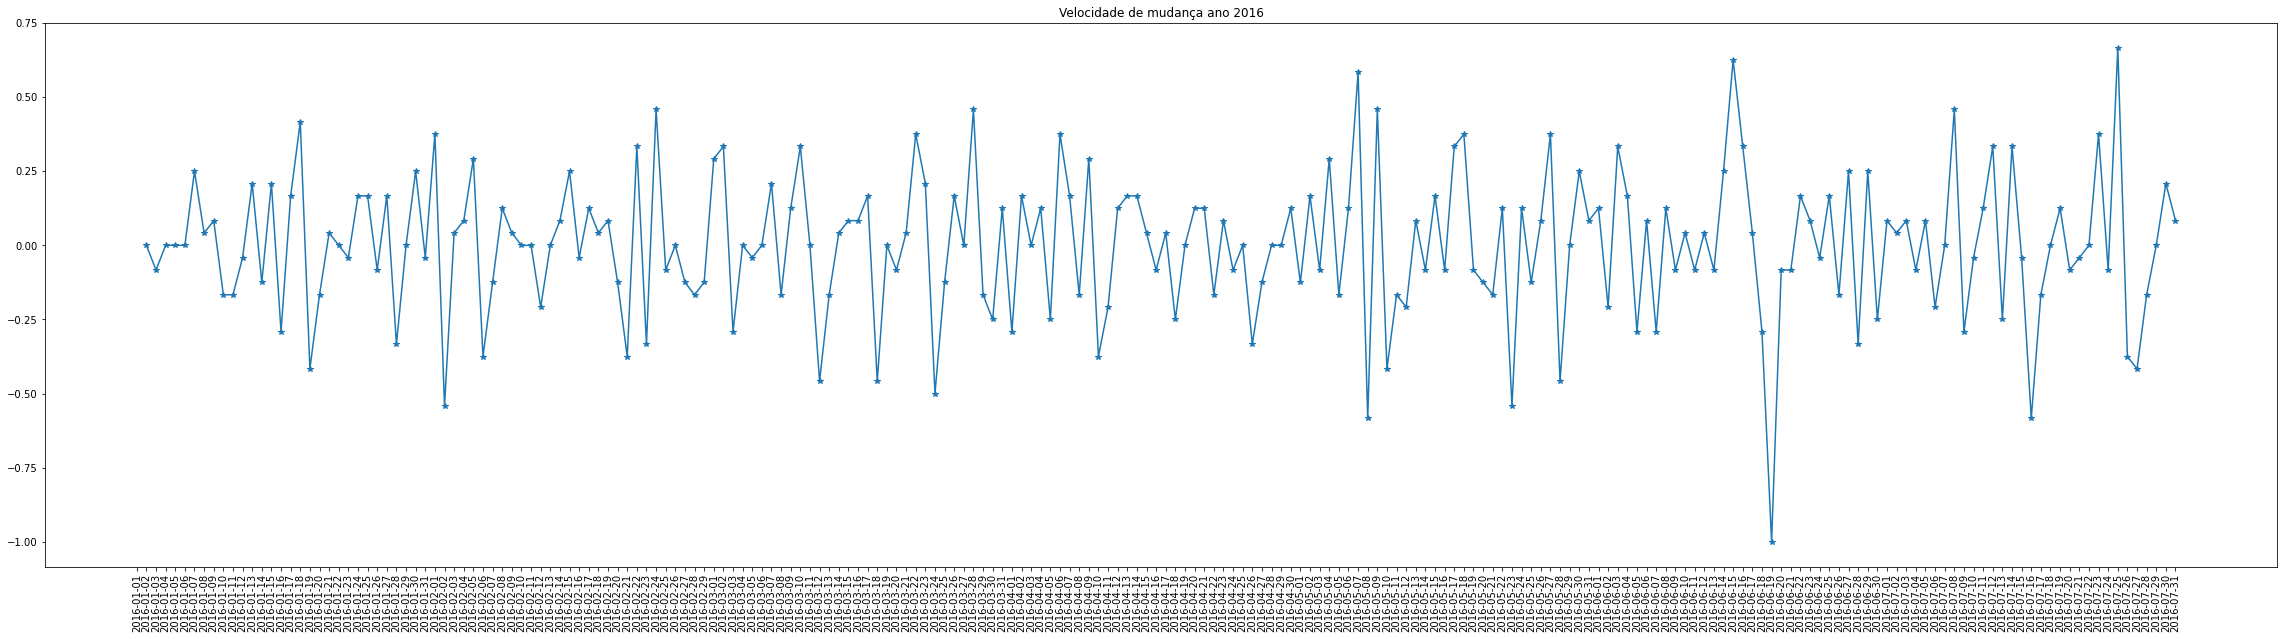

In [141]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2016')
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2016.values],rotation=90)
plt.plot(dados_medios_completados_2016.diff(),'*-')
plt.show()

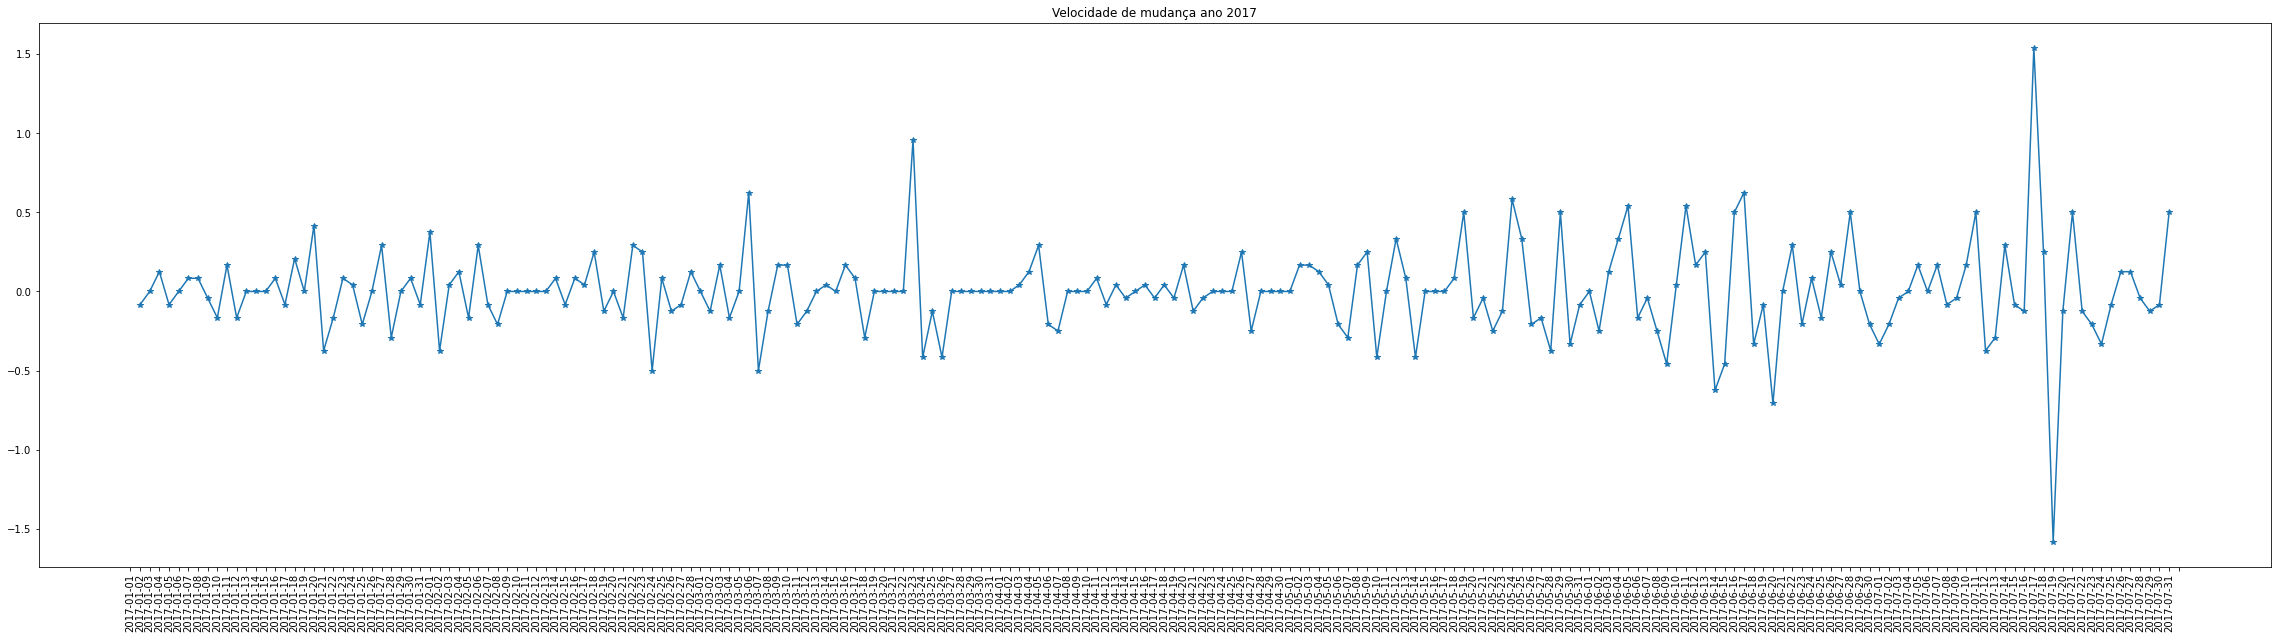

In [142]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2017')
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2017.values],rotation=90)
plt.plot(dados_medios_completados_2017.diff(),'*-');
plt.show()

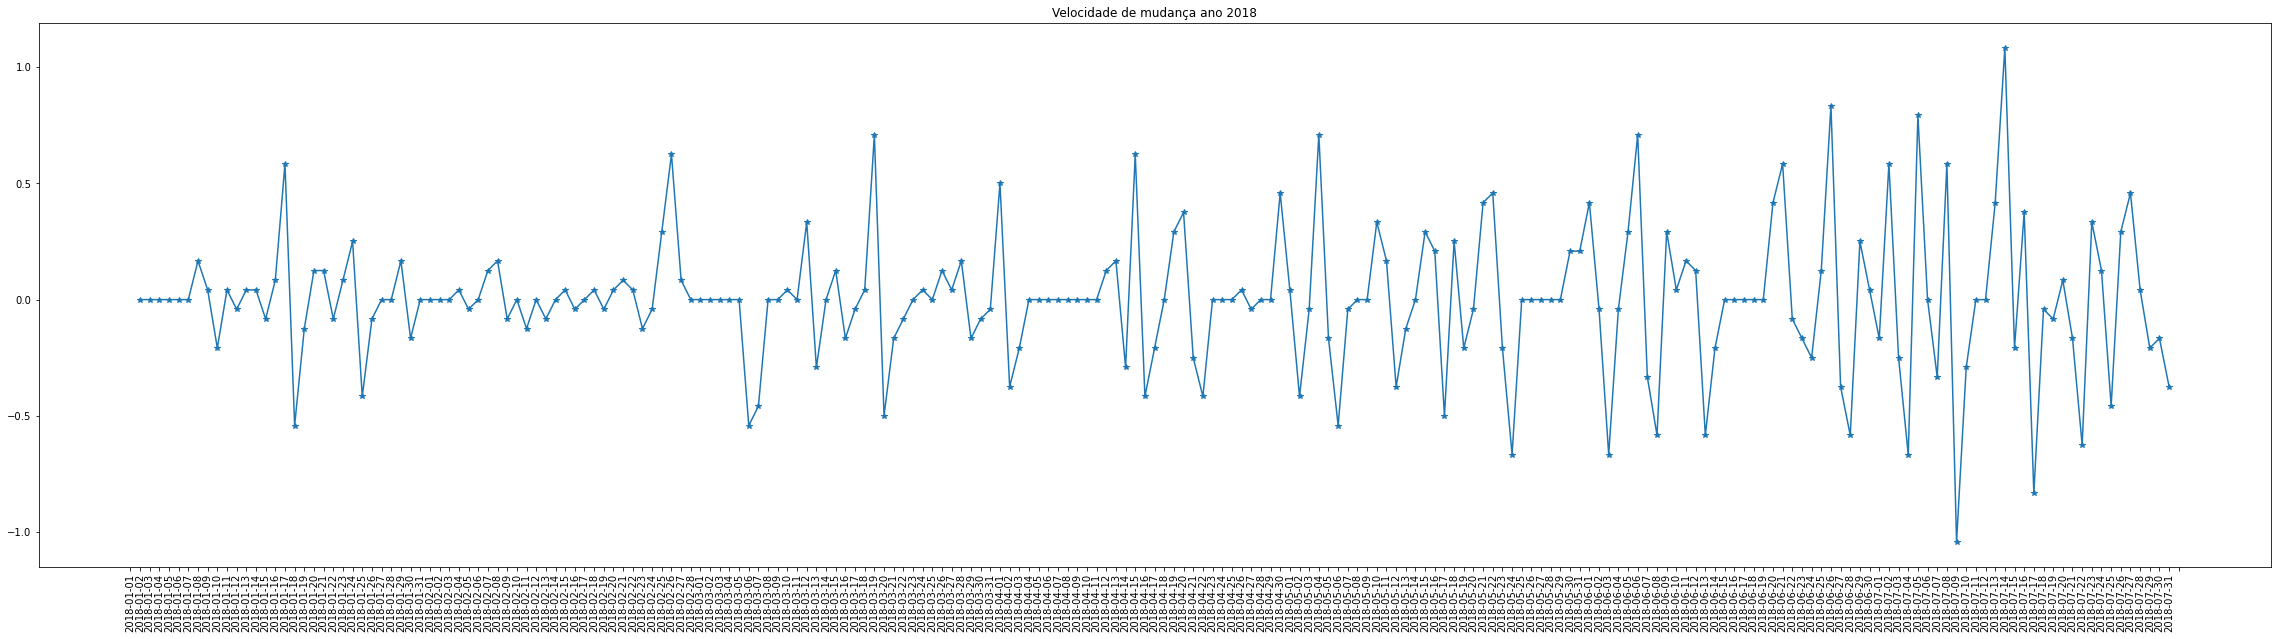

In [143]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2018')
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2018.values],rotation=90)
plt.plot(dados_medios_completados_2018.diff(),'*-');
plt.show()

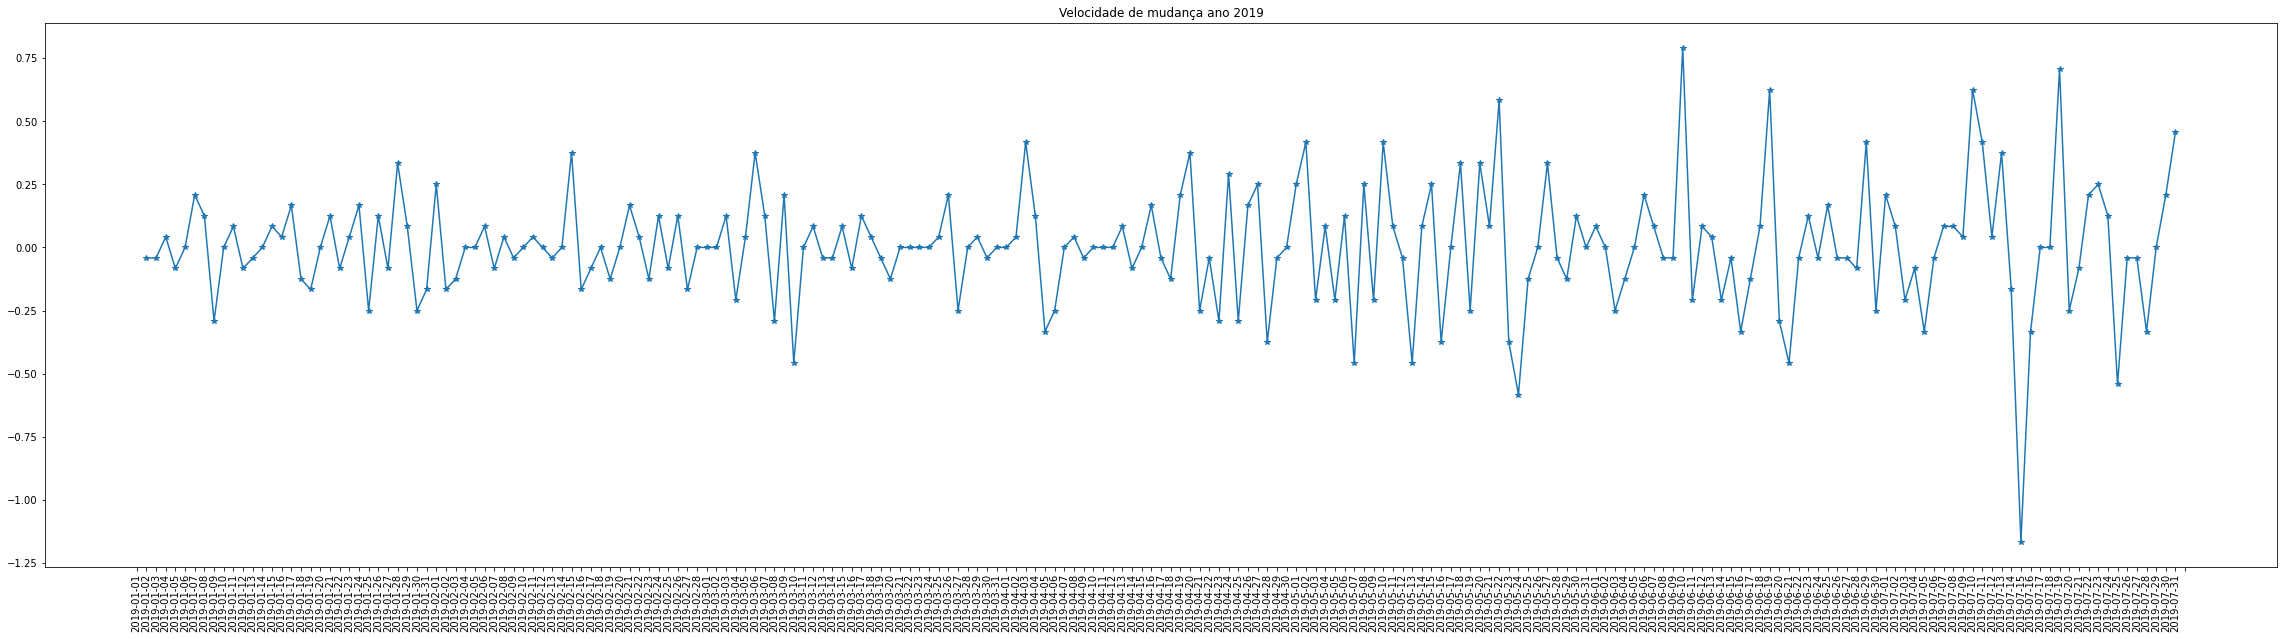

In [144]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2019')
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2019.values],rotation=90)
plt.plot(dados_medios_completados_2019.diff(),'*-');
plt.show()

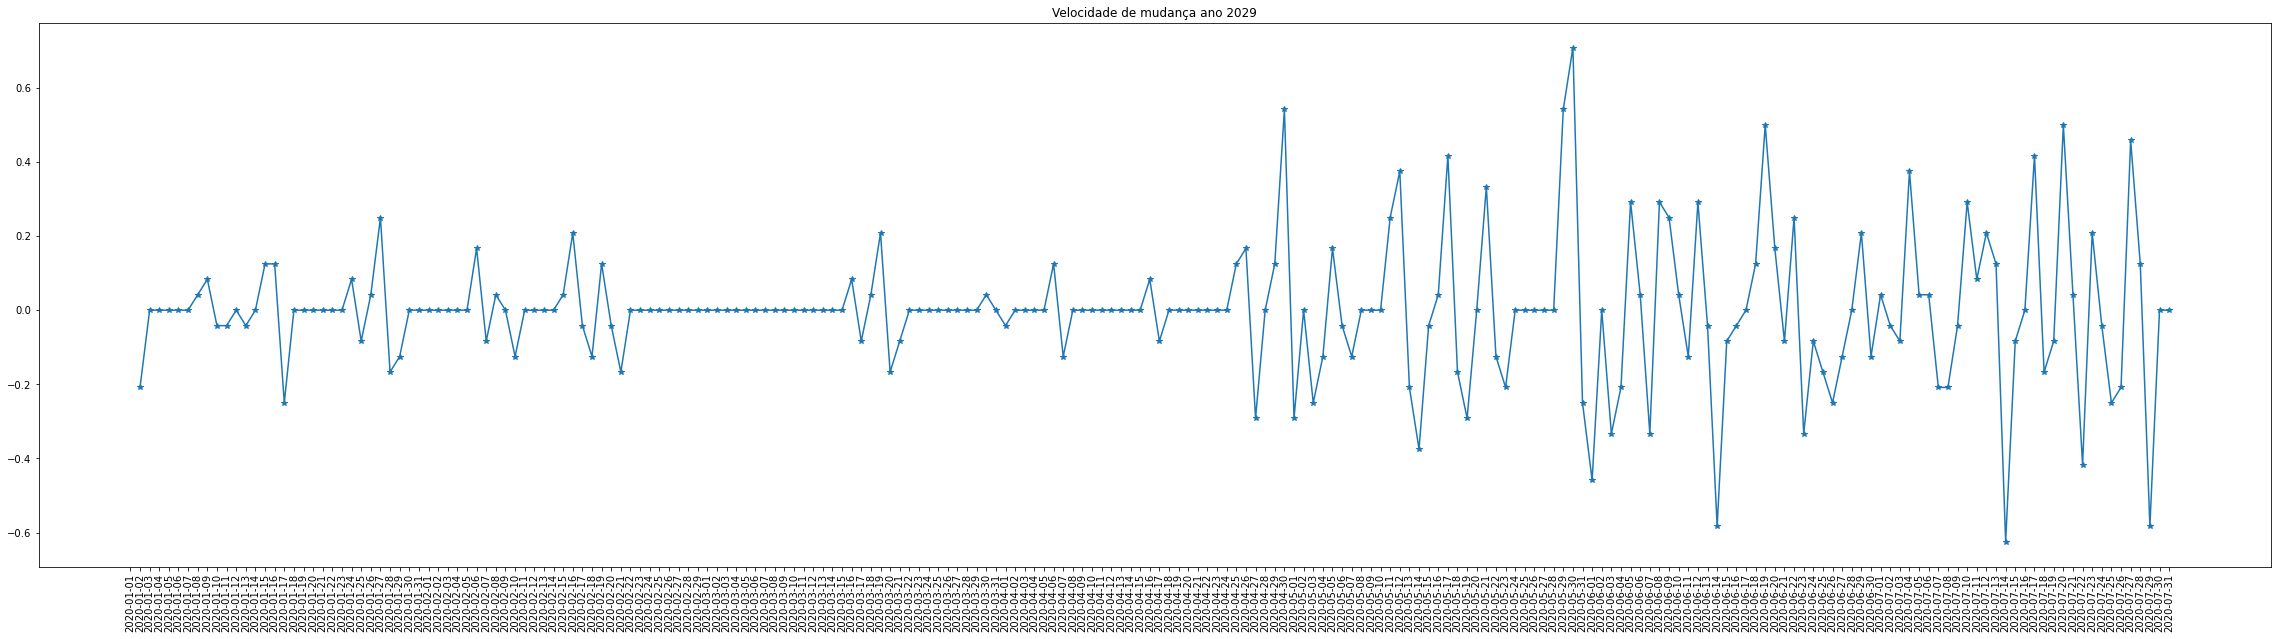

In [145]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2029')
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2020.values],rotation=90)
plt.plot(dados_medios_completados_2020.diff(),'*-');
plt.show()

# Etapa 6: Verificando variação nos dados - aceleração de mudança

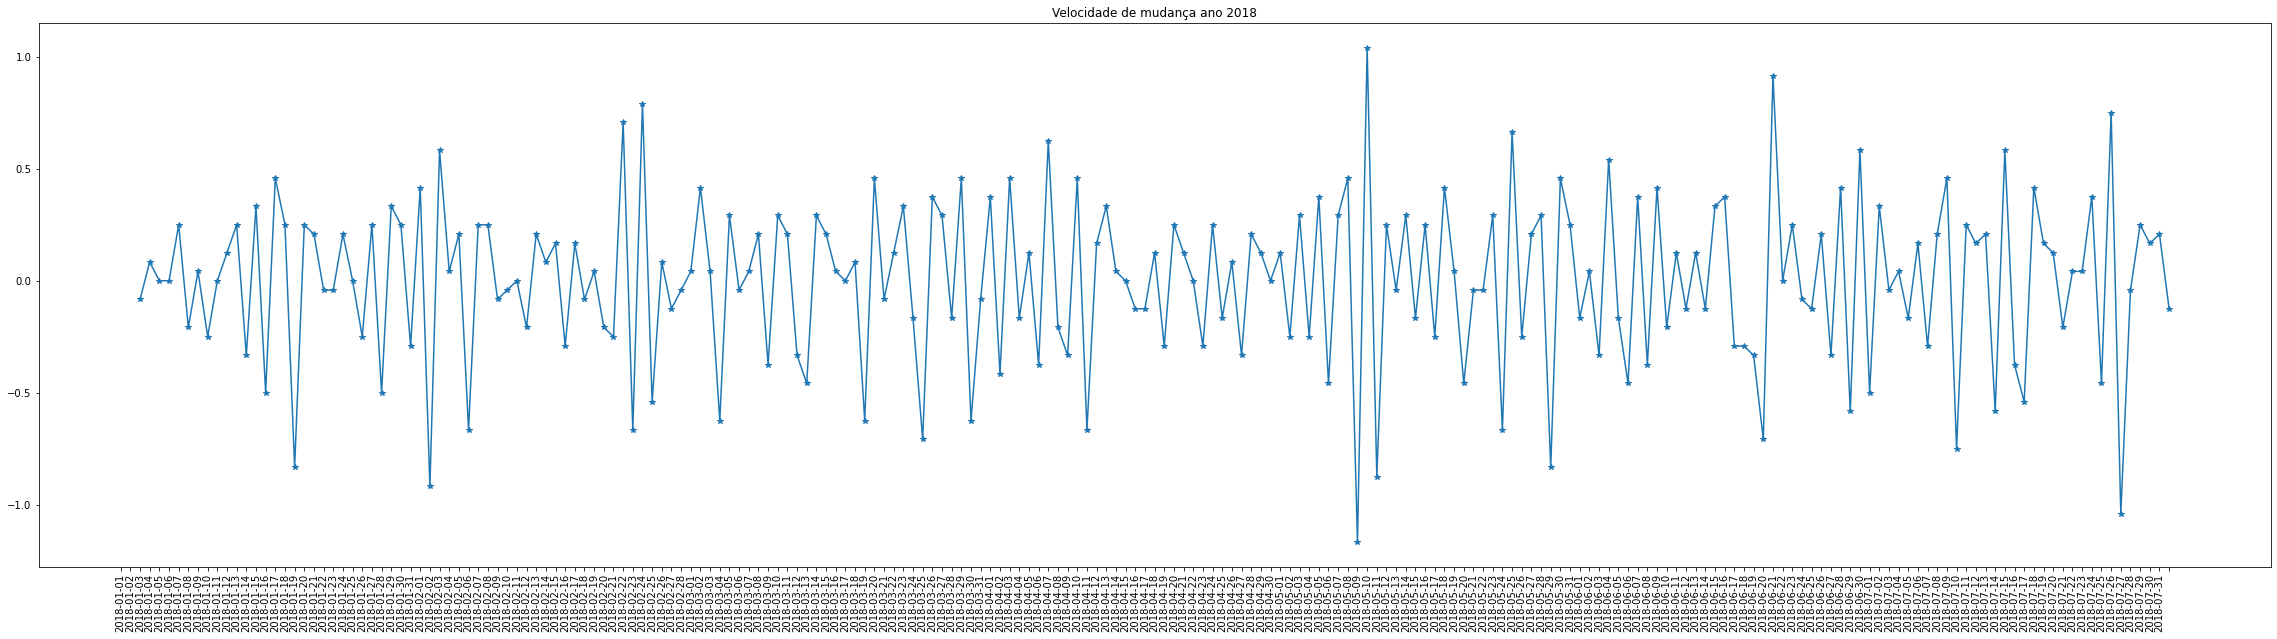

In [146]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2018')
velocidade_2016 = dados_medios_completados_2016.diff()
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2018.values],rotation=90)
plt.plot(velocidade_2016.diff(),'*-');
plt.show()

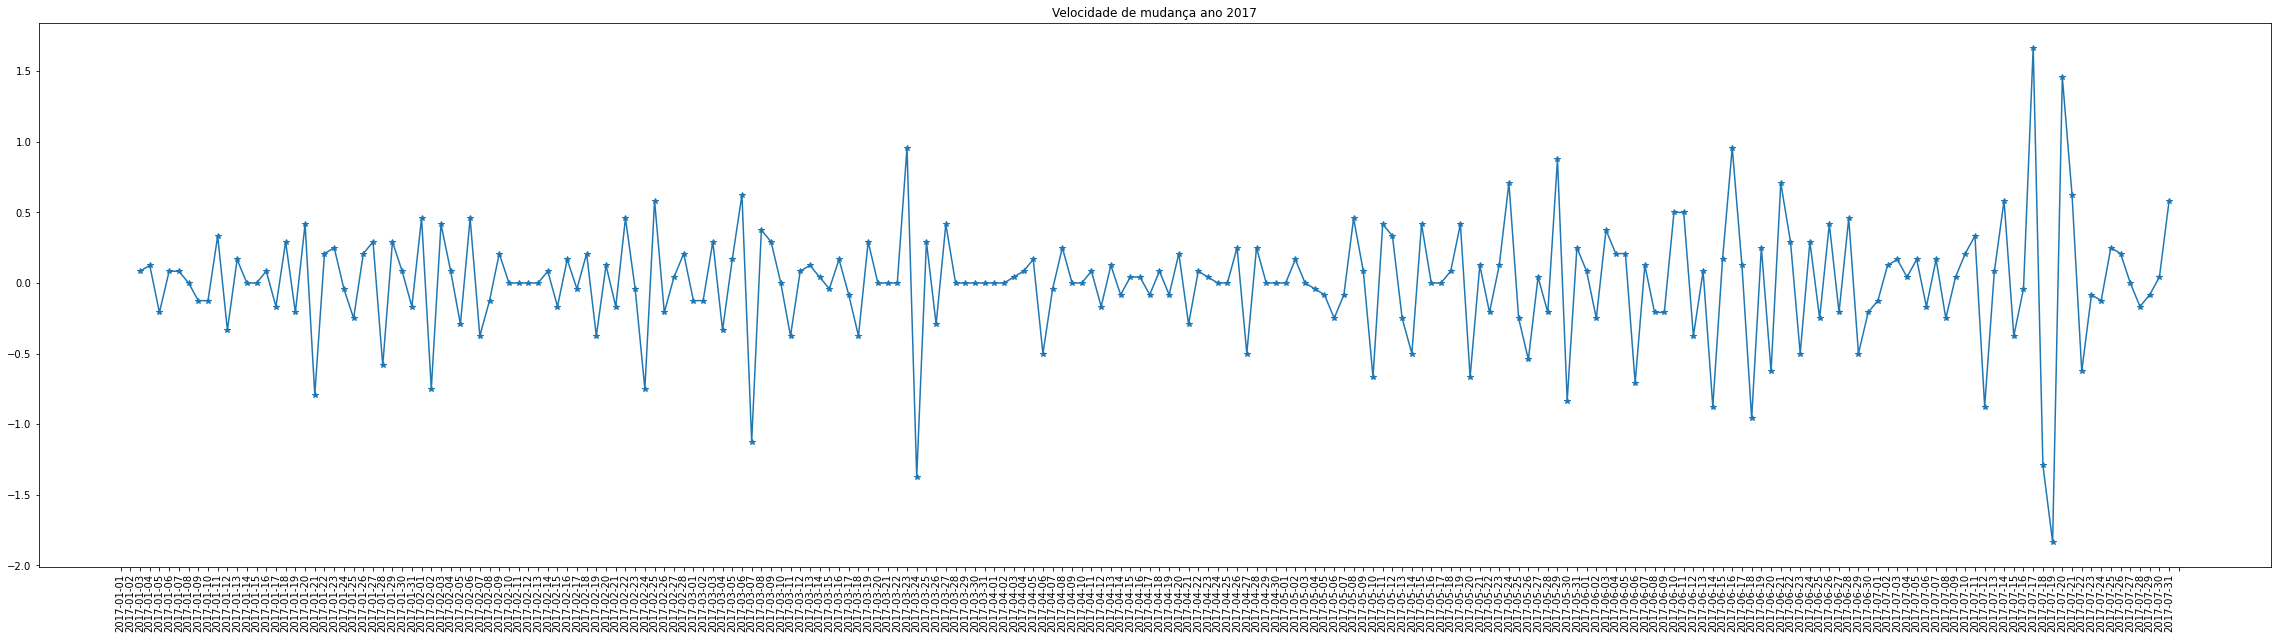

In [147]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2017')
velocidade_2017 = dados_medios_completados_2017.diff()
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2017.values],rotation=90)
plt.plot(velocidade_2017.diff(),'*-')
plt.show()

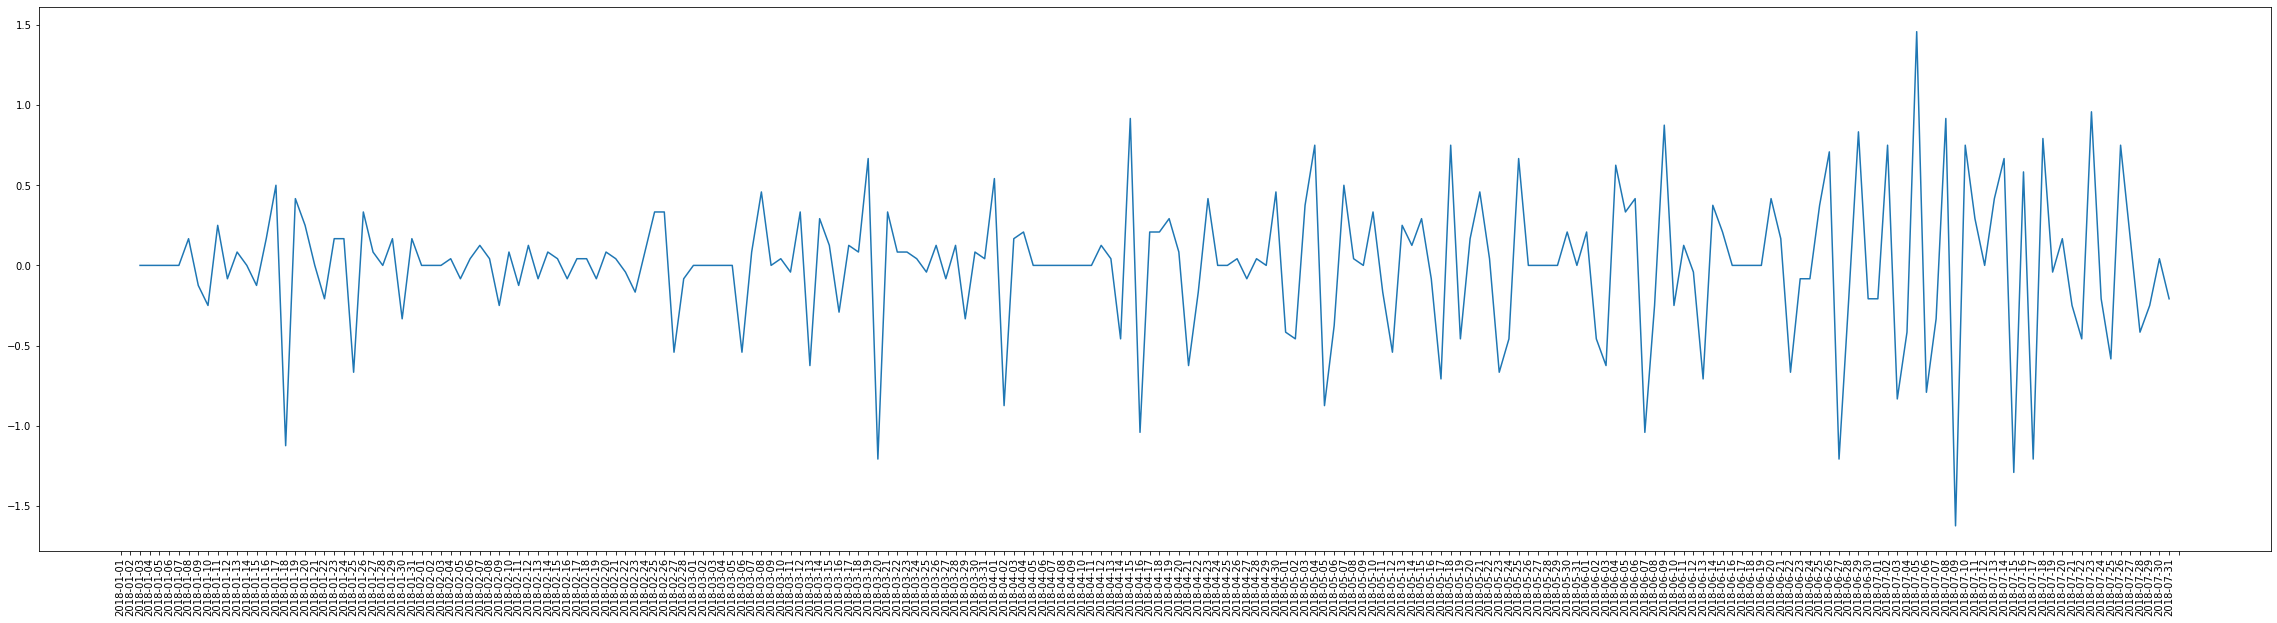

In [148]:
plt.figure(figsize=(40,10))
velocidade_2018 = dados_medios_completados_2018.diff()
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2018.values],rotation=90)
plt.plot(velocidade_2018.diff());
plt.show()

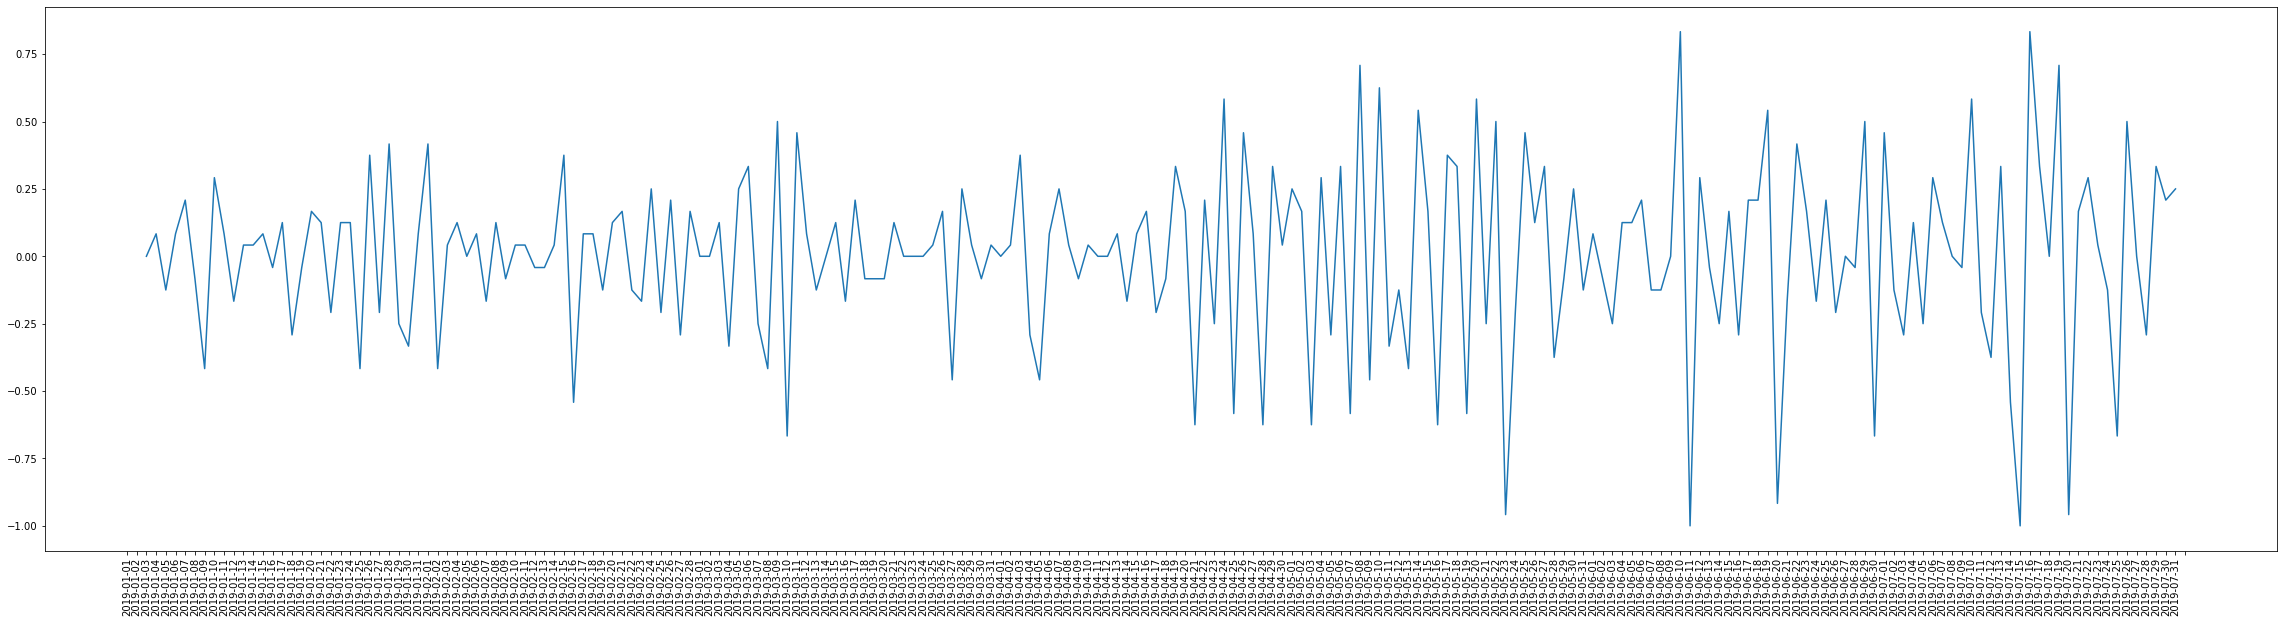

In [149]:
plt.figure(figsize=(40,10))
velocidade_2019 = dados_medios_completados_2019.diff()
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2019.values],rotation=90)
plt.plot(velocidade_2019.diff());
plt.show()

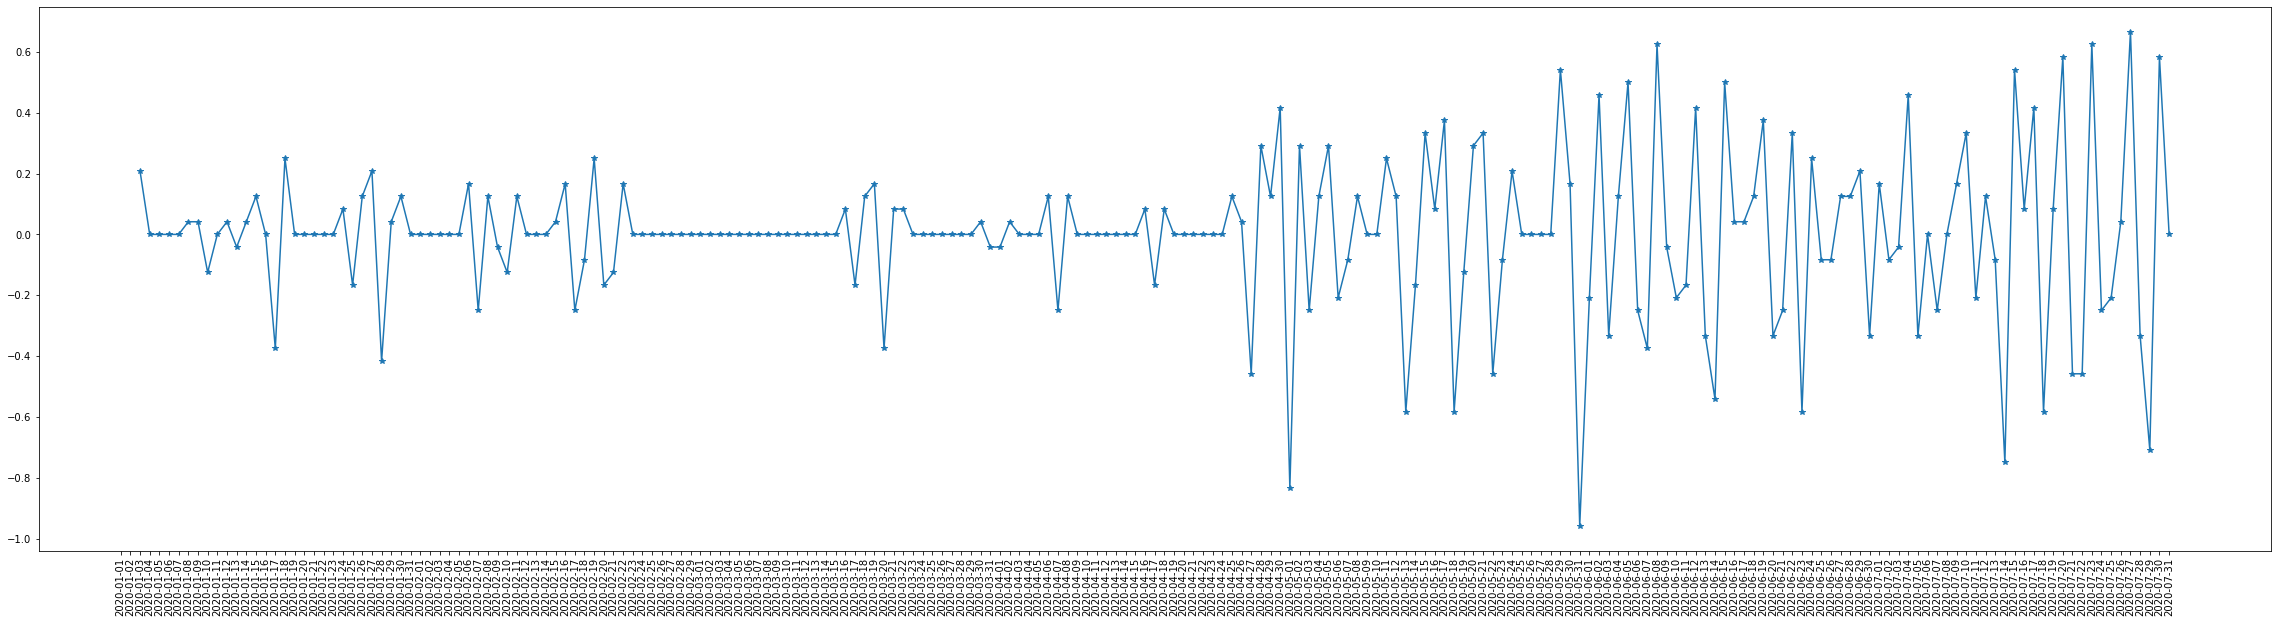

In [150]:
plt.figure(figsize=(40,10))
velocidade_2020 = dados_medios_completados_2020.diff()
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2020.values],rotation=90)
plt.plot(velocidade_2020.diff(),'*-')
plt.show()

# Etapa 7: Autocorrelação da série

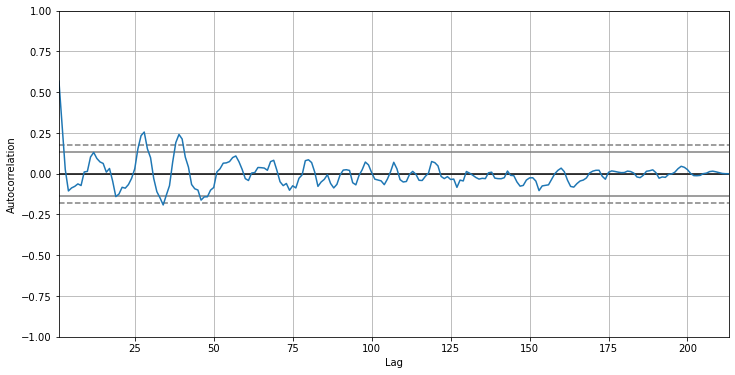

In [151]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2016);

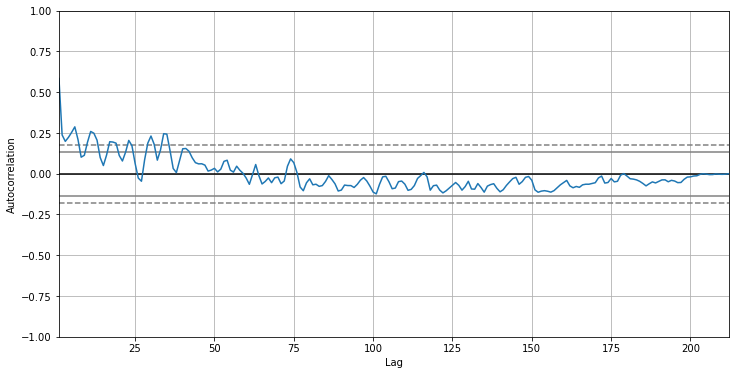

In [152]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2017)

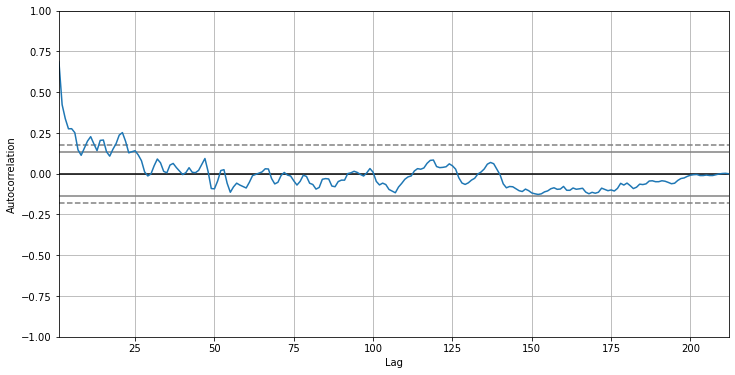

In [153]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2018)

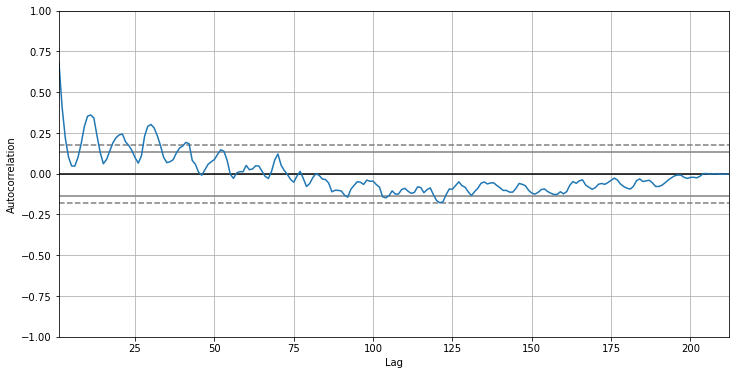

In [154]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2019)

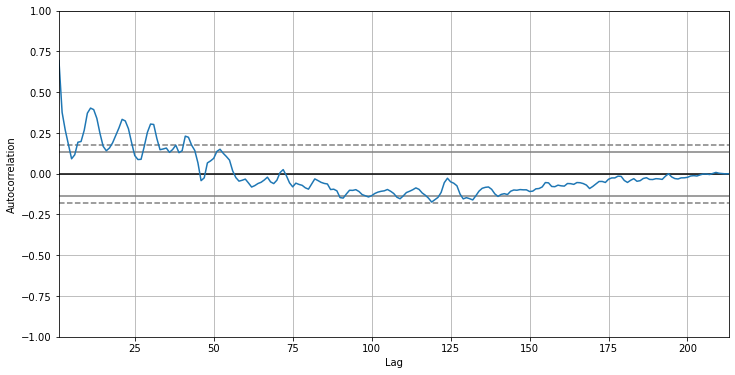

In [155]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2020)

# Parte 2: Juntando os dados

In [156]:
serie_completa = dados_medios_completados_2017
serie_completa = serie_completa.append(dados_medios_completados_2018)
serie_completa = serie_completa.append(dados_medios_completados_2019)
serie_completa = serie_completa.append(dados_medios_completados_2020)
serie_completa.reset_index(drop=True,inplace=True)
serie_completa

0      0.083333
1      0.000000
2      0.000000
3      0.125000
4      0.041667
         ...   
844    0.458333
845    0.583333
846    0.000000
847    0.000000
848    0.000000
Length: 849, dtype: float64

# Etapa 3: Decompondo a série

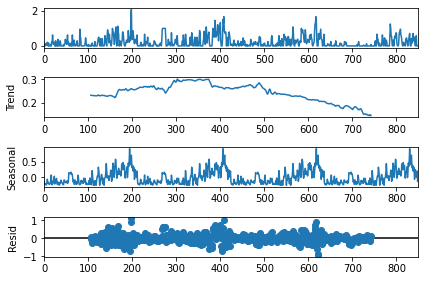

In [157]:
resultado = seasonal_decompose(serie_completa,period=212)
resultado.plot();

# Etapa 4: Teste de estacionariedade

Resultados do teste Dickey Fuller:
Teste estatístico                -4.790990
p-value                           0.000057
#Lags Usados                     10.000000
Número de observações usadas    838.000000
Valores críticos (1%)            -3.438177
Valores críticos (5%)            -2.864995
Valores críticos (10%)           -2.568610
dtype: float64


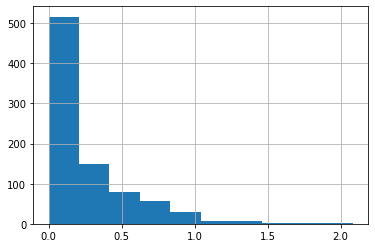

In [158]:
p_value = teste_estacionariedade(serie_completa)
serie_completa.hist()

# Etapa 5: Autocorrelação para verificar a periodicidade e sazonalidade da série

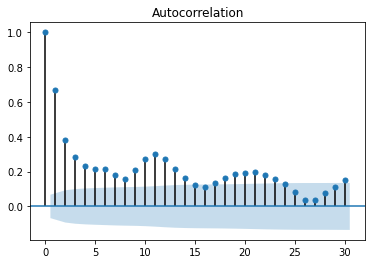

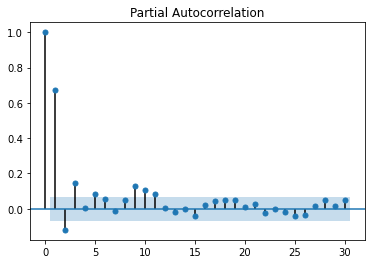

In [159]:
plot_acf(serie_completa);
plot_pacf(serie_completa);

# Etapa 6: Verificando variação nos dados - velocidade de mudança

In [160]:
eixo_2016_2019 = pd.concat([eixo_2016,eixo_2017,eixo_2018,eixo_2019])
eixo_2016_2019.reset_index(drop=True,inplace=True)
eixo_2017_2020 = pd.concat([eixo_2017,eixo_2018,eixo_2019,eixo_2020])
eixo_2017_2020.reset_index(drop=True,inplace=True)

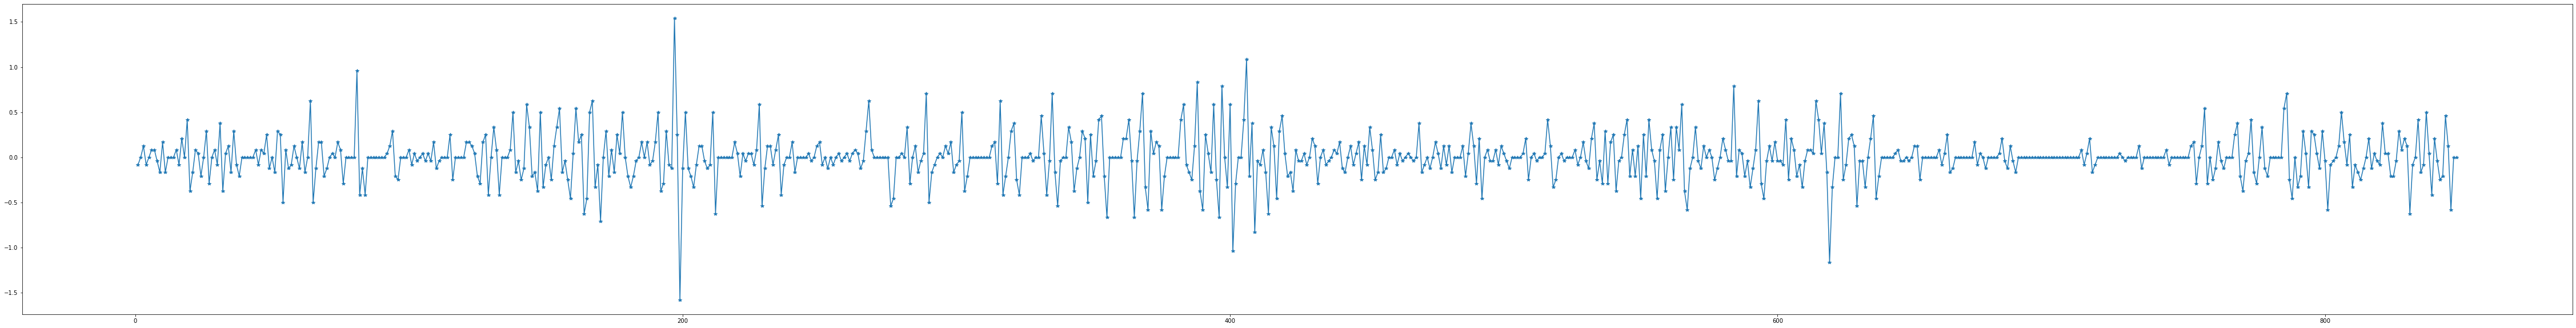

In [161]:
plt.figure(figsize=(80,10))
plt.plot(serie_completa.diff(),'*-');


# Etapa 7: Verificando variação nos dados - aceleração de mudança

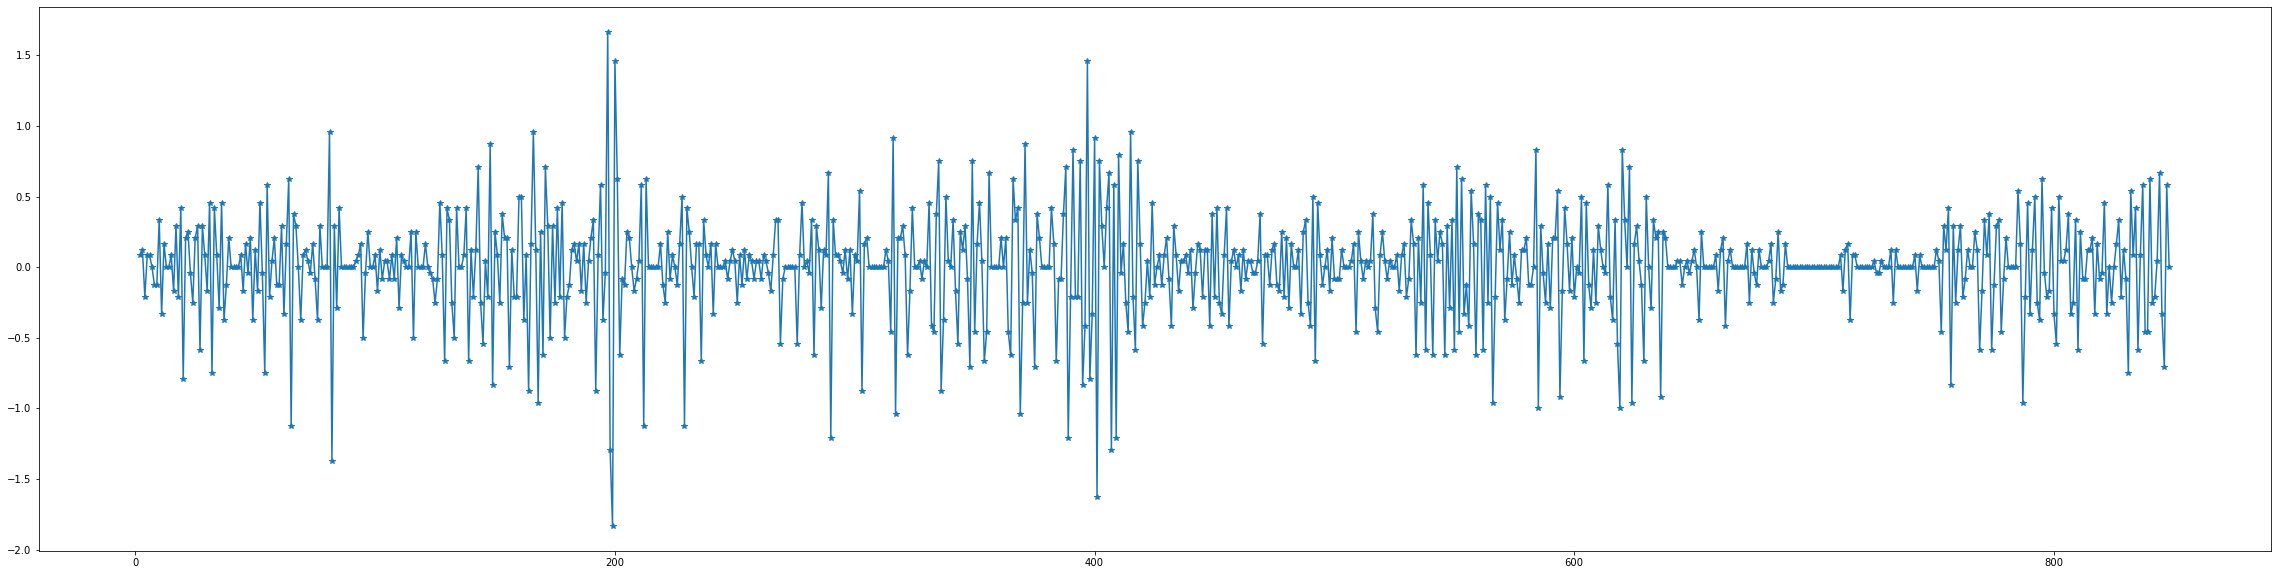

In [162]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa.diff().diff(),'*-')

# Etapa 7: Autocorrelação da série

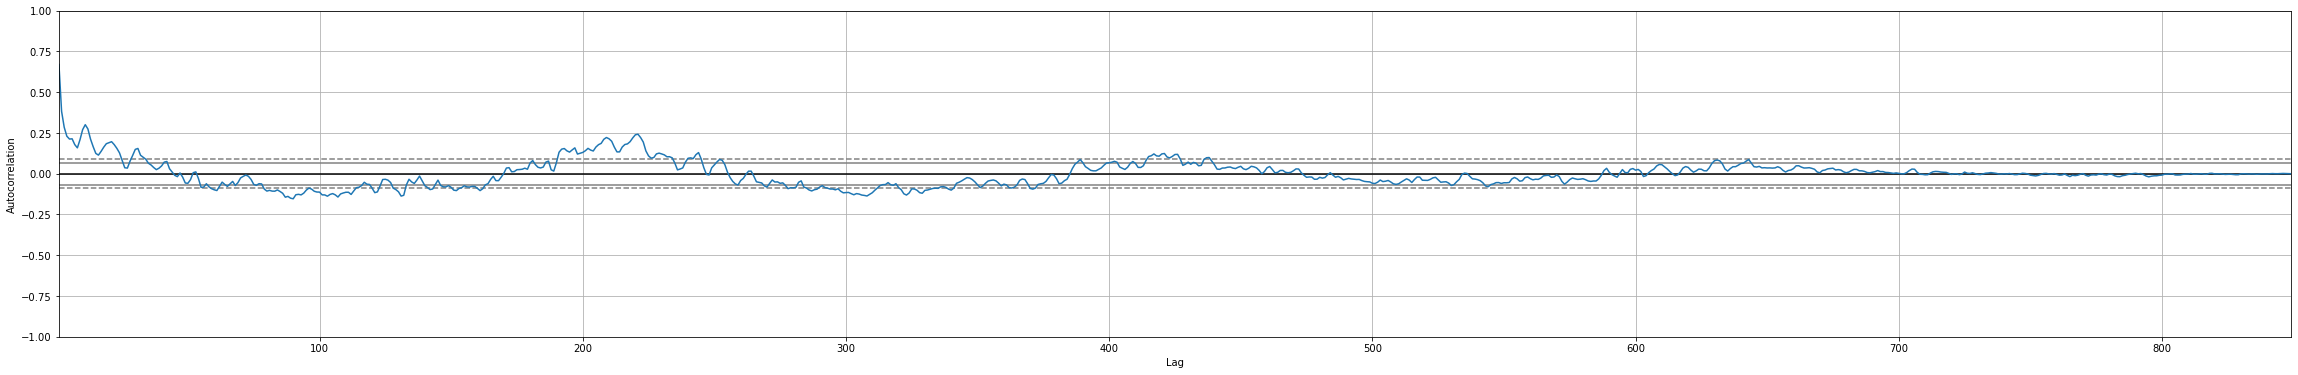

In [163]:
plt.figure(figsize=(40,6))
autocorrelation_plot(serie_completa)

# Comparação com os dados de 2016

In [164]:
serie_completa_com_2016 = dados_medios_completados_2016
serie_completa_com_2016 = serie_completa_com_2016.append(dados_medios_completados_2017)
serie_completa_com_2016 = serie_completa_com_2016.append(dados_medios_completados_2018)
serie_completa_com_2016 = serie_completa_com_2016.append(dados_medios_completados_2019)
serie_completa_com_2016.reset_index(drop=True,inplace=True)
serie_completa_com_2016

0      0.083333
1      0.083333
2      0.000000
3      0.000000
4      0.000000
         ...   
844    0.333333
845    0.000000
846    0.000000
847    0.208333
848    0.666667
Length: 849, dtype: float64

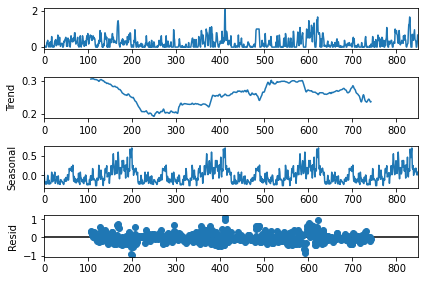

In [165]:
resultado = seasonal_decompose(serie_completa_com_2016,period=212)
resultado.plot();

Resultados do teste Dickey Fuller:
Teste estatístico                -5.229389
p-value                           0.000008
#Lags Usados                     10.000000
Número de observações usadas    838.000000
Valores críticos (1%)            -3.438177
Valores críticos (5%)            -2.864995
Valores críticos (10%)           -2.568610
dtype: float64


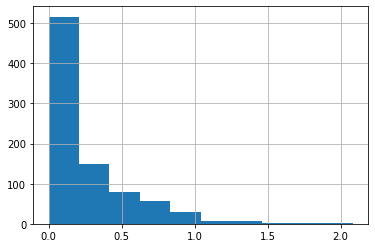

In [166]:
p_value = teste_estacionariedade(serie_completa_com_2016)
serie_completa.hist()

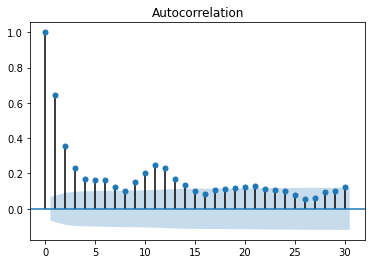

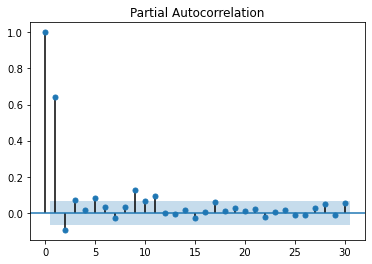

In [167]:
plot_acf(serie_completa_com_2016);
plot_pacf(serie_completa_com_2016);

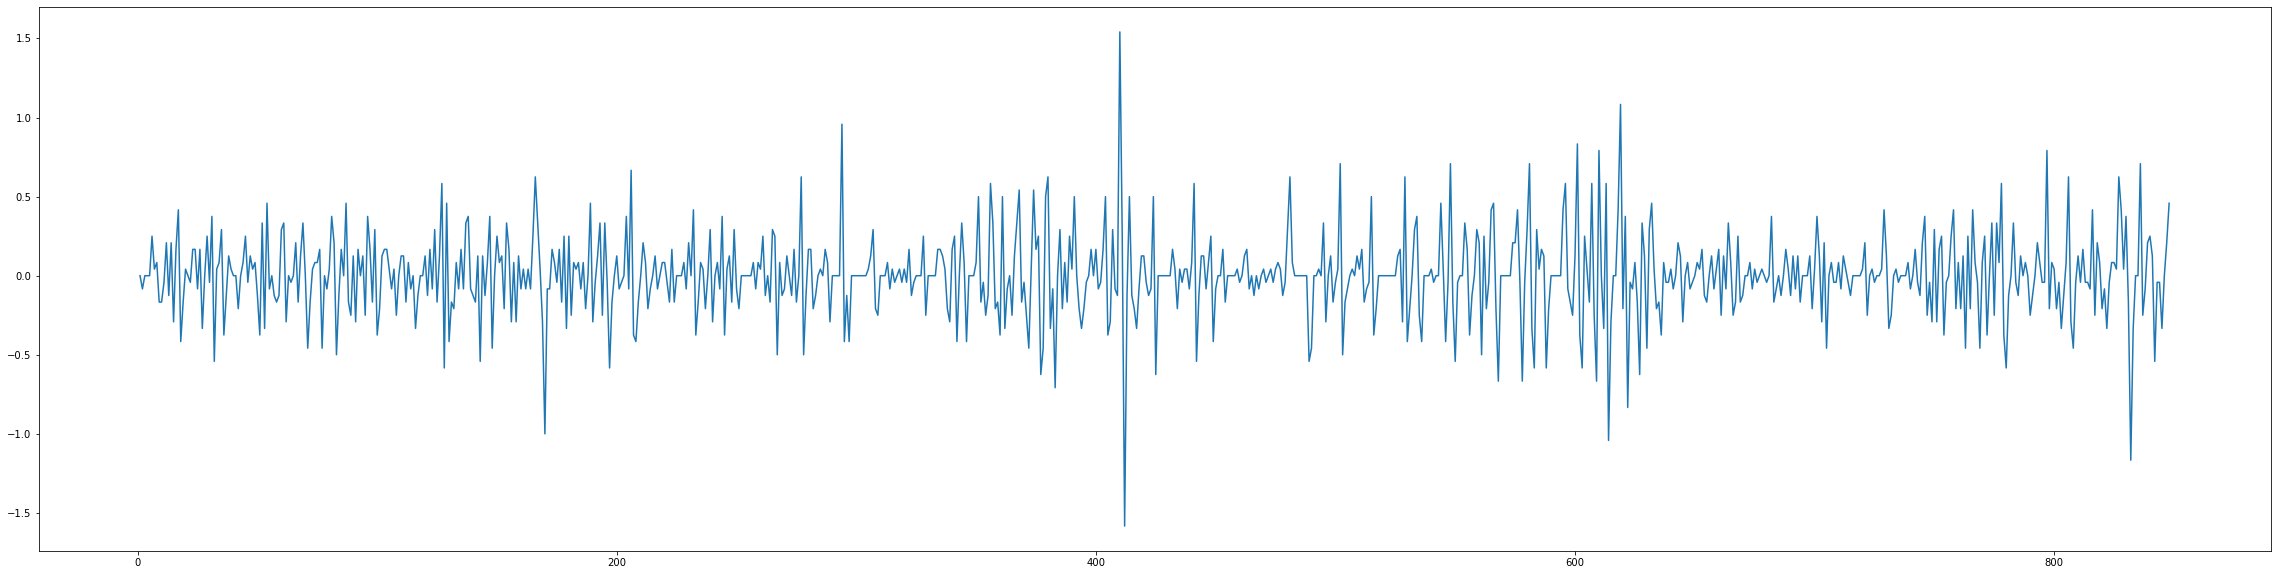

In [168]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_com_2016.diff()) 

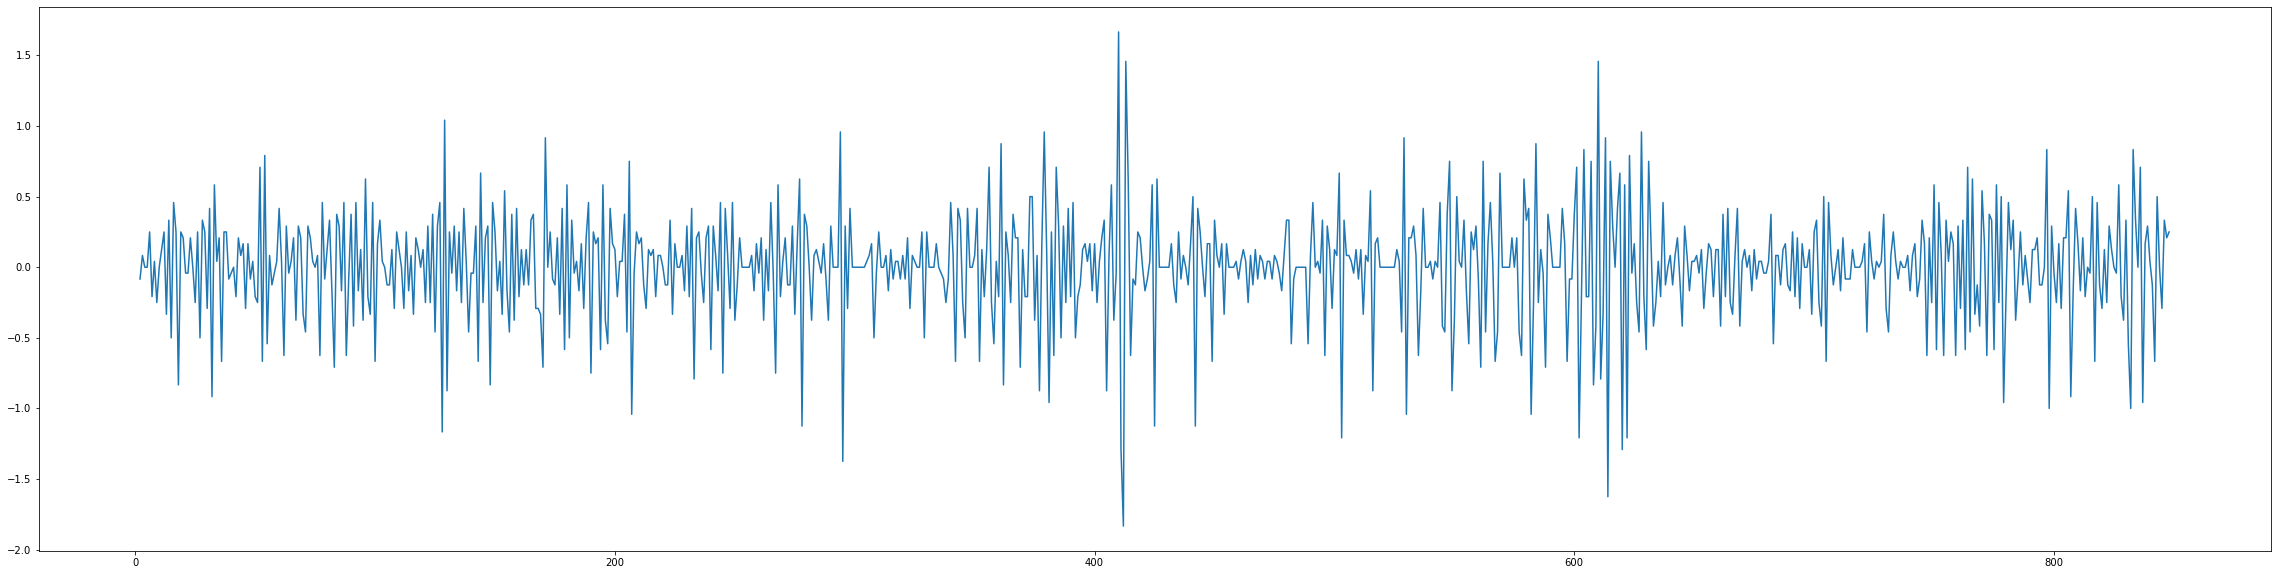

In [169]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_com_2016.diff().diff())

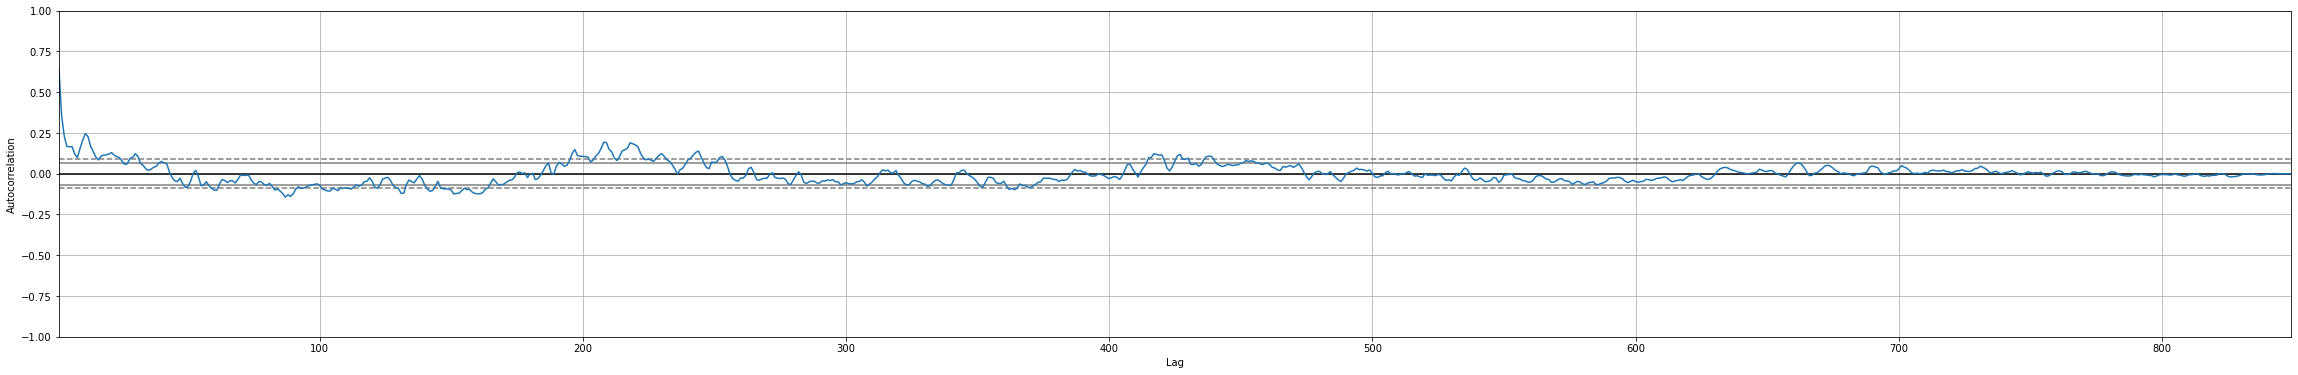

In [170]:
plt.figure(figsize=(40,6))
autocorrelation_plot(serie_completa_com_2016)

# Tratamento com dados suavizados

MAPE:inf
MAE:0.16670653907496003
MQE:0.049400252525252514


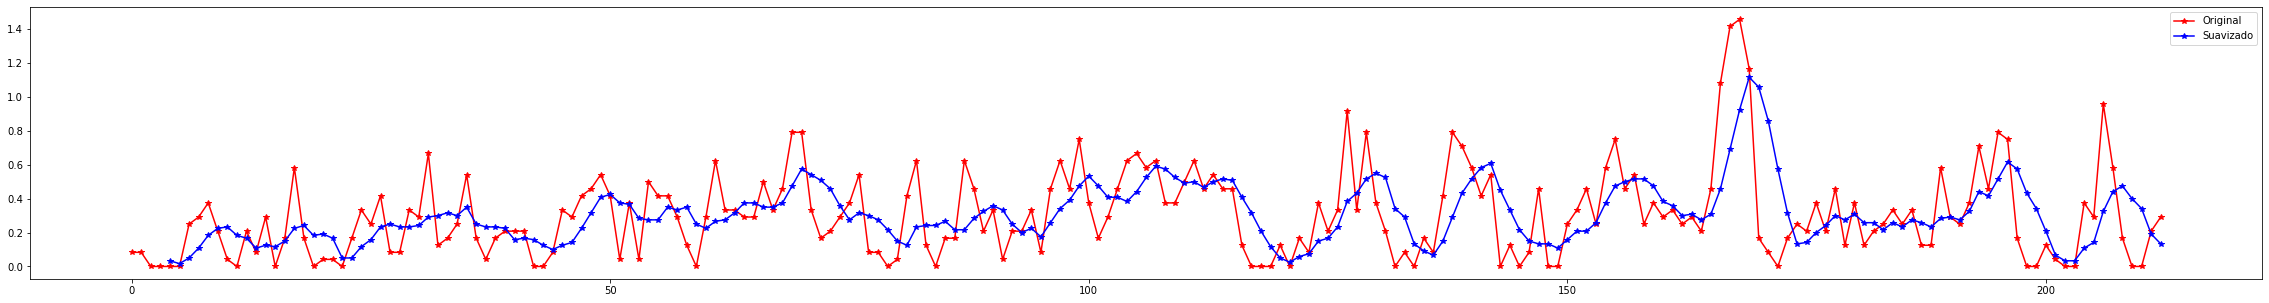

In [171]:
st_2016_suavizado = alisar_serie(dados_medios_completados_2016,p_v_2016)

MAPE:nan
MAE:0.16229967948717952
MQE:0.057736044337606825


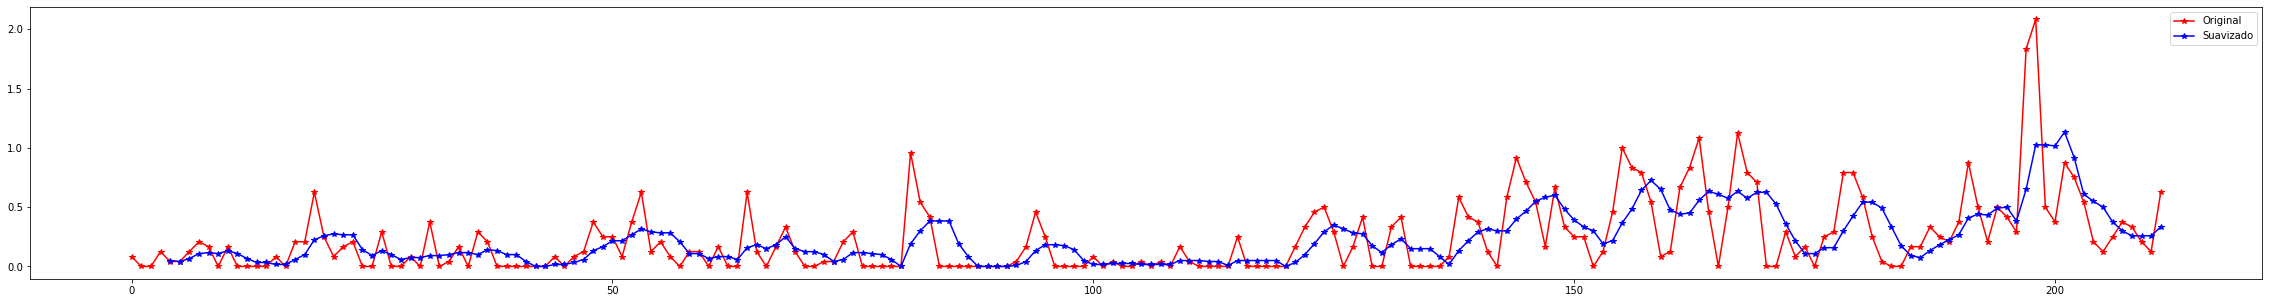

In [172]:
st_2017_suavizado = alisar_serie(dados_medios_completados_2017,p_v_2017)

MAPE:nan
MAE:0.19370993589743588
MQE:0.07199819711538456


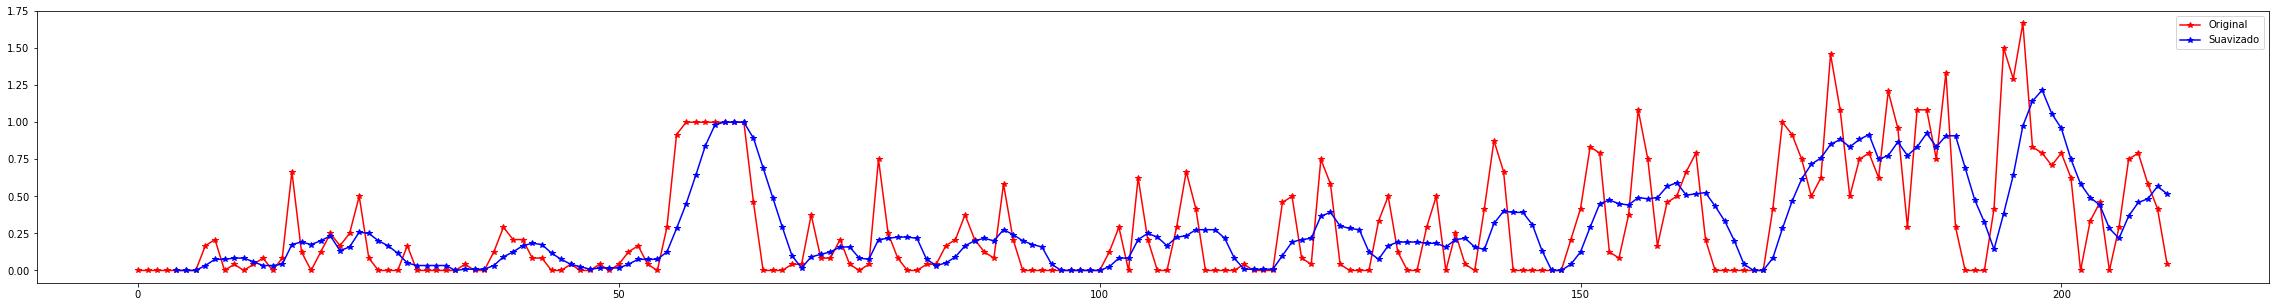

In [173]:
st_2018_suavizado = alisar_serie(dados_medios_completados_2018,p_v_2018)

MAPE:nan
MAE:0.19370993589743588
MQE:0.07199819711538456


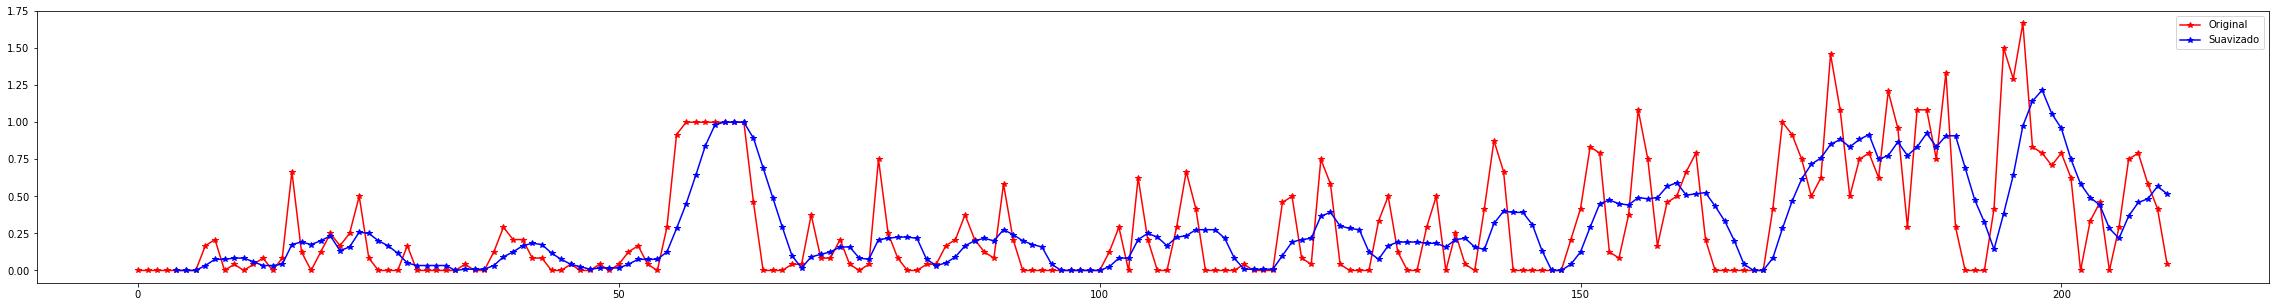

In [174]:
st_2019_suavizado = alisar_serie(dados_medios_completados_2018,p_v_2019)

MAPE:106.0
MAE:106.0
MQE:106.0


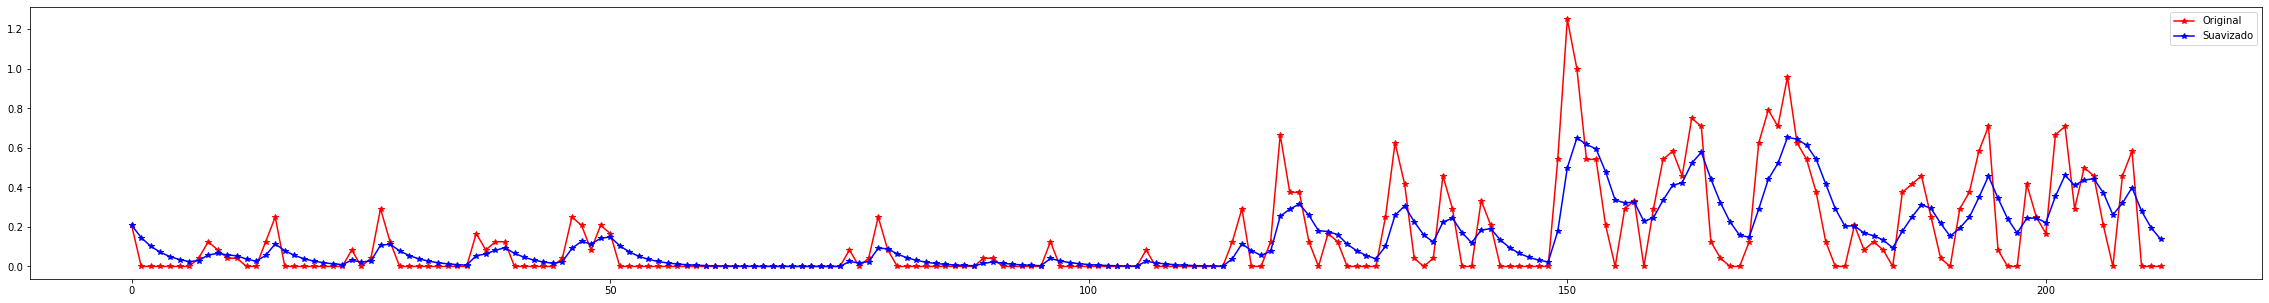

In [175]:
st_2020_suavizado = alisar_serie(dados_medios_completados_2020,p_v_2020)

# Decomposição da série

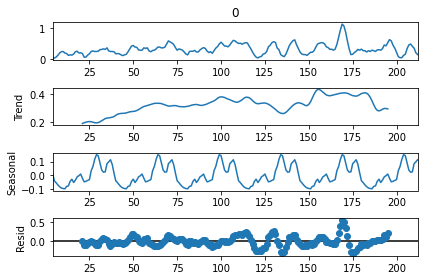

In [176]:
resultado_2016 = seasonal_decompose(st_2016_suavizado,period=35)
resultado_2016.plot();

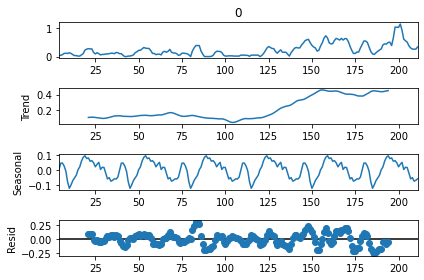

In [177]:
resultado_2017 = seasonal_decompose(st_2017_suavizado,period=35)
resultado_2017.plot();

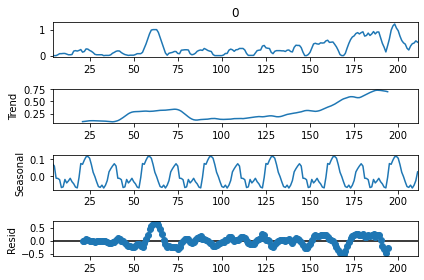

In [178]:
resultado_2018 = seasonal_decompose(st_2018_suavizado,period=35)
resultado_2018.plot();

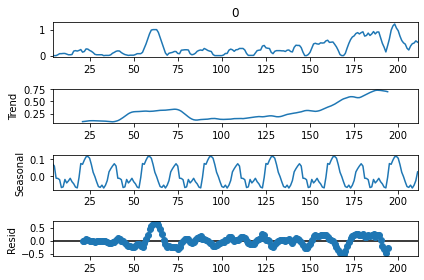

In [179]:
resultado_2019 = seasonal_decompose(st_2019_suavizado,period=35)
resultado_2019.plot();

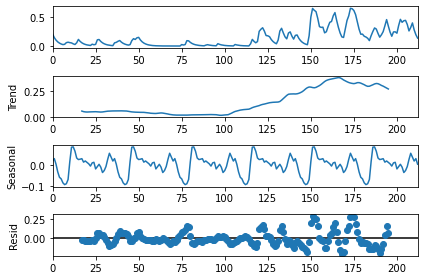

In [180]:
resultado_2020 = seasonal_decompose(st_2020_suavizado,period=35)
resultado_2020.plot();

# Autocorrelação para verificar a periodicidade e sazonalidade da série

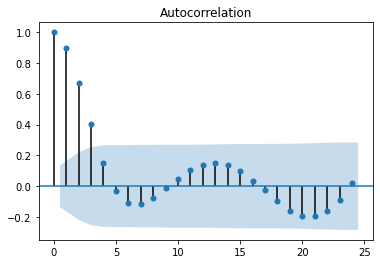

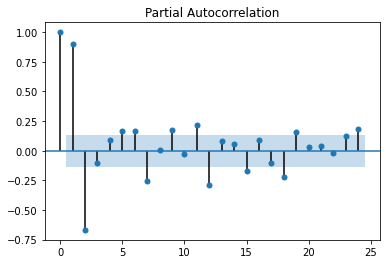

In [181]:
plot_acf(st_2016_suavizado);
plot_pacf(st_2016_suavizado);

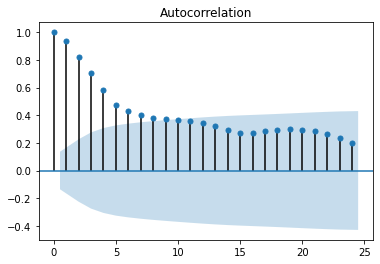

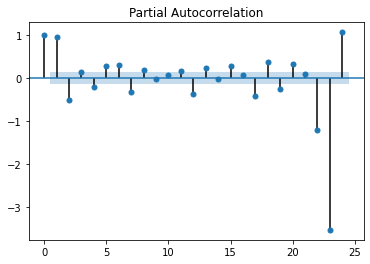

In [182]:
plot_acf(st_2017_suavizado);
plot_pacf(st_2017_suavizado);

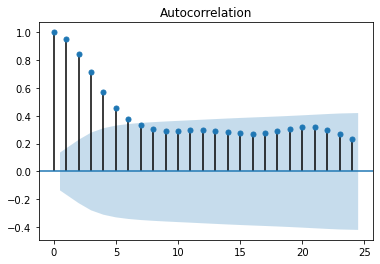

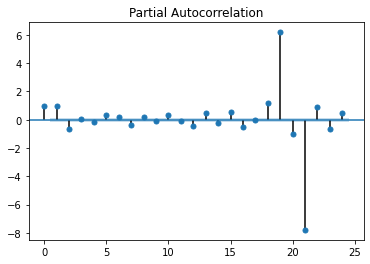

In [183]:
plot_acf(st_2018_suavizado);
plot_pacf(st_2018_suavizado);

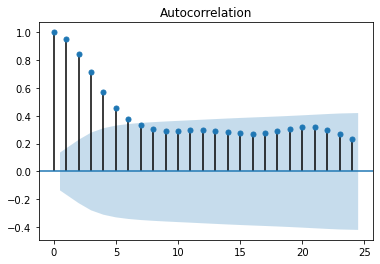

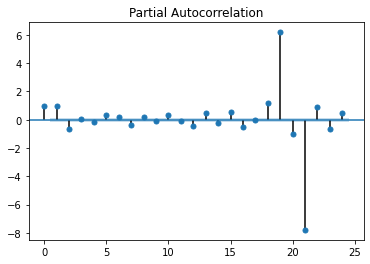

In [184]:
plot_acf(st_2019_suavizado);
plot_pacf(st_2019_suavizado);

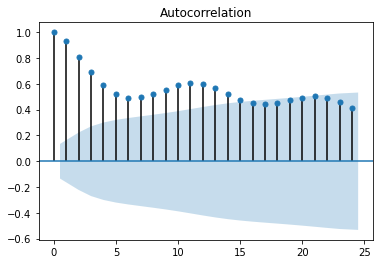

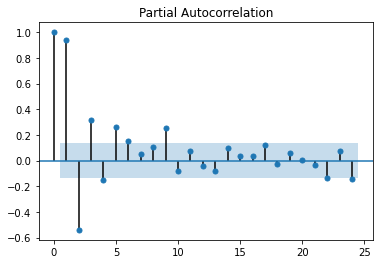

In [185]:
plot_acf(st_2020_suavizado);
plot_pacf(st_2020_suavizado);

# Verificando a variação nos dados - velocidade de mundaça

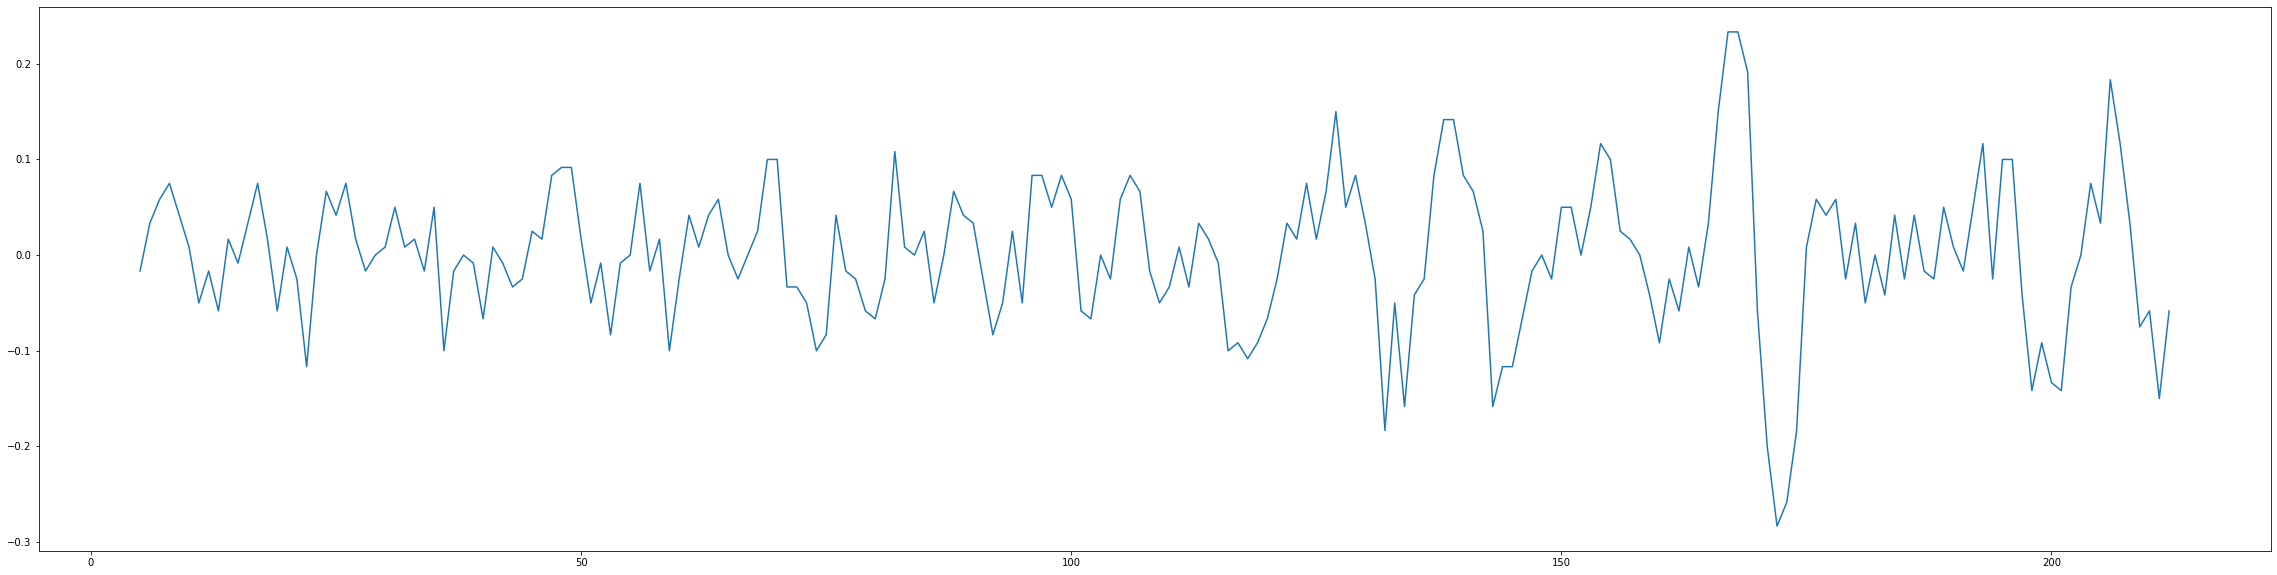

In [186]:
plt.figure(figsize=(40,10))
plt.plot(st_2016_suavizado.diff());
plt.show()

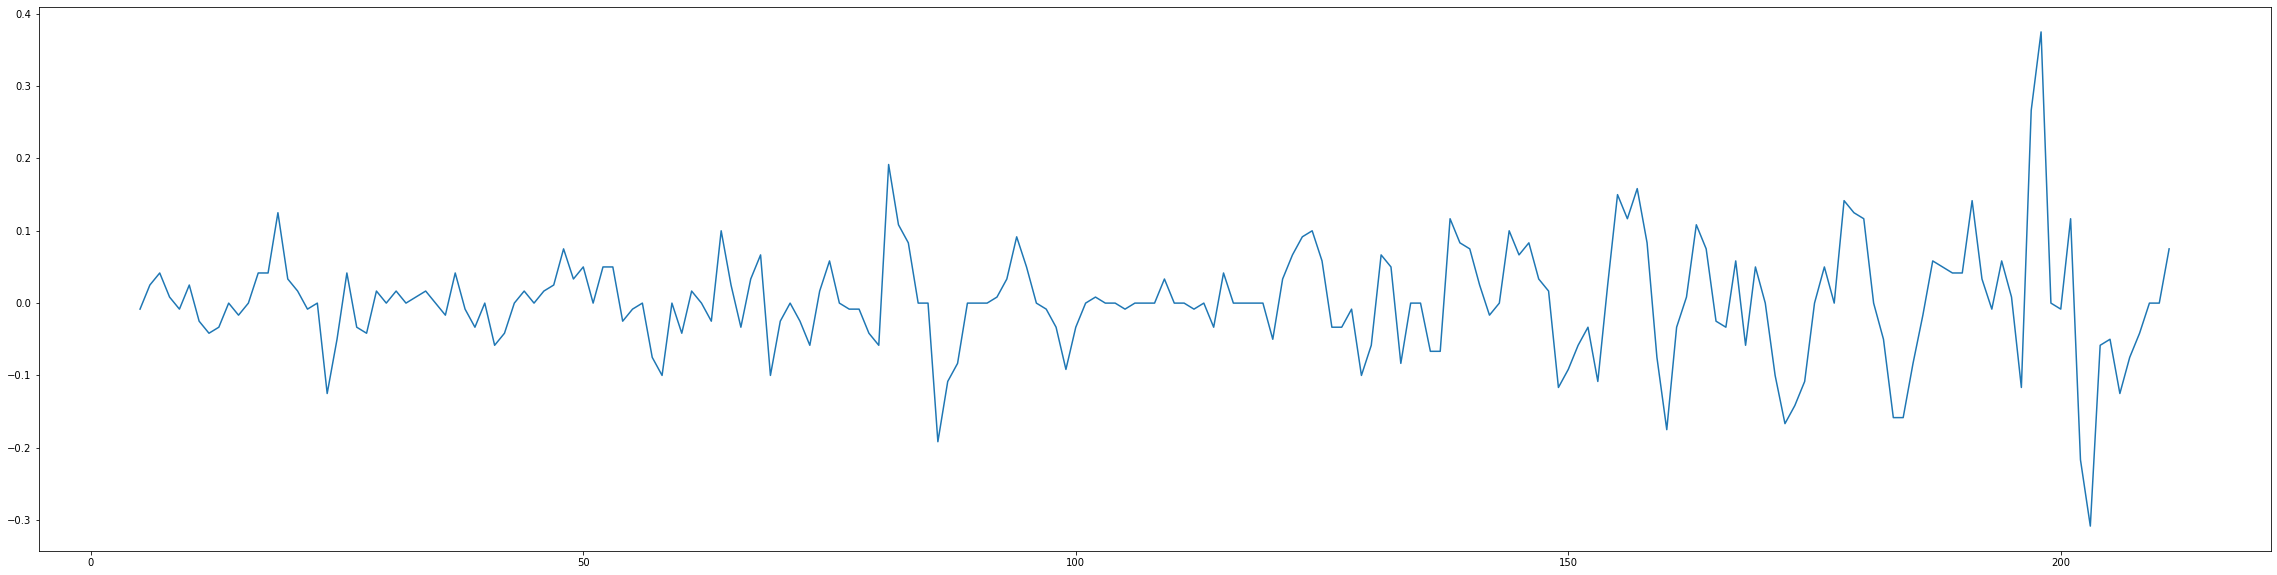

In [187]:
plt.figure(figsize=(40,10))
plt.plot(st_2017_suavizado.diff());

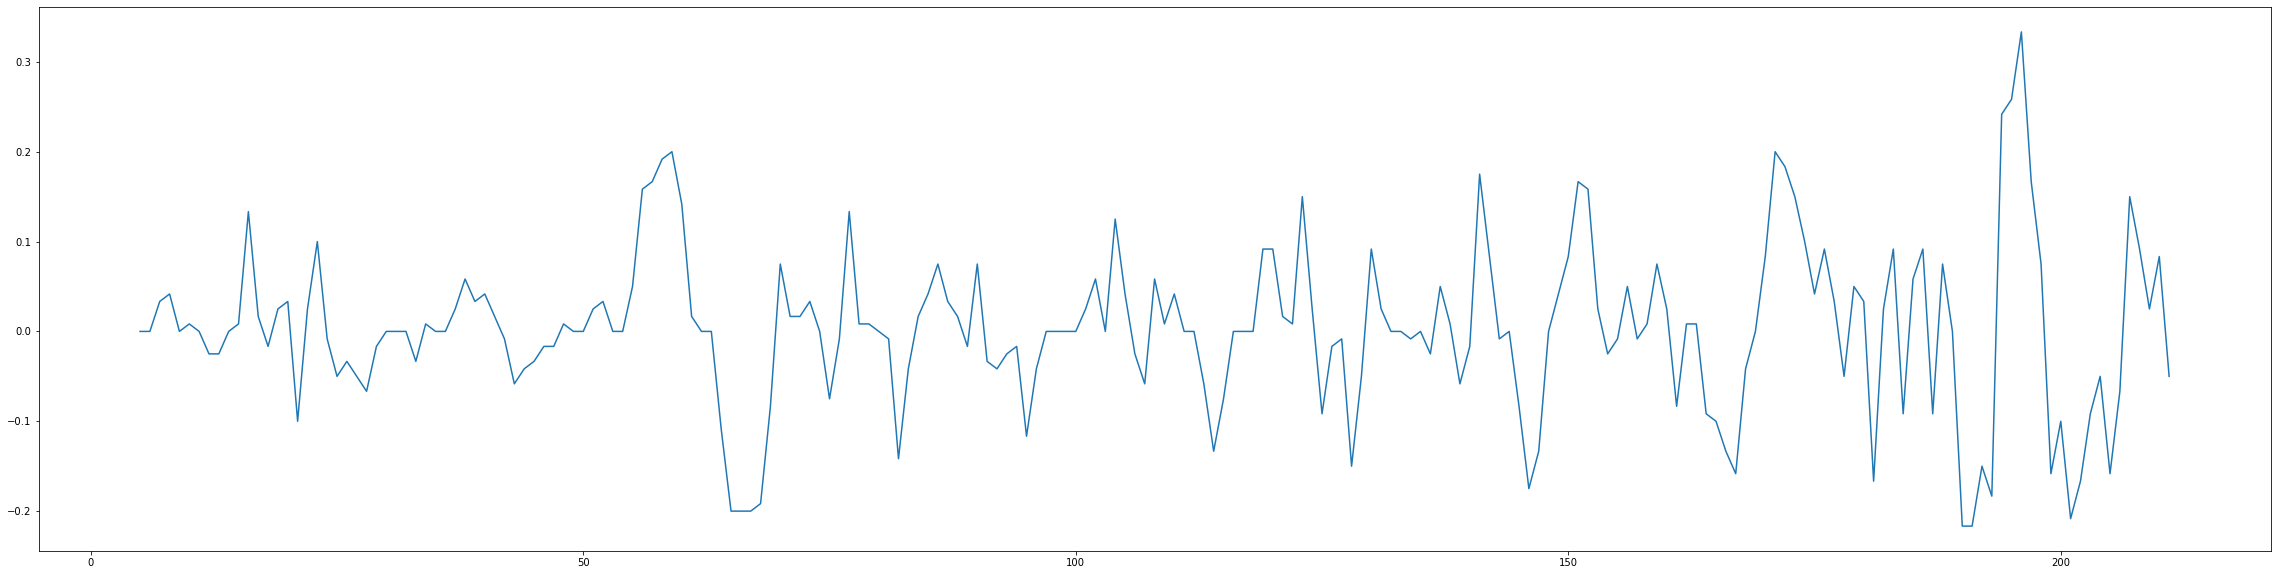

In [188]:
plt.figure(figsize=(40,10))
plt.plot(st_2018_suavizado.diff());

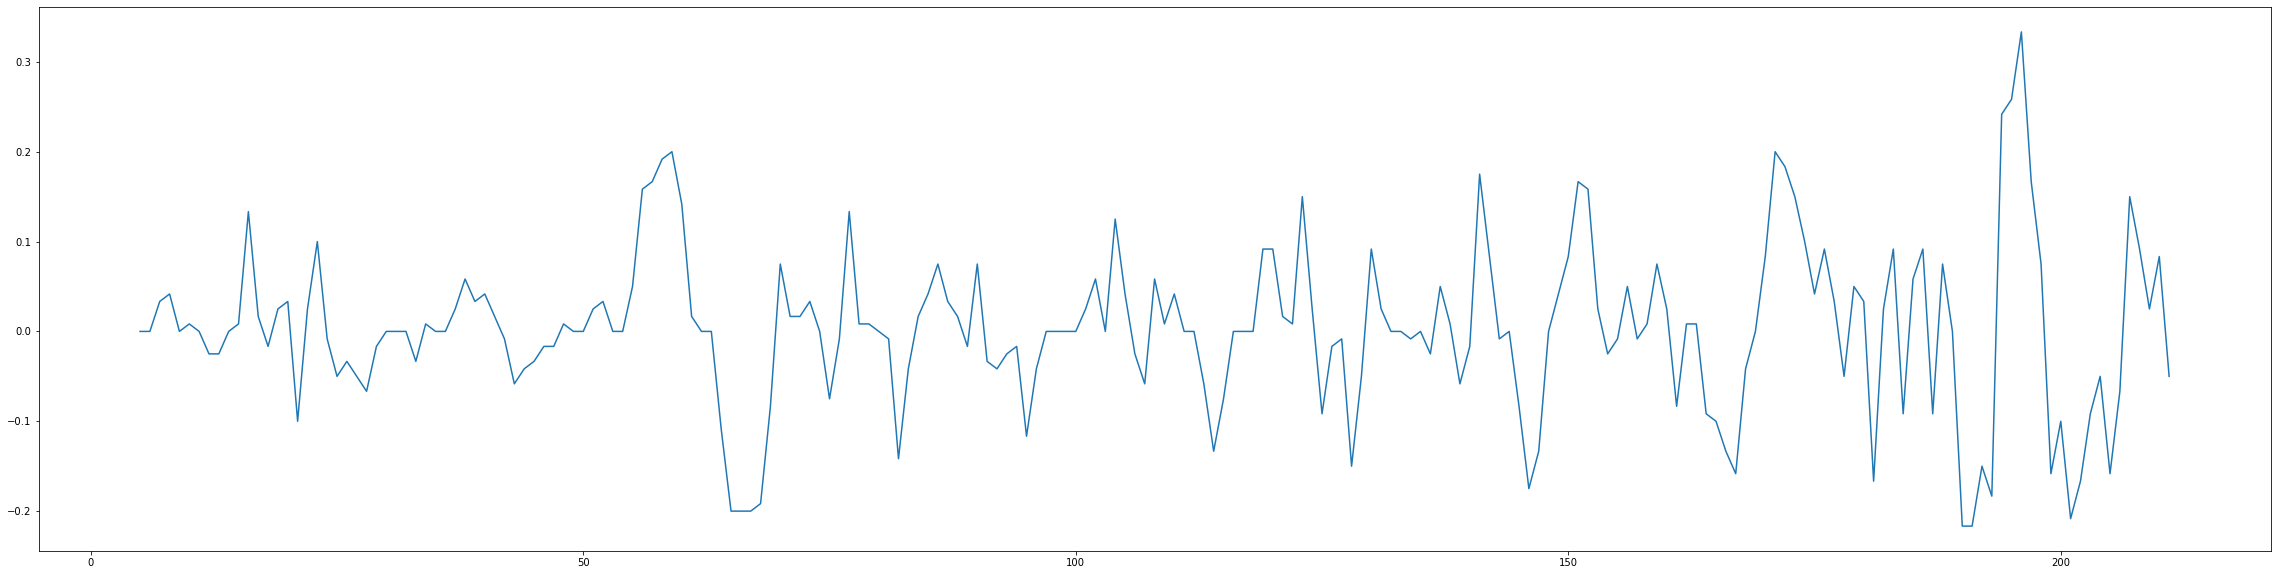

In [189]:
plt.figure(figsize=(40,10))
plt.plot(st_2019_suavizado.diff());

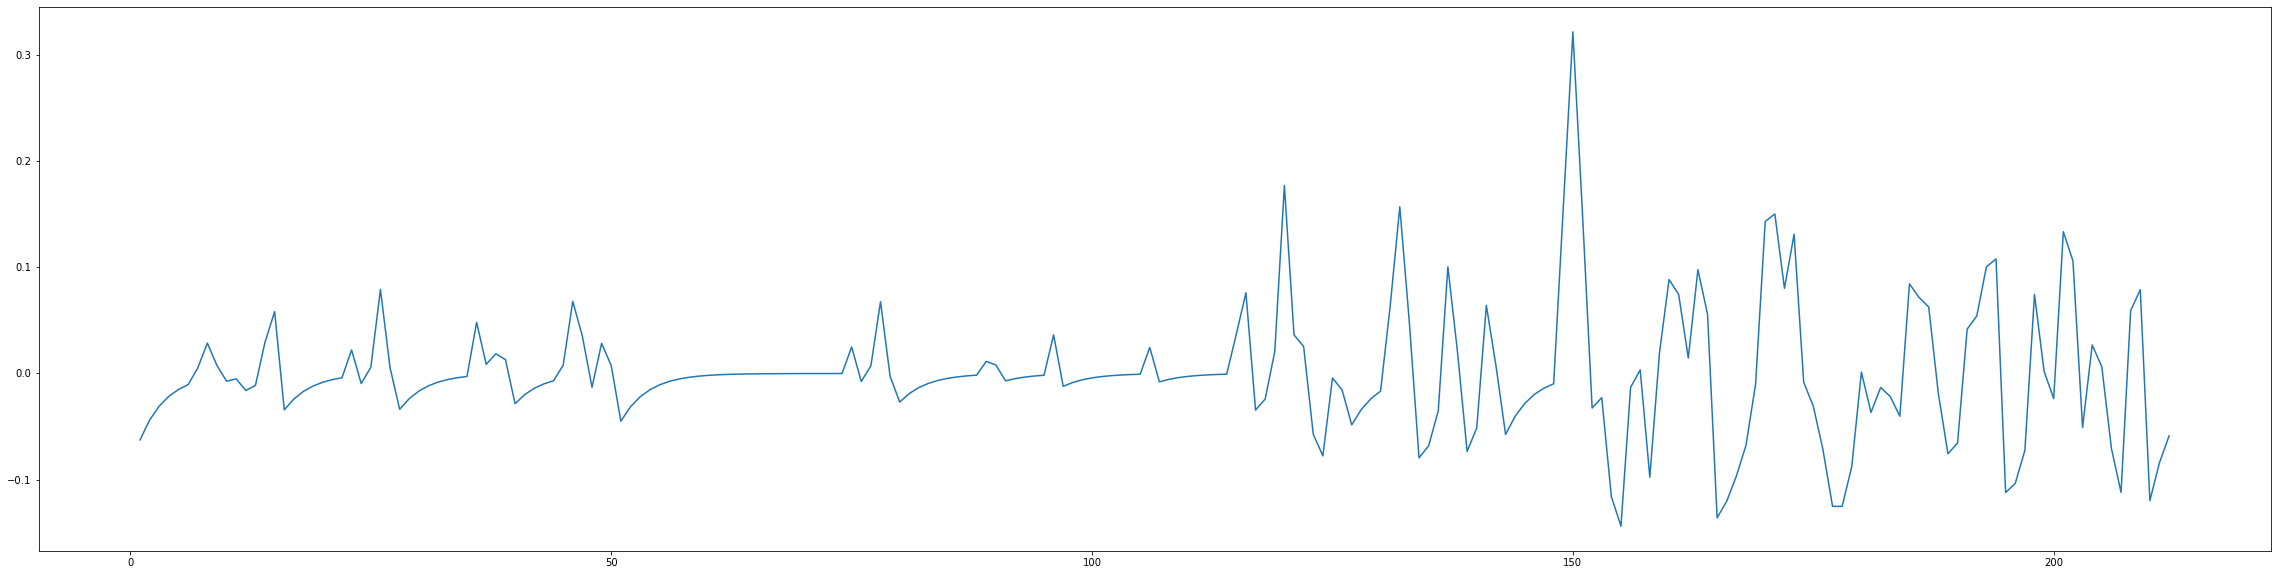

In [190]:
plt.figure(figsize=(40,10))
plt.plot(st_2020_suavizado.diff());

# Verifiacando a variação nos dados - aceleração de mundaça

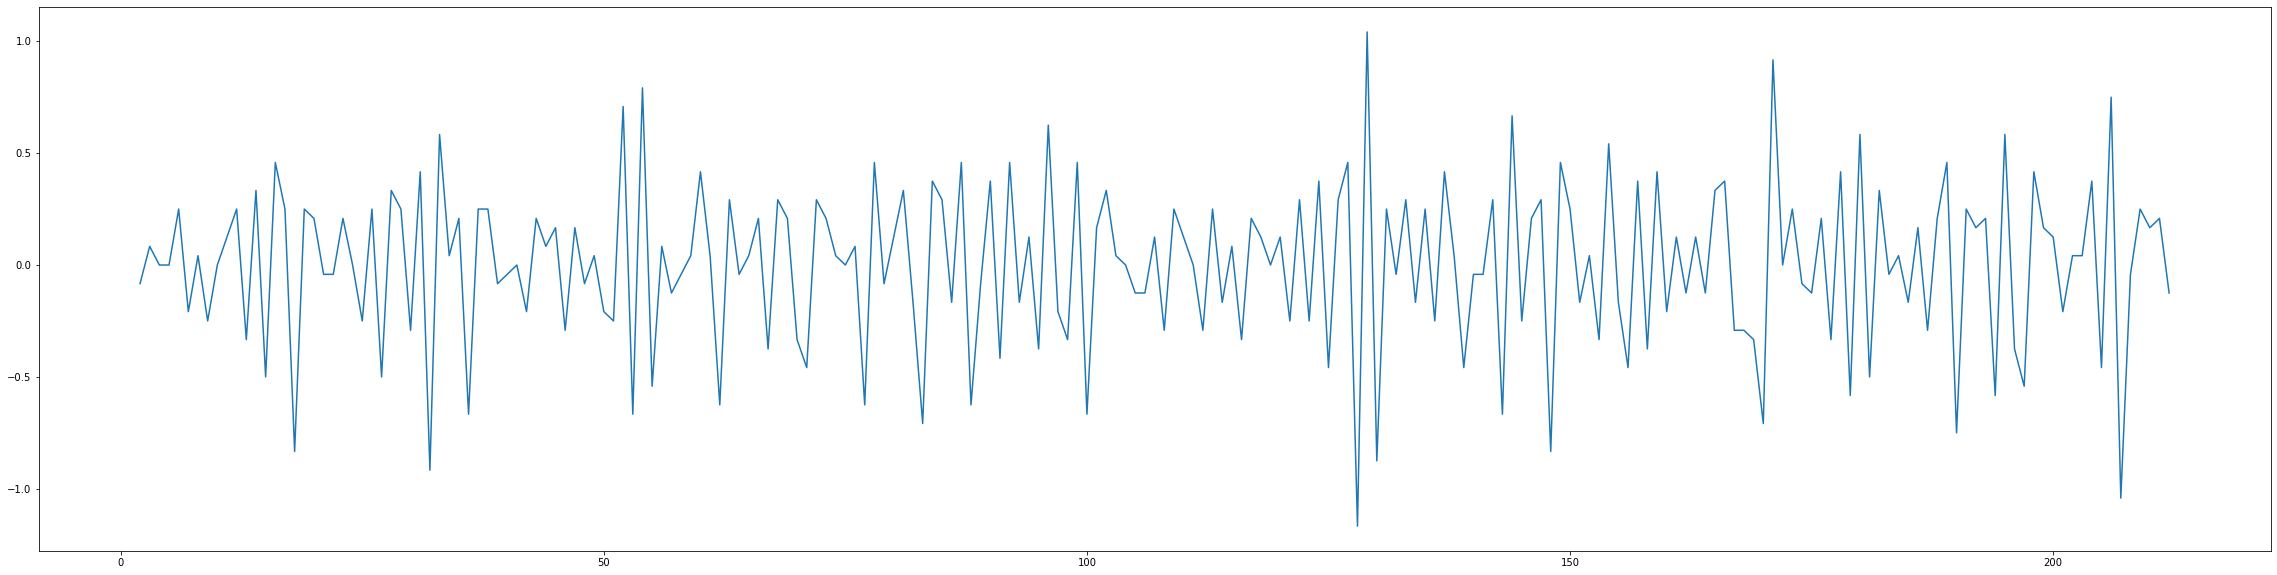

In [191]:
plt.figure(figsize=(40,10))
velocidade_2016 = dados_medios_completados_2016.diff()
plt.plot(velocidade_2016.diff());

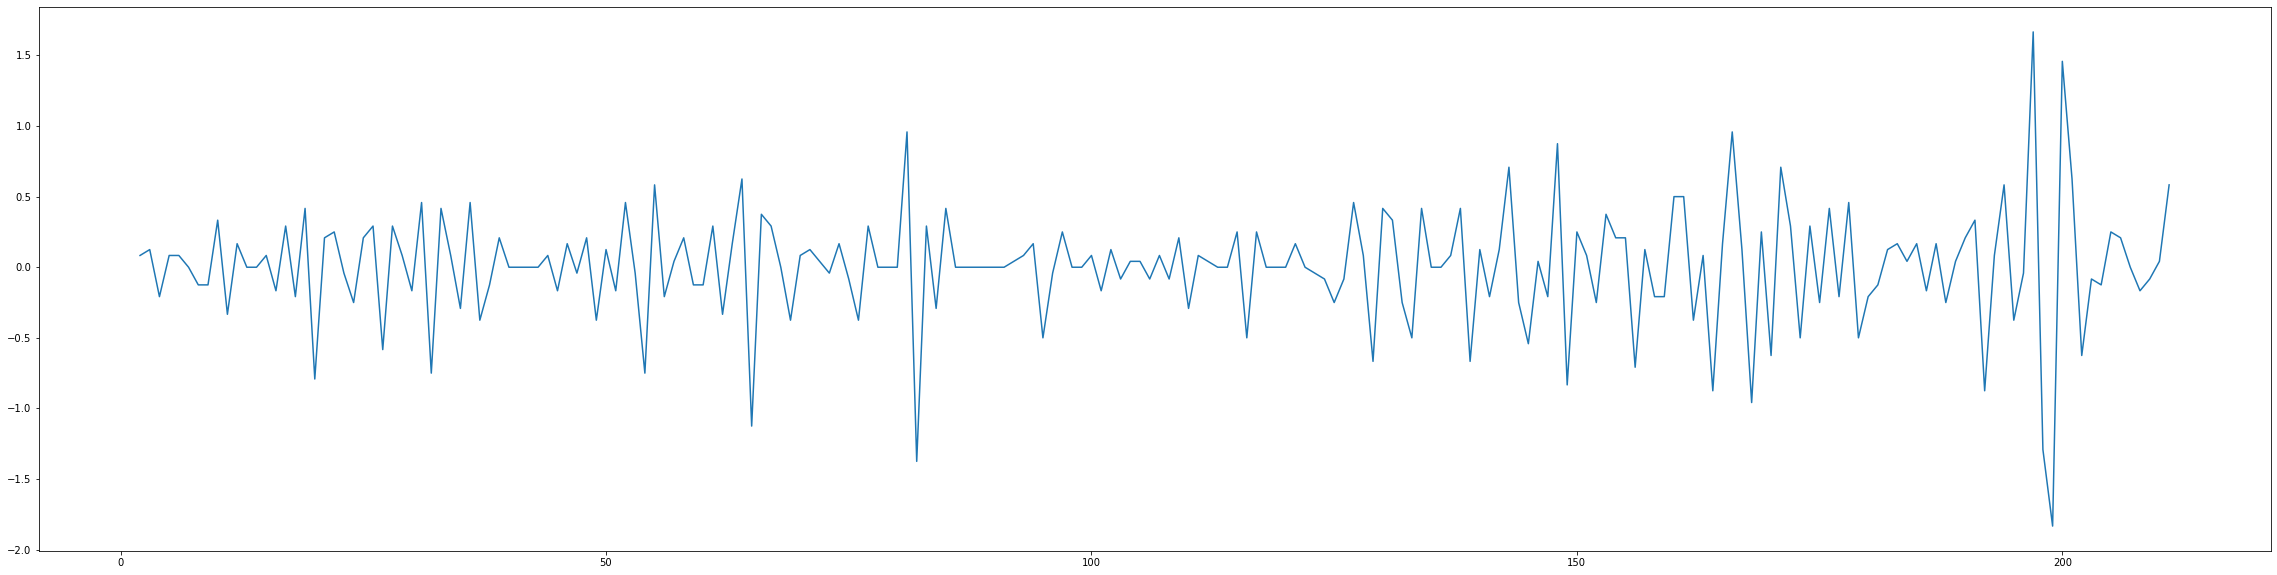

In [192]:
plt.figure(figsize=(40,10))
velocidade_2017 = dados_medios_completados_2017.diff()
plt.plot(velocidade_2017.diff());

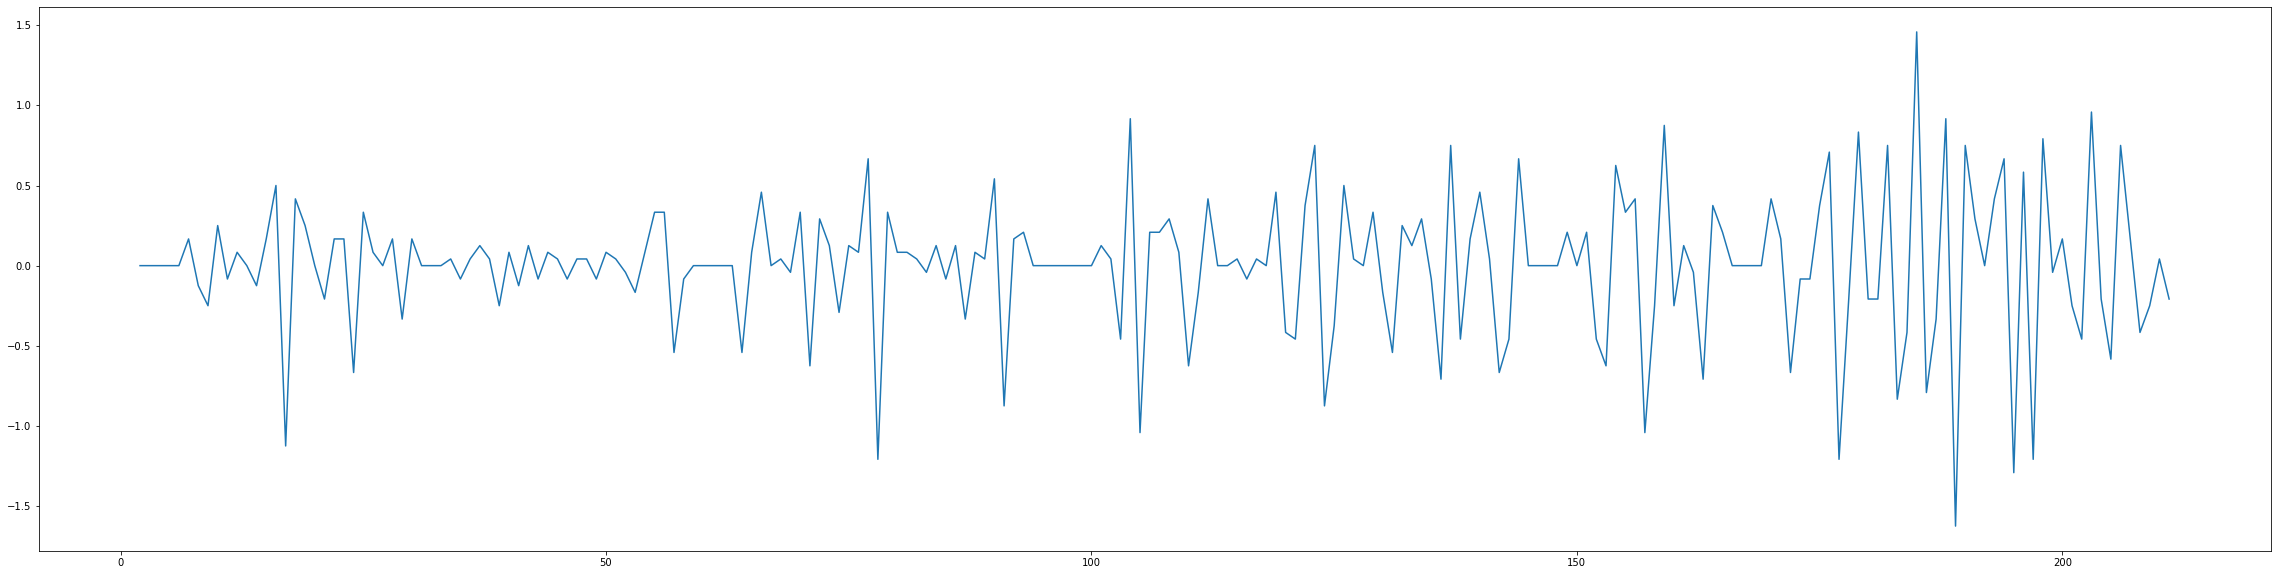

In [193]:
plt.figure(figsize=(40,10))
velocidade_2018 = dados_medios_completados_2018.diff()
plt.plot(velocidade_2018.diff());

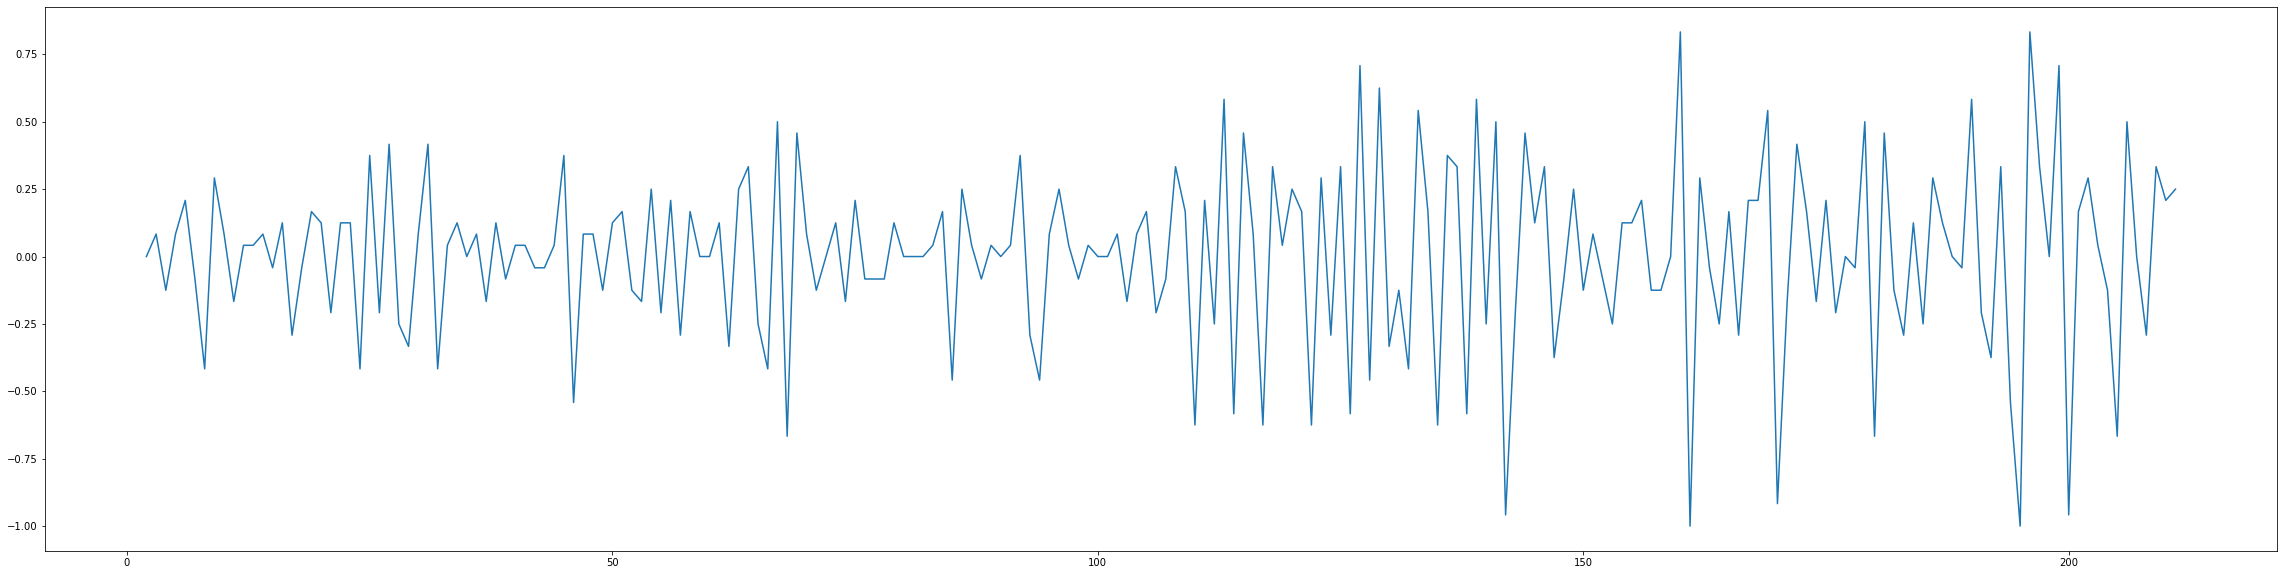

In [194]:
plt.figure(figsize=(40,10))
velocidade_2019 = dados_medios_completados_2019.diff()
plt.plot(velocidade_2019.diff());

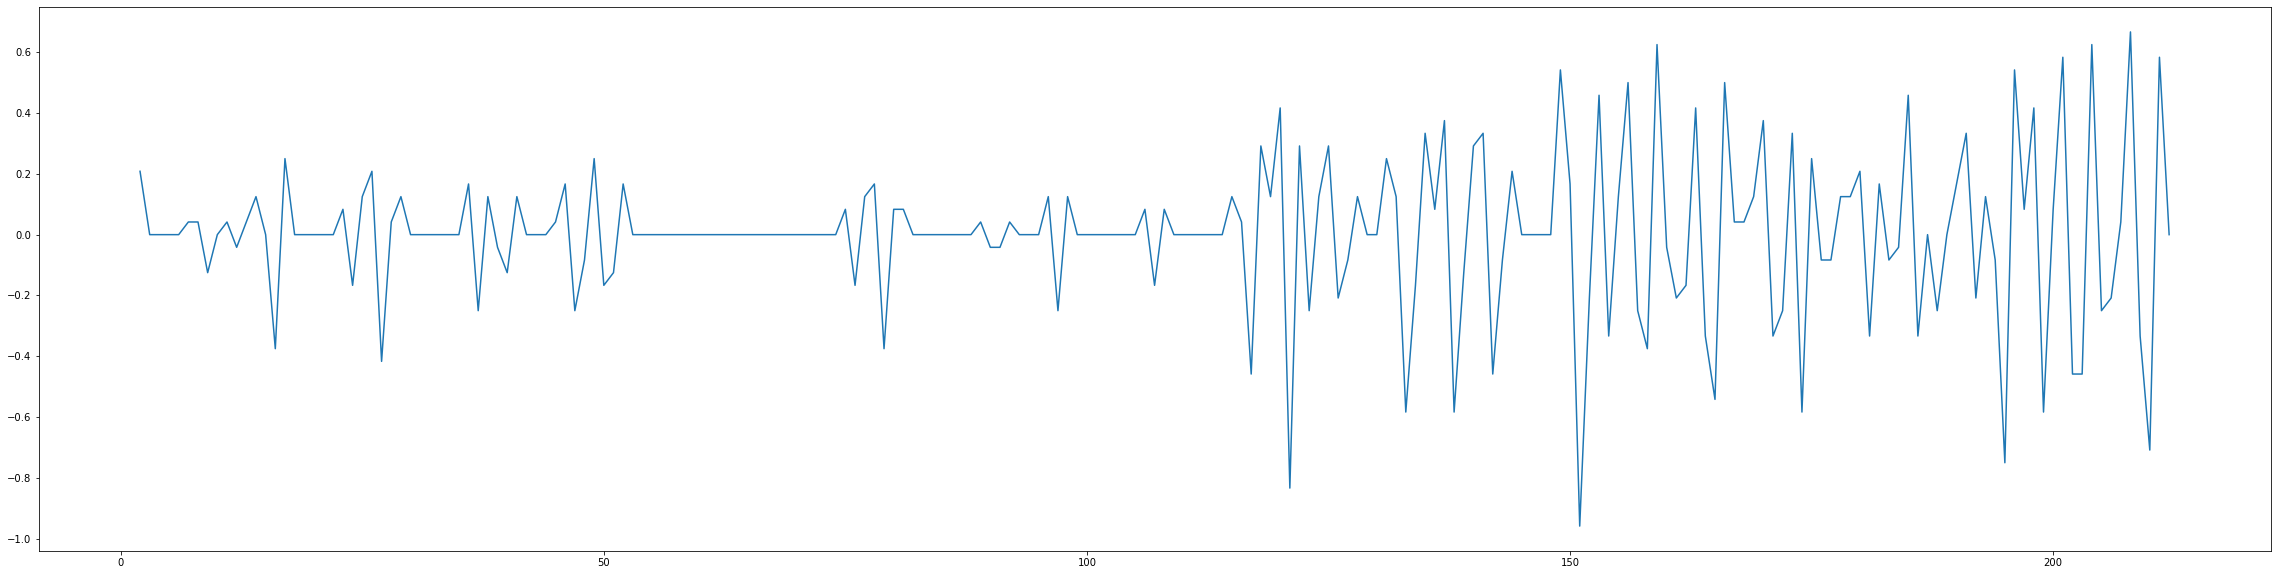

In [195]:
plt.figure(figsize=(40,10))
velocidade_2020 = dados_medios_completados_2020.diff()
plt.plot(velocidade_2020.diff());

# Autocorrelação da série

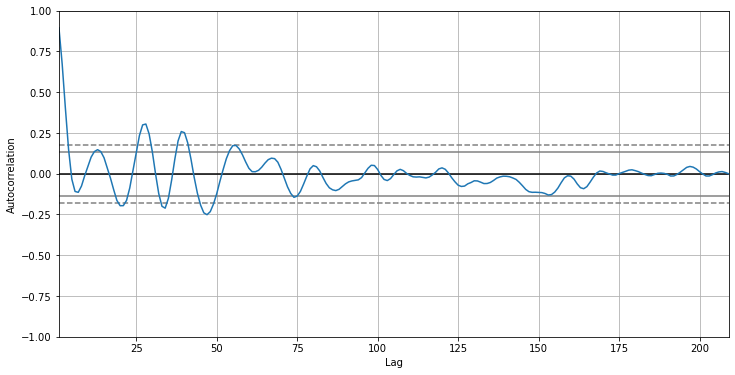

In [196]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2016_suavizado)

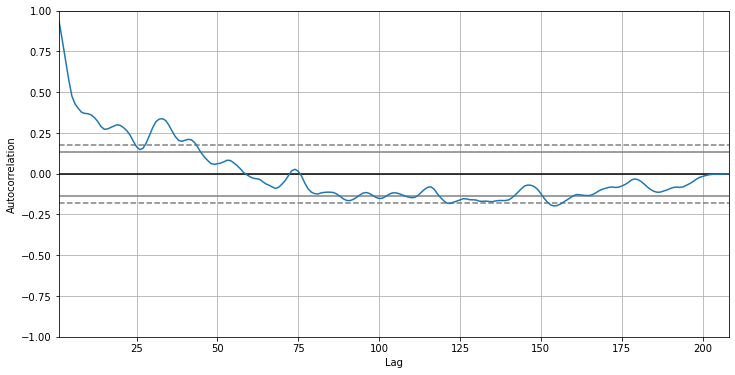

In [197]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2017_suavizado)

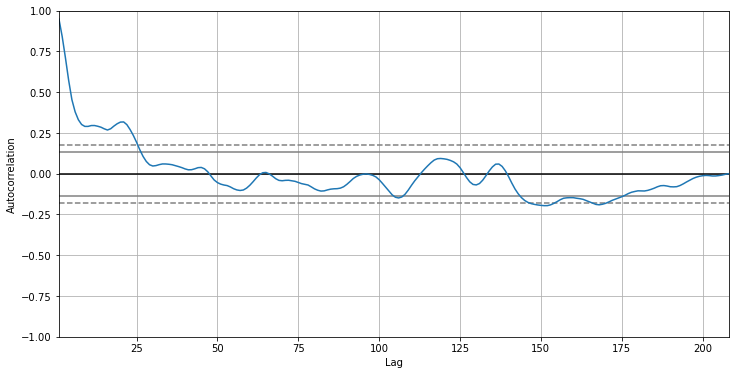

In [198]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2018_suavizado)

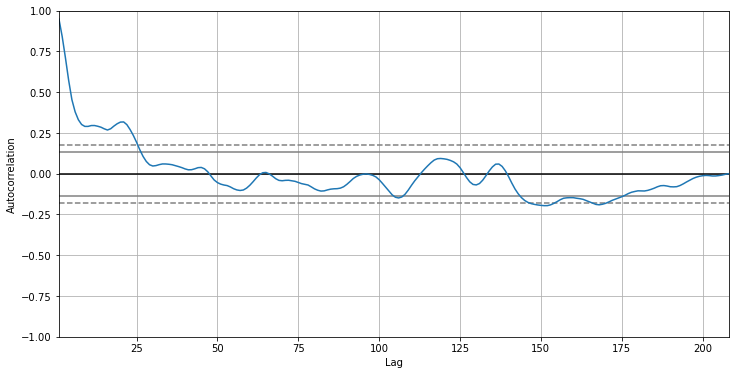

In [199]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2019_suavizado)

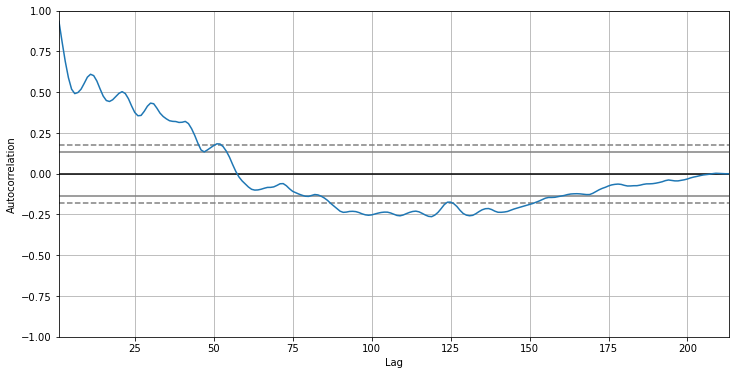

In [200]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2020_suavizado)

# Juntado a base dados suavizada

In [201]:
st_2016_suavizado.dropna(inplace=True)
st_2016_suavizado.reset_index(drop=True,inplace=True)

st_2017_suavizado.dropna(inplace=True)
st_2016_suavizado.reset_index(drop=True,inplace=True)

st_2018_suavizado.dropna(inplace=True)
st_2018_suavizado.reset_index(drop=True,inplace=True)
st_2019_suavizado.dropna(inplace=True)
st_2019_suavizado.reset_index(drop=True,inplace=True)

st_2020_suavizado.dropna(inplace=True)
st_2020_suavizado.reset_index(drop=True,inplace=True)

serie_completa_suavizada = pd.concat([st_2017_suavizado,st_2018_suavizado,st_2019_suavizado,st_2020_suavizado])
serie_completa_suavizada.reset_index(drop=True, inplace=True)
serie_completa_suavizada

0
0    0.050000
1    0.041667
2    0.066667
3    0.108333
4    0.116667
..        ...
832  0.320260
833  0.399182
834  0.279427
835  0.195599
836  0.136919

[837 rows x 1 columns]

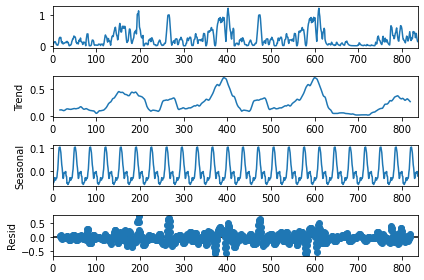

In [202]:
resultado_st = seasonal_decompose(serie_completa_suavizada,period=35)
resultado_st.plot();

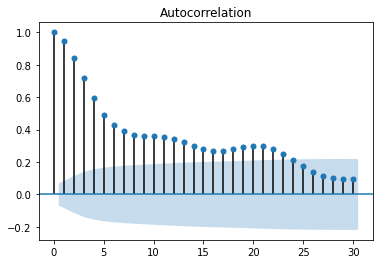

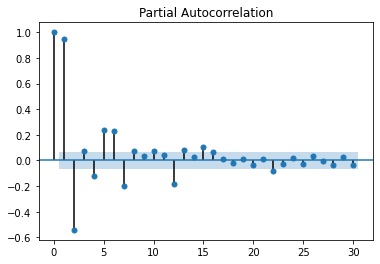

In [203]:
plot_acf(serie_completa_suavizada);
plot_pacf(serie_completa_suavizada);

# Verificando a velocidade de mundaça

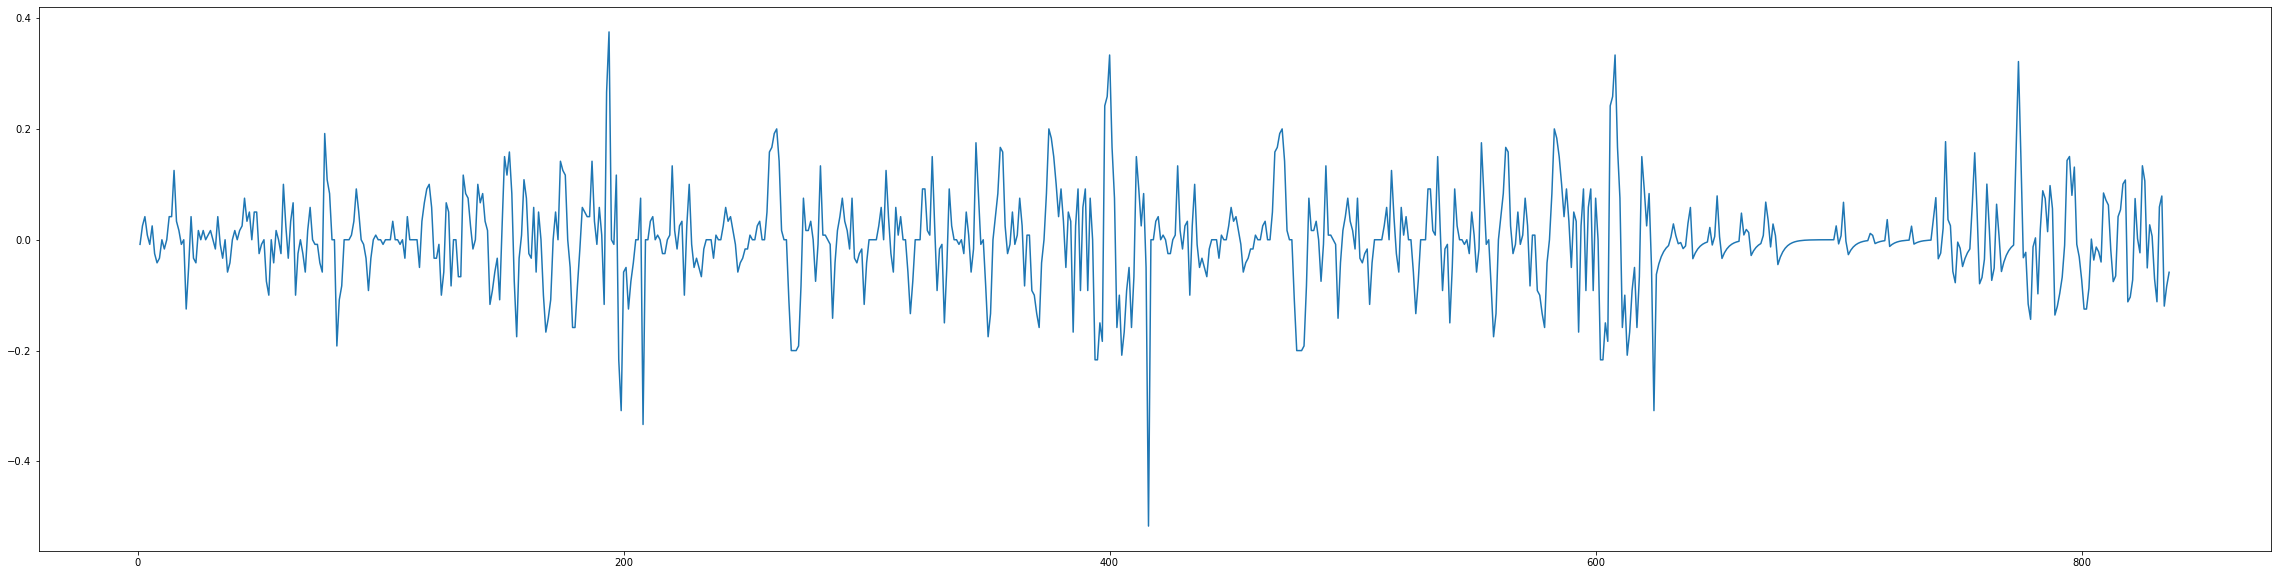

In [204]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_suavizada.diff());

# Verificando a aceleração de mundaça

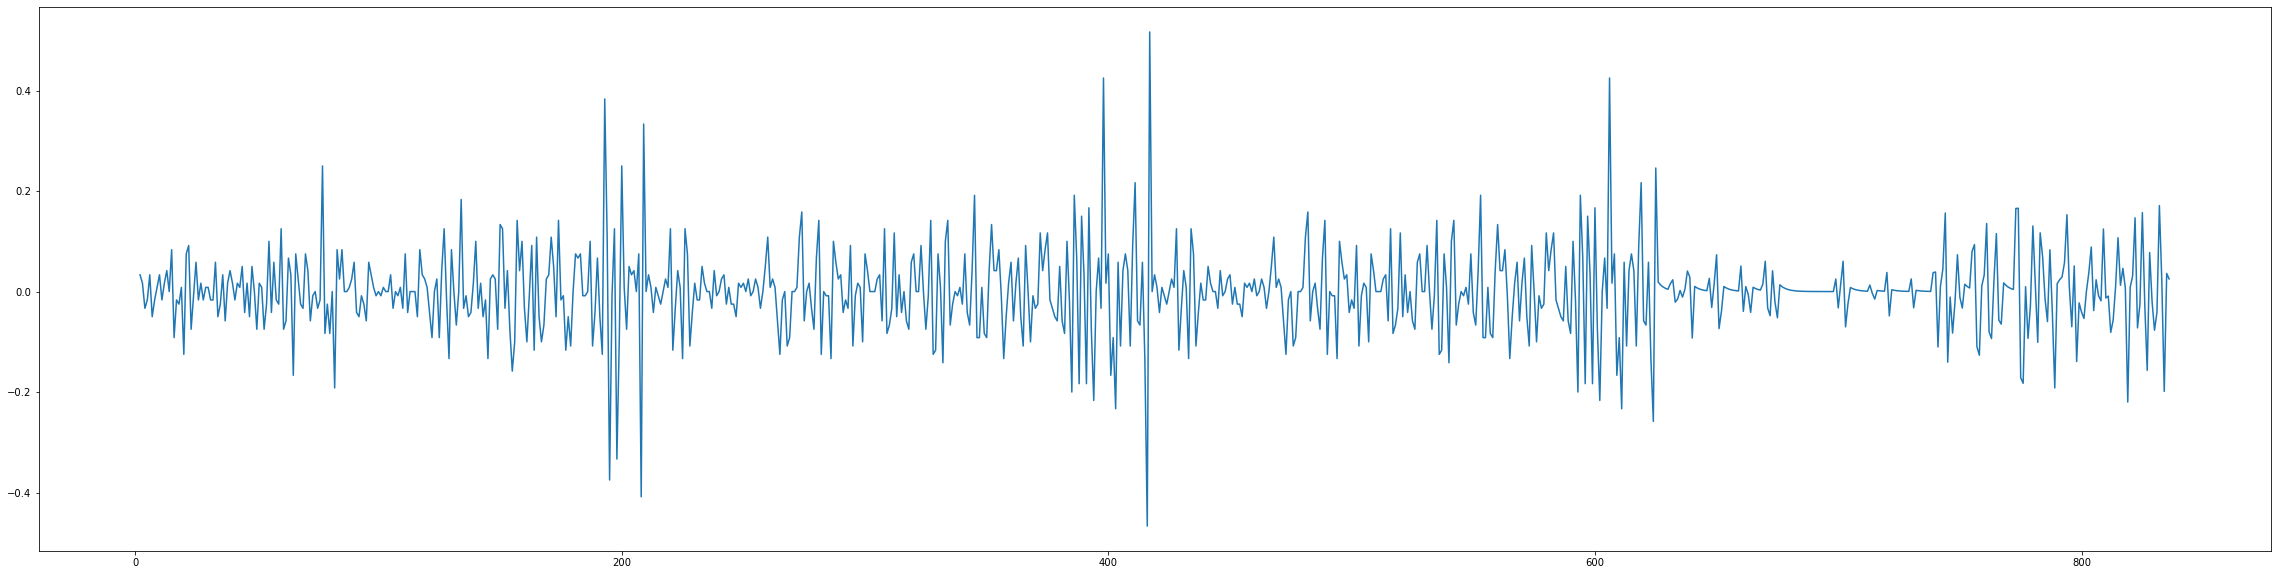

In [205]:
plt.figure(figsize=(40,10))
velocidade = serie_completa_suavizada.diff()
plt.plot(velocidade.diff());

# Jutando dados de 2016 a 2019

In [206]:
serie_completa_suavizada = pd.concat([st_2016_suavizado,st_2017_suavizado,st_2018_suavizado,st_2019_suavizado])
serie_completa_suavizada.reset_index(drop=True, inplace=True)
serie_completa_suavizada

0      0.033333
1      0.016667
2      0.050000
3      0.108333
4      0.183333
         ...   
828    0.366667
829    0.458333
830    0.483333
831    0.566667
832    0.516667
Name: 0, Length: 833, dtype: float64

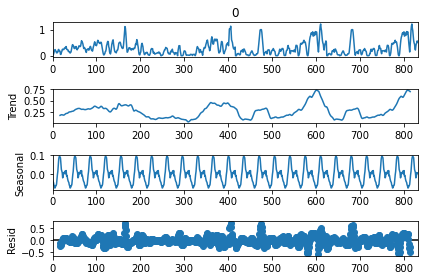

In [207]:
resultado_st = seasonal_decompose(serie_completa_suavizada,period=35)
resultado_st.plot();

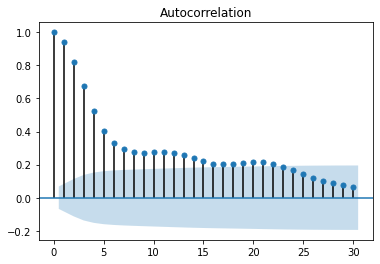

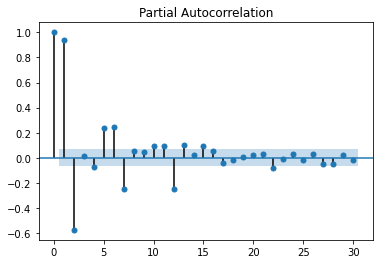

In [208]:
plot_acf(serie_completa_suavizada);
plot_pacf(serie_completa_suavizada);

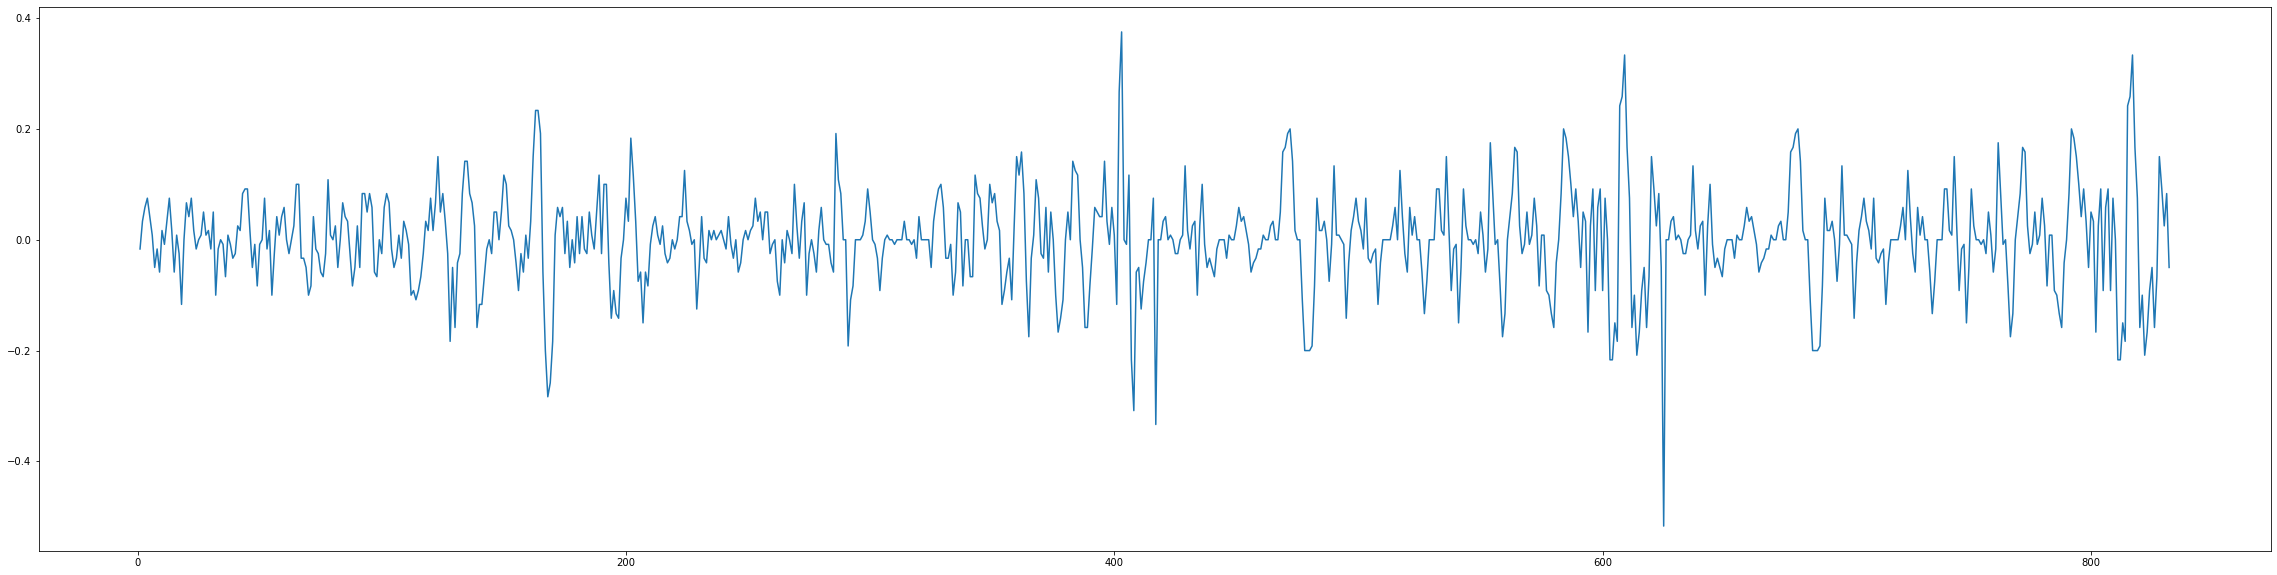

In [209]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_suavizada.diff());

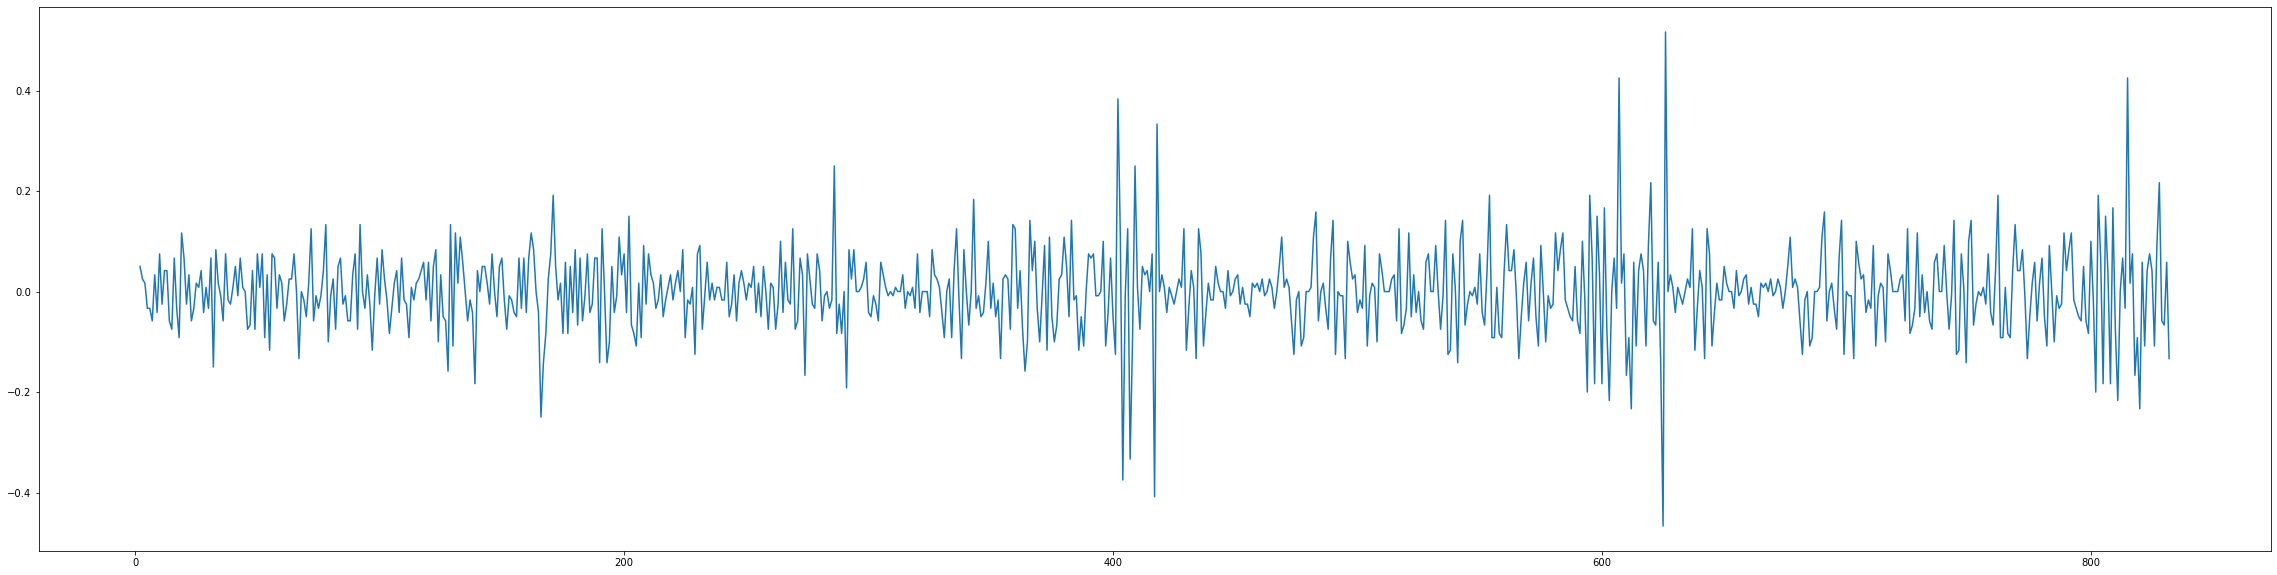

In [210]:
plt.figure(figsize=(40,10))
velocidade = serie_completa_suavizada.diff()
plt.plot(velocidade.diff());

# Analisando por mês a série

In [211]:
dados_mensais_medios_2016 = pd.DataFrame({'Dados mensais':[]})
dados_mensais_medios_2017 = pd.DataFrame({'Dados mensais':[]})
dados_mensais_medios_2018 = pd.DataFrame({'Dados mensais':[]})
dados_mensais_medios_2019 = pd.DataFrame({'Dados mensais':[]})
dados_mensais_medios_2020 = pd.DataFrame({'Dados mensais':[]})

for i in range(7):
    aux = i*30
    dados_mensais_medios_2016 = dados_mensais_medios_2016.append({'Dados mensais':dados_medios_completados_2016[aux:(i+1)*30].mean()},ignore_index=True)
    dados_mensais_medios_2017 = dados_mensais_medios_2017.append({'Dados mensais':dados_medios_completados_2017[aux:(i+1)*30].mean()},ignore_index=True)
    dados_mensais_medios_2018 = dados_mensais_medios_2018.append({'Dados mensais':dados_medios_completados_2018[aux:(i+1)*30].mean()},ignore_index=True)
    dados_mensais_medios_2019 = dados_mensais_medios_2019.append({'Dados mensais':dados_medios_completados_2019[aux:(i+1)*30].mean()},ignore_index=True)
    dados_mensais_medios_2020 = dados_mensais_medios_2020.append({'Dados mensais':dados_medios_completados_2020[aux:(i+1)*30].mean()},ignore_index=True)

In [212]:
messes = pd.DataFrame({'Mes/ano':[]})
for j in ['2016','2017','2018','2019']:
    for i in ['jan','fev','mar','abr','mai','jun','jul']:
        messes = messes.append({"Mes/ano":j+'/'+i},ignore_index=True)
messes

Mes/ano
0   2016/jan
1   2016/fev
2   2016/mar
3   2016/abr
4   2016/mai
5   2016/jun
6   2016/jul
7   2017/jan
8   2017/fev
9   2017/mar
10  2017/abr
11  2017/mai
12  2017/jun
13  2017/jul
14  2018/jan
15  2018/fev
16  2018/mar
17  2018/abr
18  2018/mai
19  2018/jun
20  2018/jul
21  2019/jan
22  2019/fev
23  2019/mar
24  2019/abr
25  2019/mai
26  2019/jun
27  2019/jul

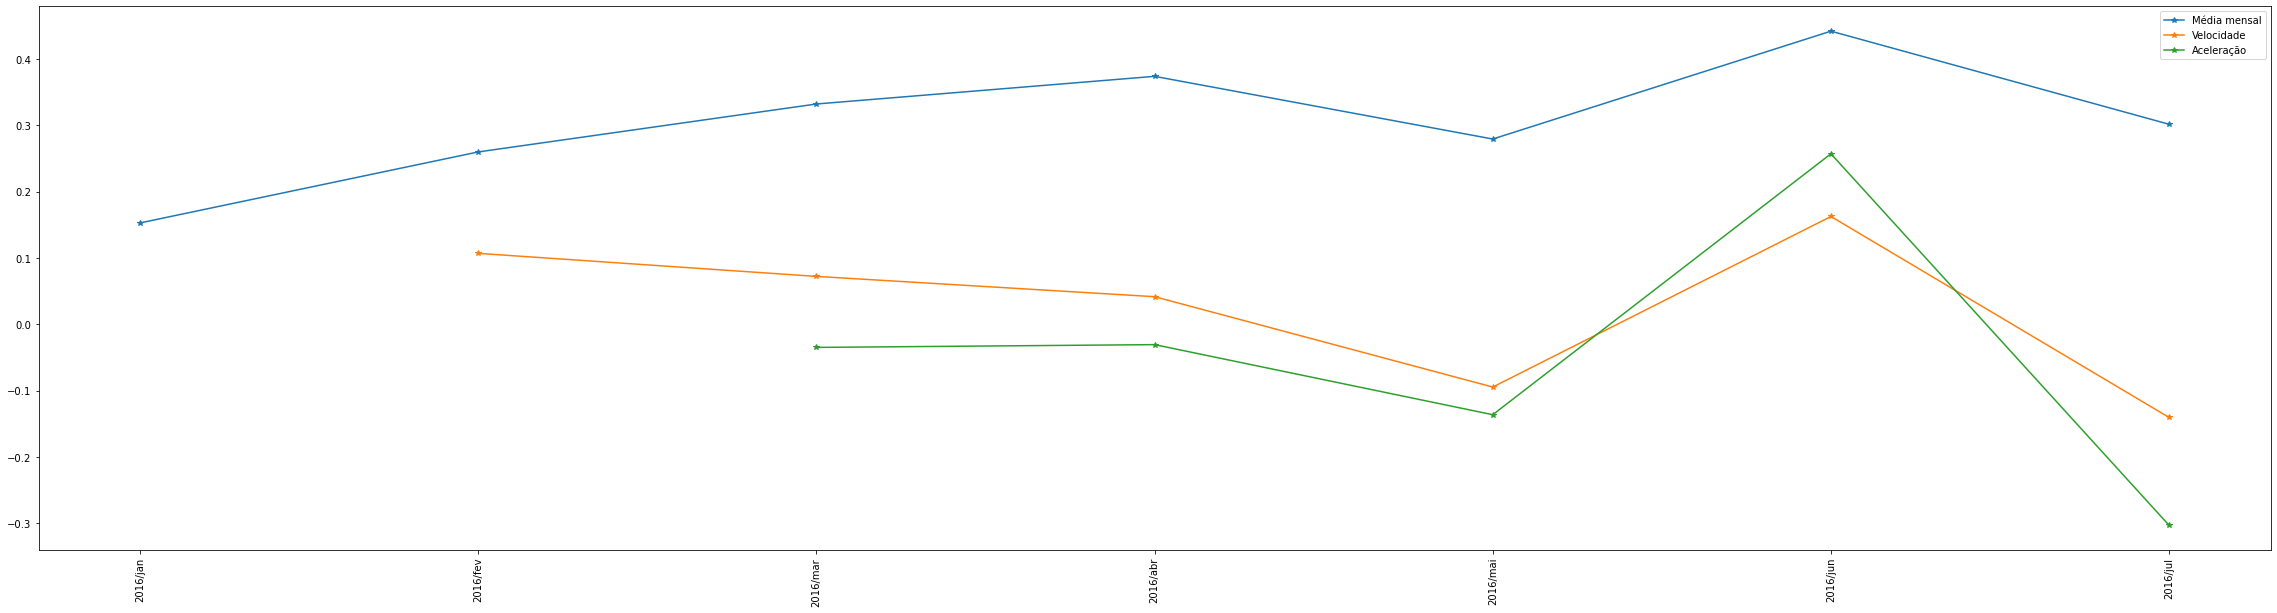

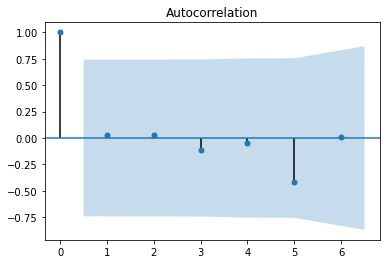

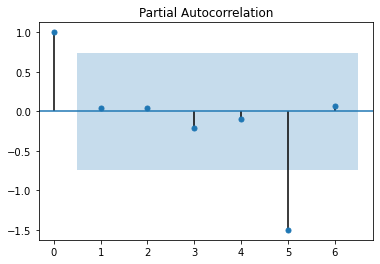

In [213]:
plt.figure(figsize=(40,10))
plt.plot(dados_mensais_medios_2016,'*-',label='Média mensal')
plt.plot(dados_mensais_medios_2016.diff(),'*-',label='Velocidade')
plt.plot(dados_mensais_medios_2016.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(dados_mensais_medios_2016.shape[0])],[i[0] for i in messes.values],rotation=90)
plt.legend(loc='best')
plot_acf(dados_mensais_medios_2016);
plot_pacf(dados_mensais_medios_2016);
plt.show()

In [214]:
messes = pd.DataFrame({'Mes/ano':[]})
for j in ['2017','2018','2019','2020']:
    for i in ['jan','fev','mar','abr','mai','jun','jul']:
        messes = messes.append({"Mes/ano":j+'/'+i},ignore_index=True)

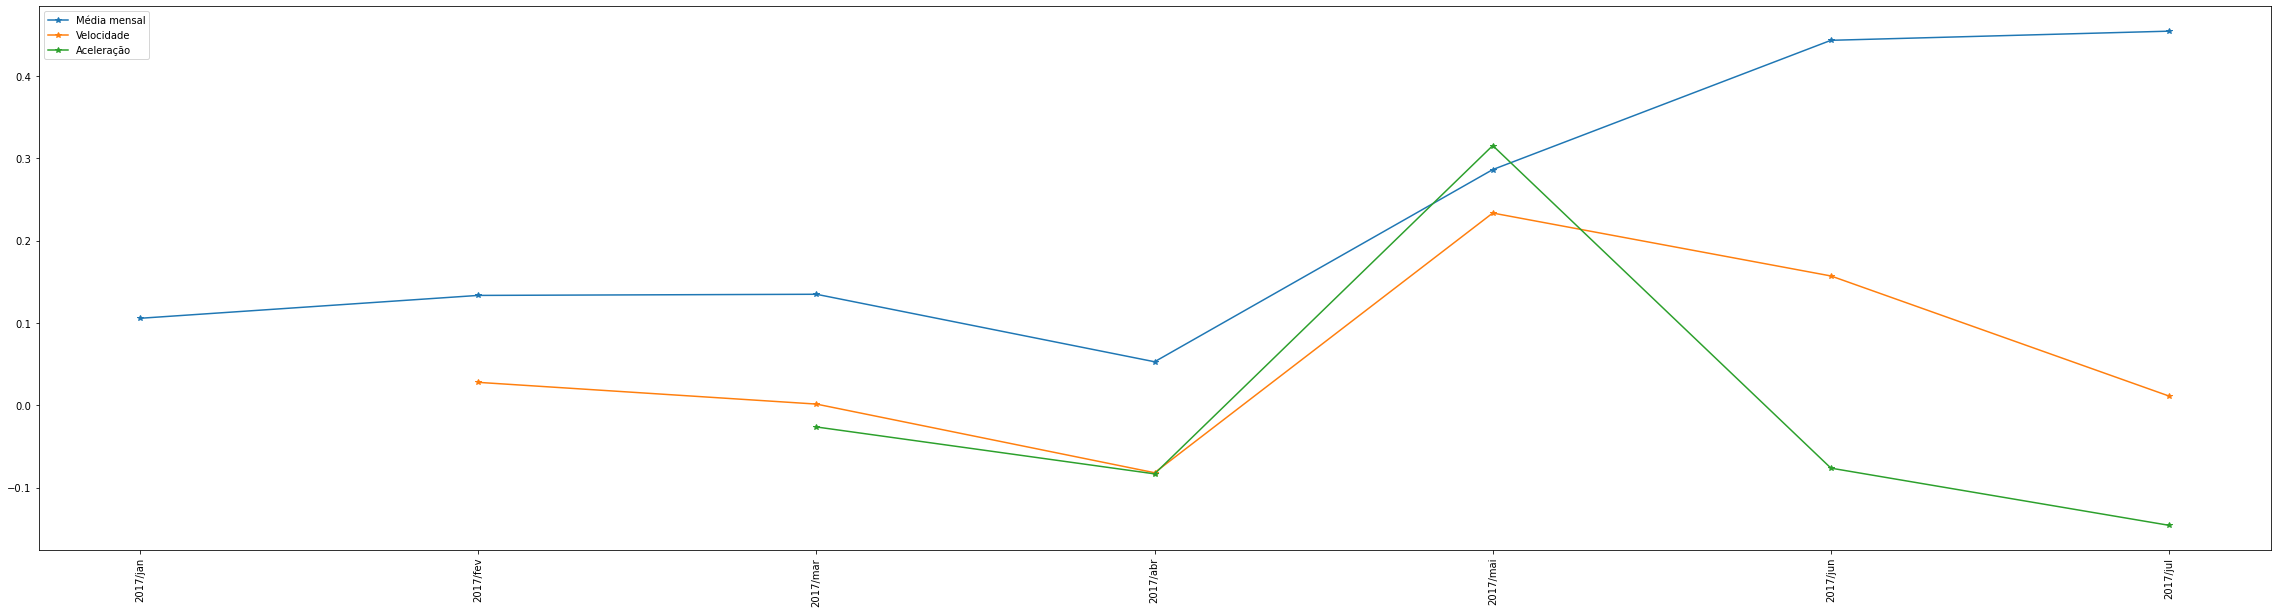

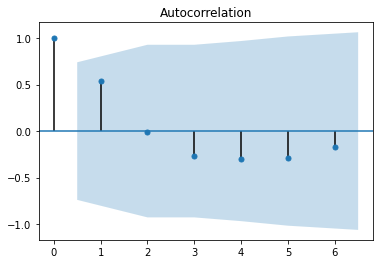

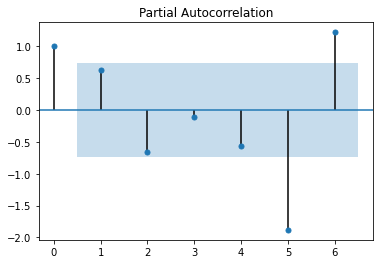

In [215]:
plt.figure(figsize=(40,10))
plt.plot(dados_mensais_medios_2017,'*-',label='Média mensal')
plt.plot(dados_mensais_medios_2017.diff(),'*-',label='Velocidade')
plt.plot(dados_mensais_medios_2017.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(dados_mensais_medios_2017.shape[0])],[i[0] for i in messes.values],rotation=90)
plt.legend(loc='best')
plot_acf(dados_mensais_medios_2017);
plot_pacf(dados_mensais_medios_2017);
plt.show()

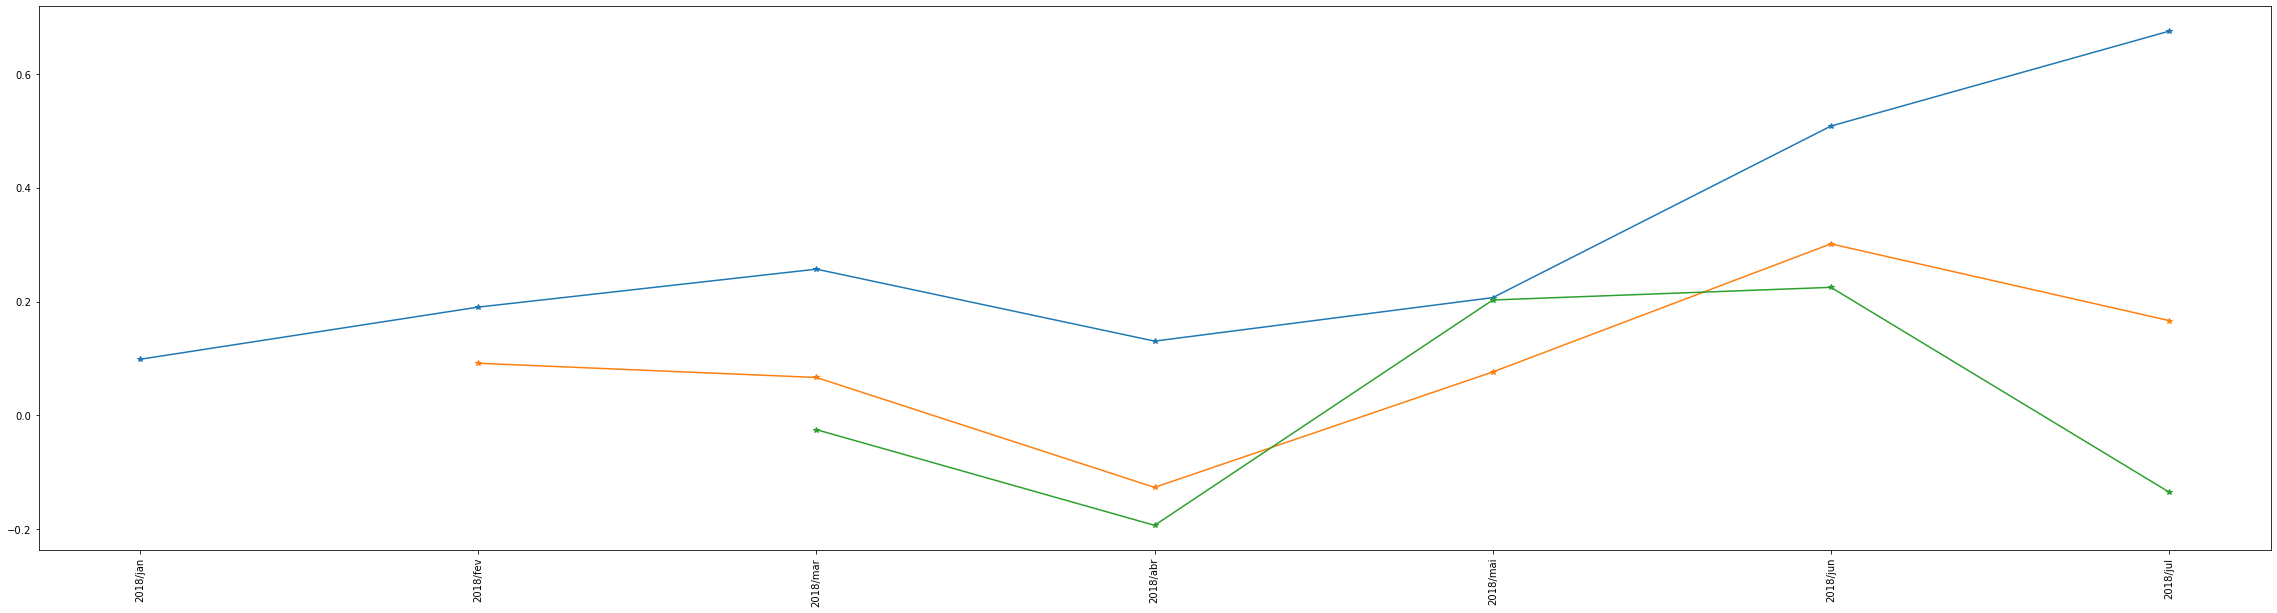

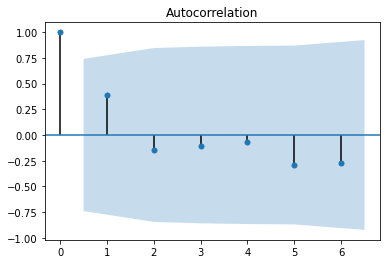

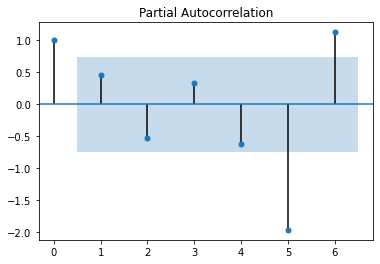

In [216]:
plt.figure(figsize=(40,10))
plt.plot(dados_mensais_medios_2018,'*-')
plt.plot(dados_mensais_medios_2018.diff(),'*-')
plt.plot(dados_mensais_medios_2018.diff().diff(),'*-')
plt.xticks([i for i in range(dados_mensais_medios_2018.shape[0])],[i[0] for i in messes[7:14].values],rotation=90)
plot_acf(dados_mensais_medios_2018);
plot_pacf(dados_mensais_medios_2018);
plt.show()

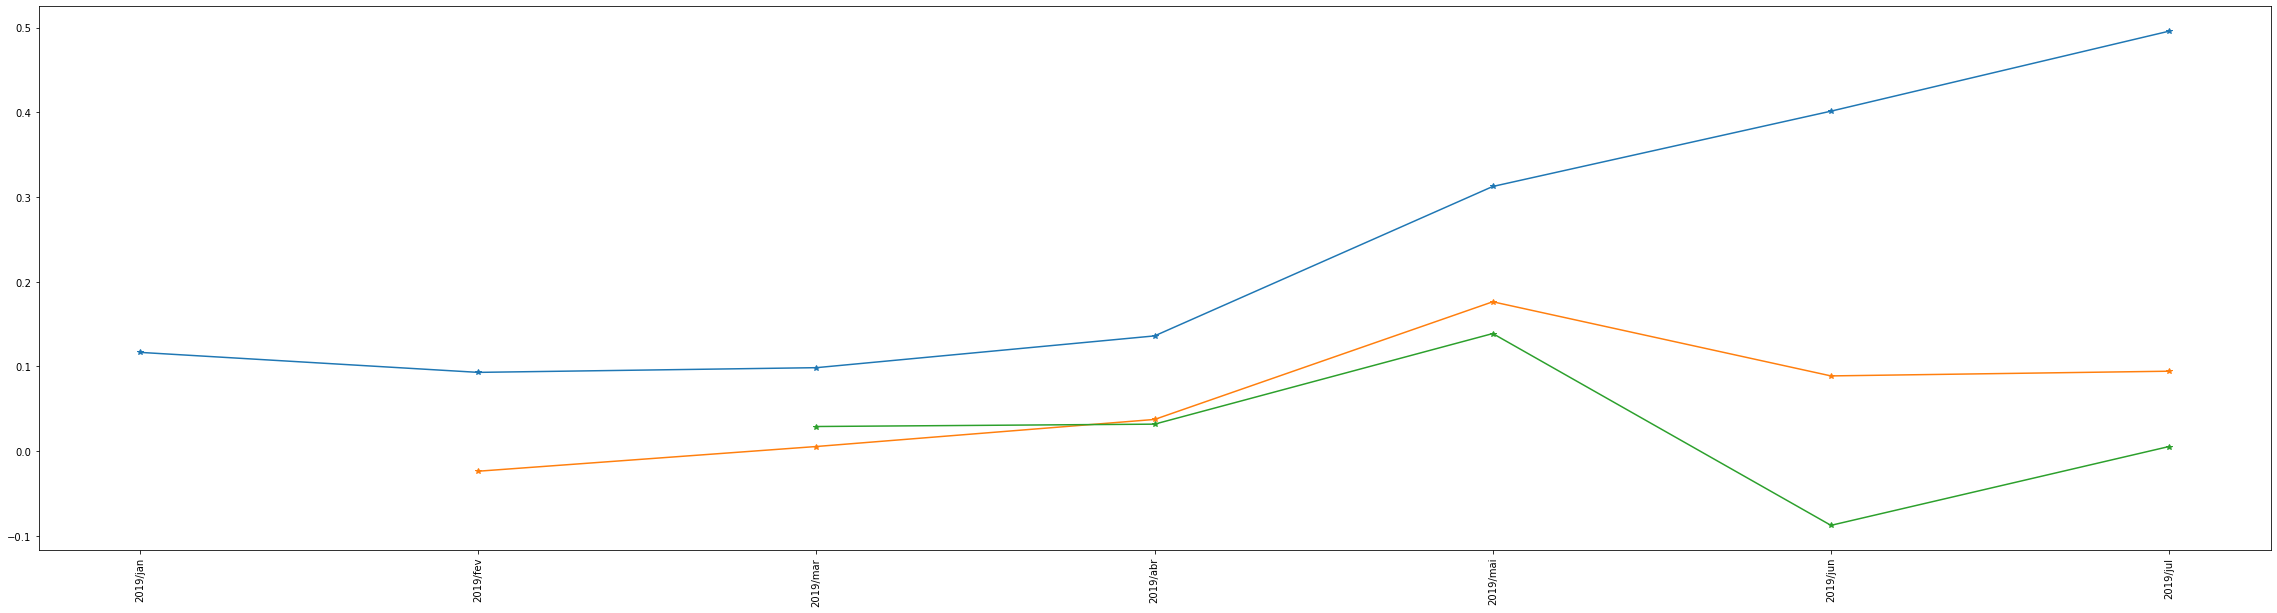

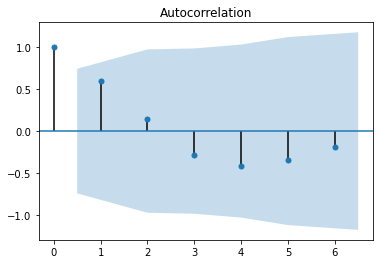

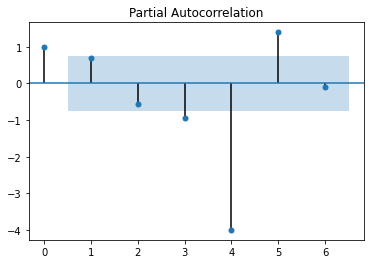

In [217]:
plt.figure(figsize=(40,10))
plt.plot(dados_mensais_medios_2019,'*-',label='Média mensal')
plt.plot(dados_mensais_medios_2019.diff(),'*-',label='Velocidade')
plt.plot(dados_mensais_medios_2019.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(dados_mensais_medios_2018.shape[0])],[i[0] for i in messes[14:21].values],rotation=90)
plot_acf(dados_mensais_medios_2019);
plot_pacf(dados_mensais_medios_2019);
plt.show()

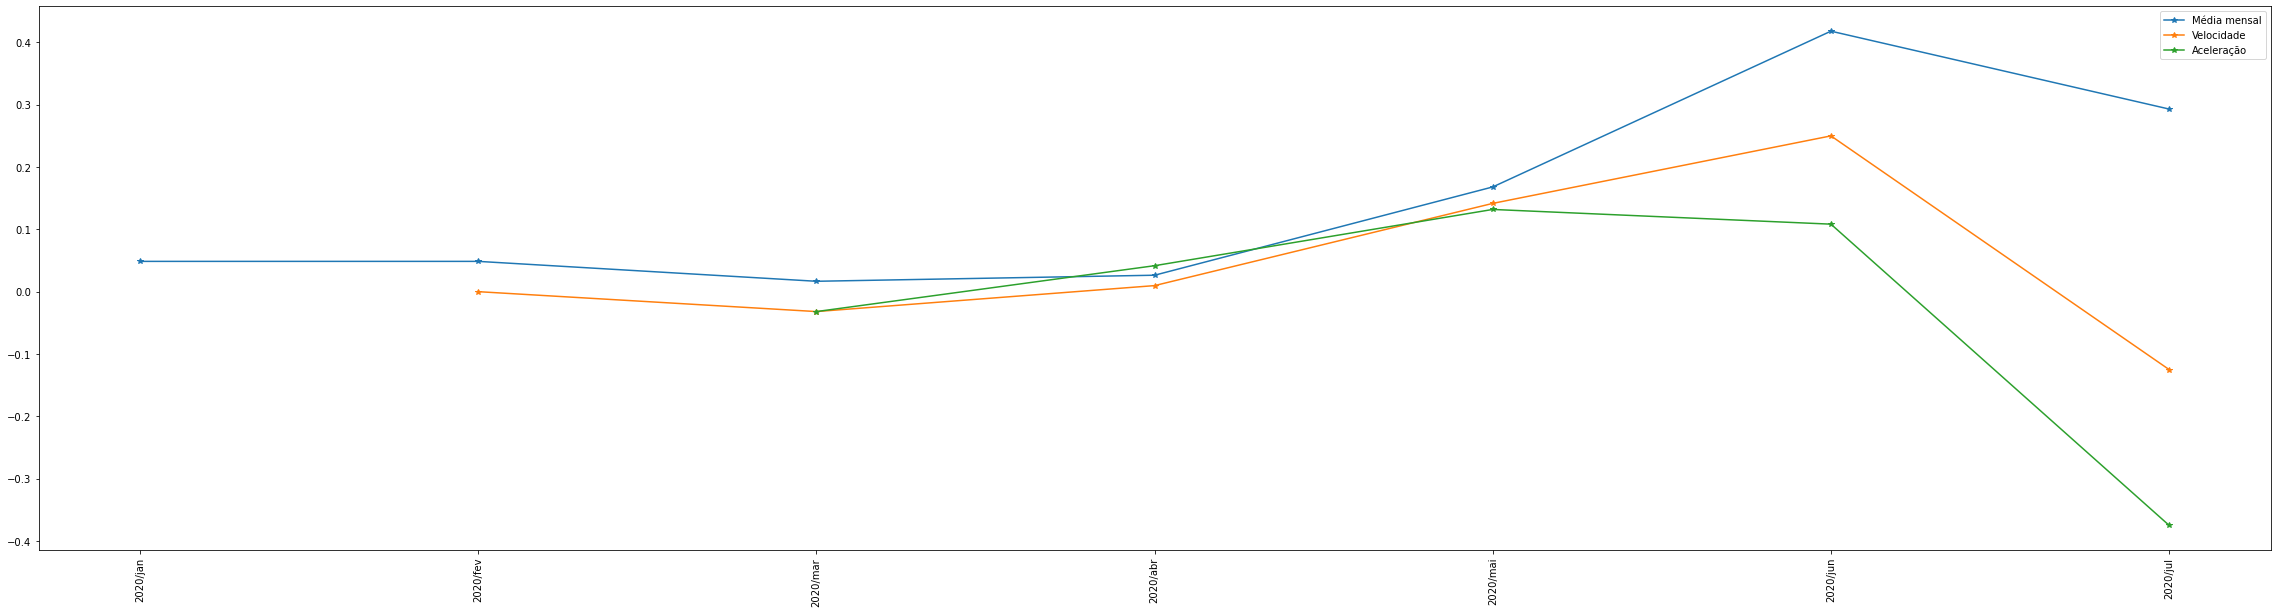

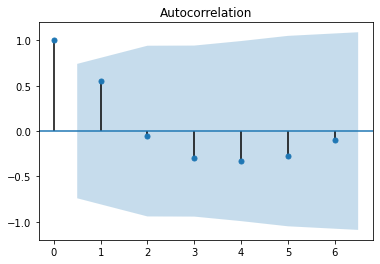

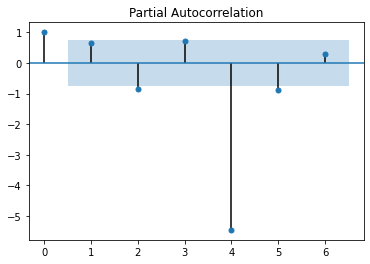

In [218]:
plt.figure(figsize=(40,10))
plt.plot(dados_mensais_medios_2020,'*-',label='Média mensal')
plt.plot(dados_mensais_medios_2020.diff(),'*-',label='Velocidade')
plt.plot(dados_mensais_medios_2020.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(dados_mensais_medios_2020.shape[0])],[i[0] for i in messes[21:28].values],rotation=90)
plt.legend(loc='best')
plot_acf(dados_mensais_medios_2020);
plot_pacf(dados_mensais_medios_2020);
plt.show()

# Juntando a série

In [219]:
serie_completa_2016 = pd.concat([dados_mensais_medios_2016,dados_mensais_medios_2017,dados_mensais_medios_2018,dados_mensais_medios_2019])
serie_completa_2016.reset_index(drop=True,inplace=True)

In [220]:
messes = pd.DataFrame({'Mes/ano':[]})
for j in ['2016','2017','2018','2019']:
    for i in ['jan','fev','mar','abr','mai','jun','jul']:
        messes = messes.append({"Mes/ano":j+'/'+i},ignore_index=True)

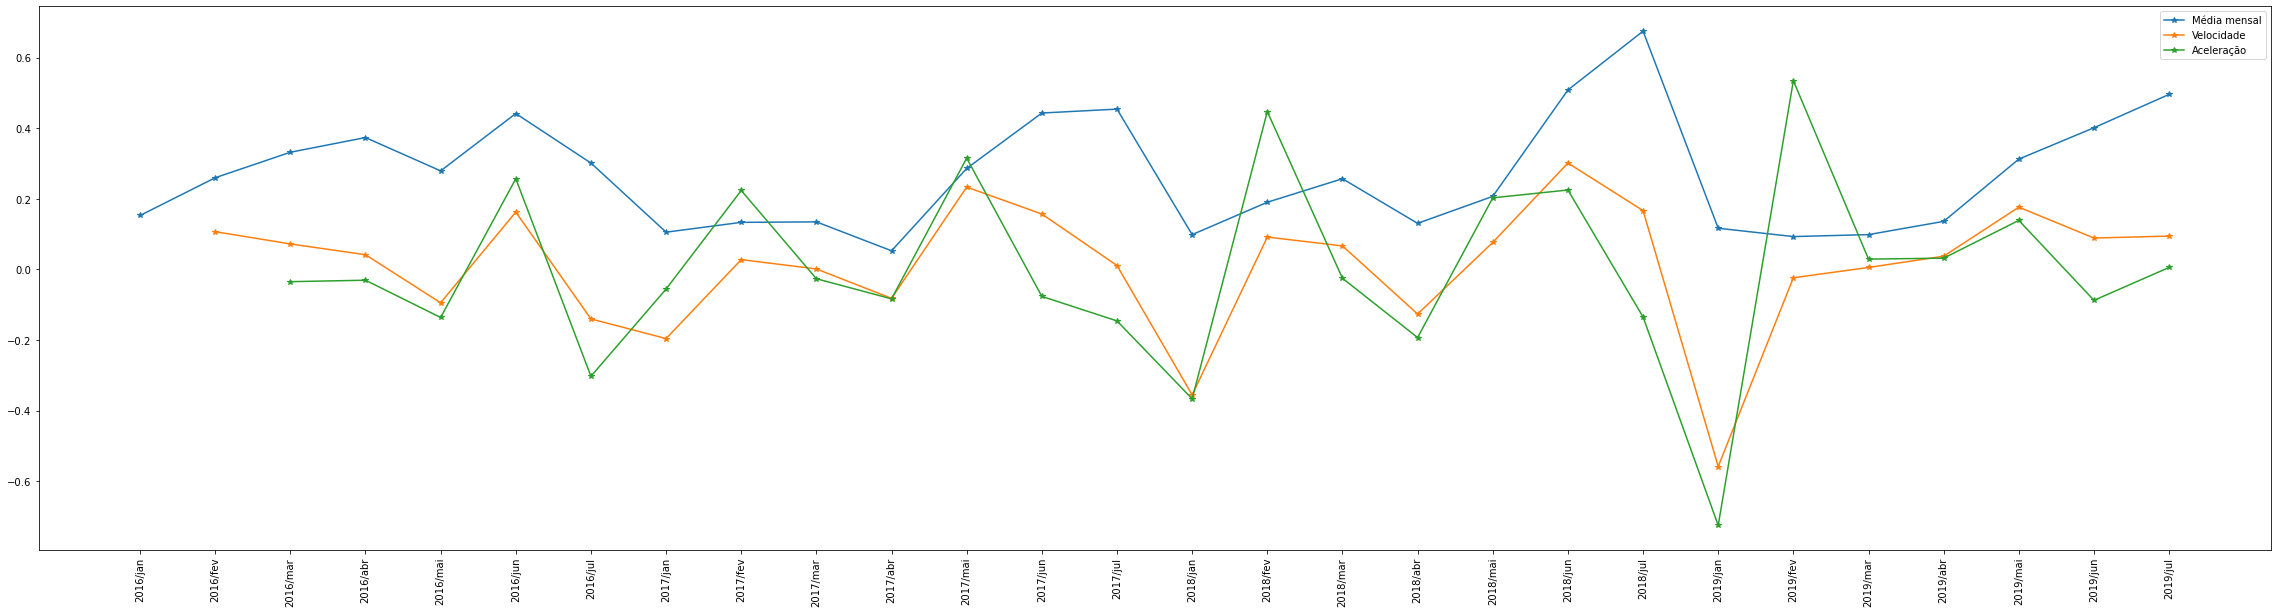

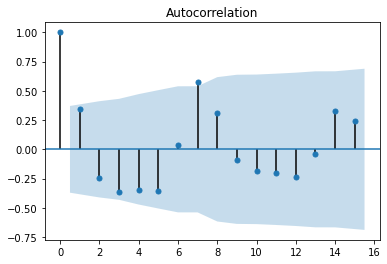

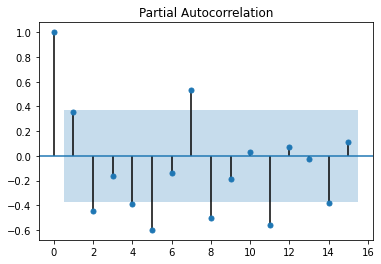

In [221]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_2016,'*-',label='Média mensal')
plt.plot(serie_completa_2016.diff(),'*-',label='Velocidade')
plt.plot(serie_completa_2016.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(serie_completa_2016.shape[0])],[i[0] for i in messes.values],rotation=90)
plt.legend(loc='best')
plot_acf(serie_completa_2016);
plot_pacf(serie_completa_2016);
plt.show()

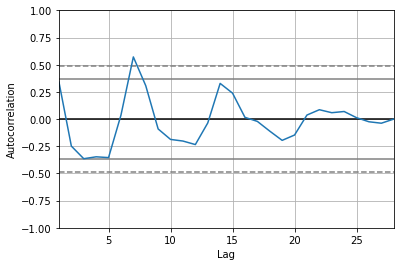

In [222]:
autocorrelation_plot(serie_completa_2016);

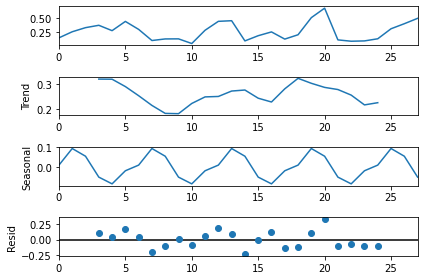

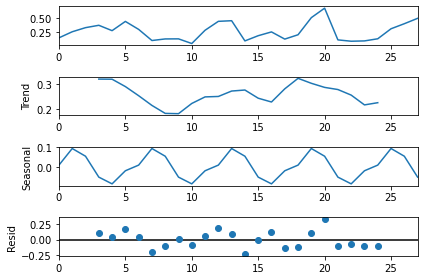

In [223]:
resultado_st = seasonal_decompose(serie_completa_2016,period=6)
resultado_st.plot()

# Juntando os dados a partir de 2017

In [224]:
serie_completa_2017 = pd.concat([dados_mensais_medios_2017,dados_mensais_medios_2018,dados_mensais_medios_2019,dados_mensais_medios_2020])
serie_completa_2017.reset_index(drop=True,inplace=True)

In [225]:
messes = pd.DataFrame({'Mes/ano':[]})
for j in ['2017','2018','2019','2020']:
    for i in ['jan','fev','mar','abr','mai','jun','jul']:
        messes = messes.append({"Mes/ano":j+'/'+i},ignore_index=True)

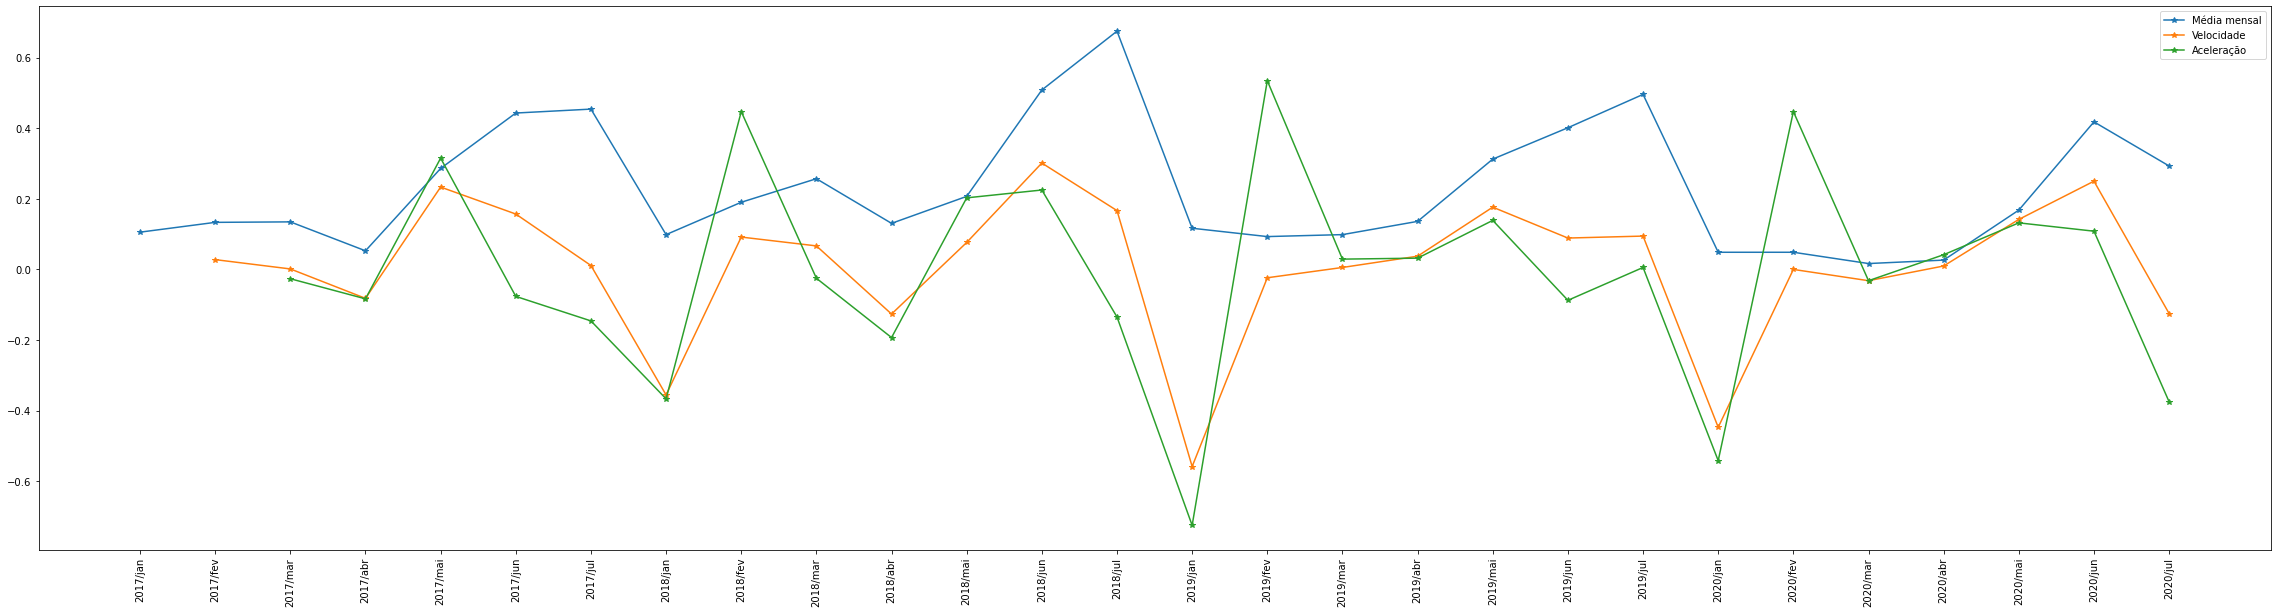

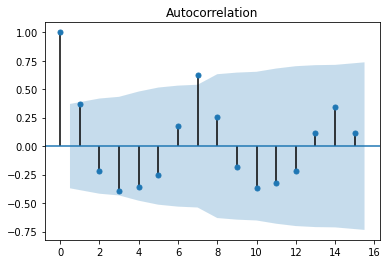

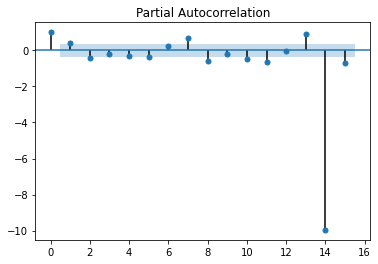

In [226]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_2017,'*-',label='Média mensal')
plt.plot(serie_completa_2017.diff(),'*-',label='Velocidade')
plt.plot(serie_completa_2017.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(serie_completa_2017.shape[0])],[i[0] for i in messes.values],rotation=90)
plt.legend(loc='best')
plot_acf(serie_completa_2017);
plot_pacf(serie_completa_2017);
plt.show()

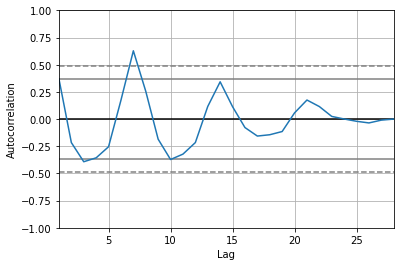

In [227]:
autocorrelation_plot(serie_completa_2017)

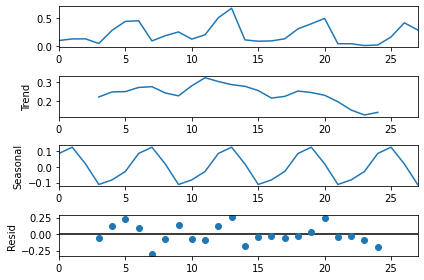

In [228]:
resultado_st = seasonal_decompose(serie_completa_2017,period=6)
resultado_st.plot();

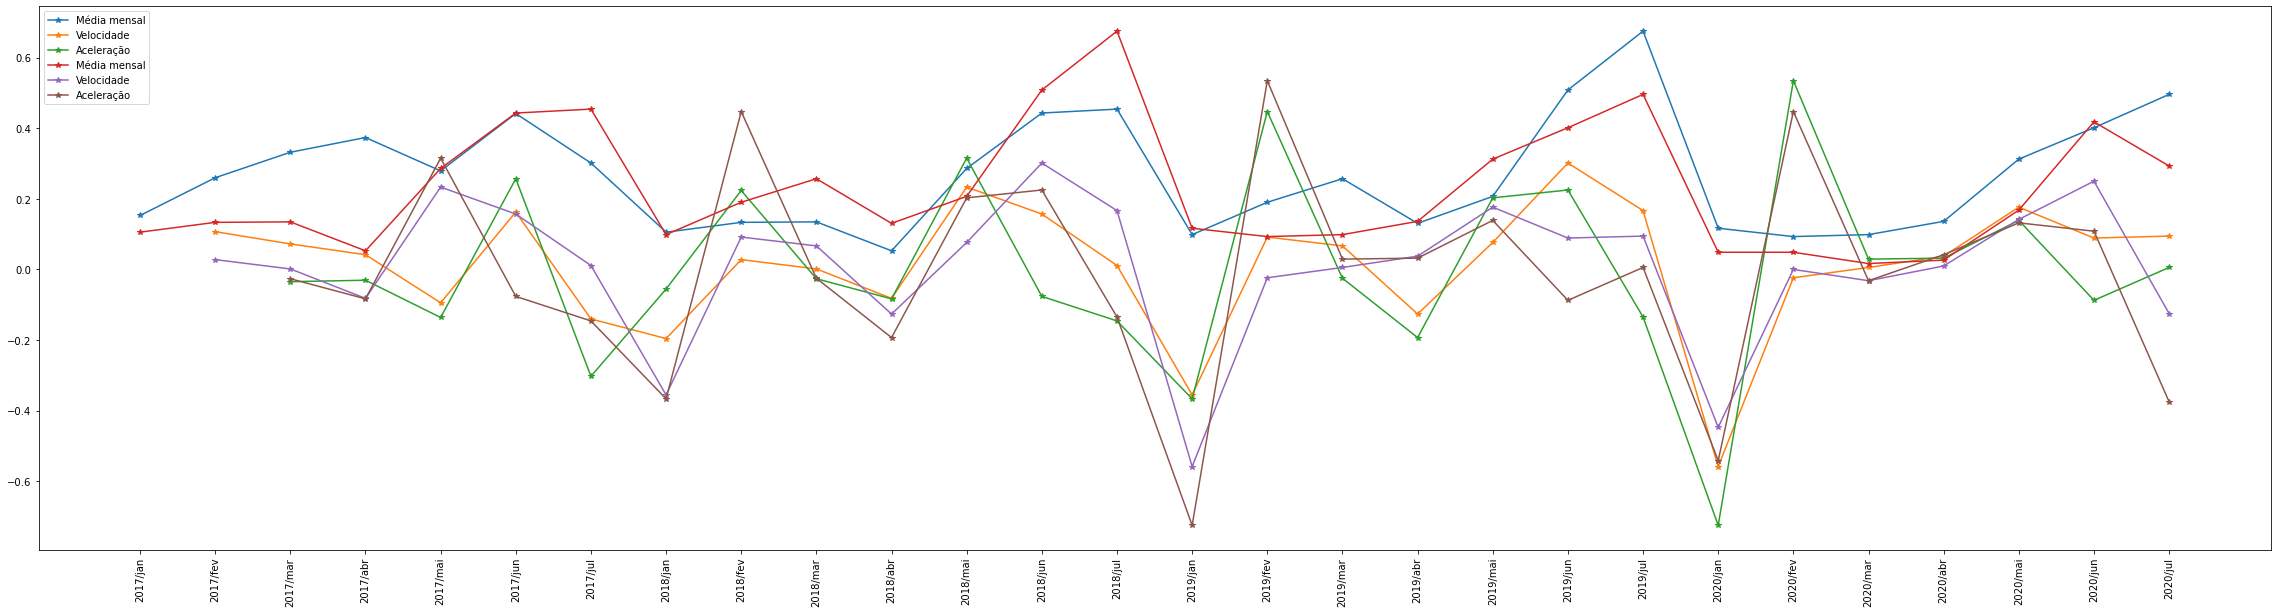

In [229]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_2016,'*-',label='Média mensal')
plt.plot(serie_completa_2016.diff(),'*-',label='Velocidade')
plt.plot(serie_completa_2016.diff().diff(),'*-',label='Aceleração')
plt.plot(serie_completa_2017,'*-',label='Média mensal')
plt.plot(serie_completa_2017.diff(),'*-',label='Velocidade')
plt.plot(serie_completa_2017.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(serie_completa_2017.shape[0])],[i[0] for i in messes.values],rotation=90)
plt.legend(loc='best')
plt.show()

# Focando apenas no ano de 2020

In [230]:
serie_5_anos= pd.concat([dados_medios_completados_2016,dados_medios_completados_2017,dados_medios_completados_2018,
                        dados_medios_completados_2019,dados_medios_completados_2020])
serie_5_anos.reset_index(drop=True,inplace=True)
serie_5_anos.mean()

0.2422708725674827

In [231]:
serie_5_anos_suavizado = pd.concat([st_2016_suavizado,st_2017_suavizado,st_2018_suavizado,st_2019_suavizado,st_2020_suavizado])
serie_5_anos_suavizado.reset_index(drop=True,inplace=True)
serie_5_anos_suavizado.mean()

0    0.255043
dtype: float64

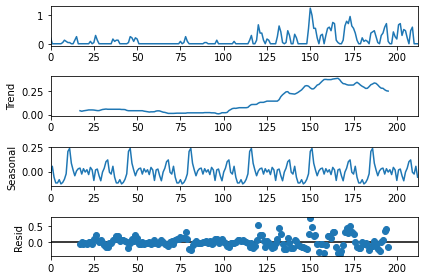

In [232]:
resultado_2020 = seasonal_decompose(dados_medios_completados_2020,period=35)
resultado_2020.plot();

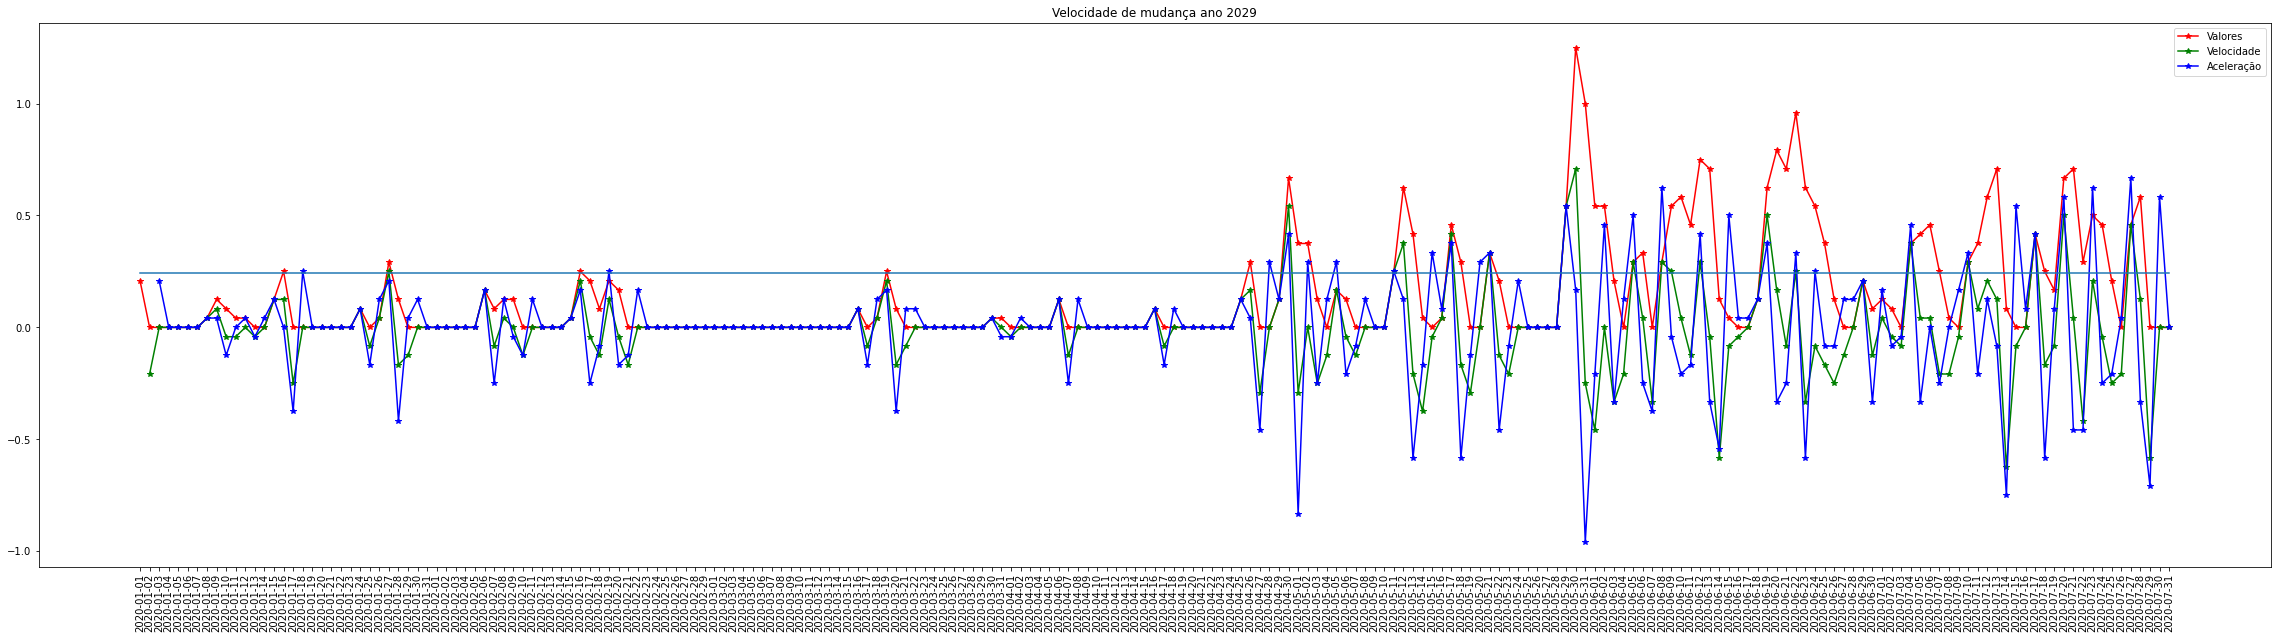

In [233]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2029')
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2020.values],rotation=90)
plt.plot(dados_medios_completados_2020,'r*-',label='Valores')
plt.plot(dados_medios_completados_2020.diff(),'g*-',label='Velocidade')
velocidade = dados_medios_completados_2020.diff()
plt.plot(velocidade.diff(),'b*-',label='Aceleração')
plt.plot([i for i in range(st_2020_suavizado.shape[0])],[serie_5_anos.mean() for i in range(st_2020_suavizado.shape[0])])
plt.legend(loc='best')
plt.show()

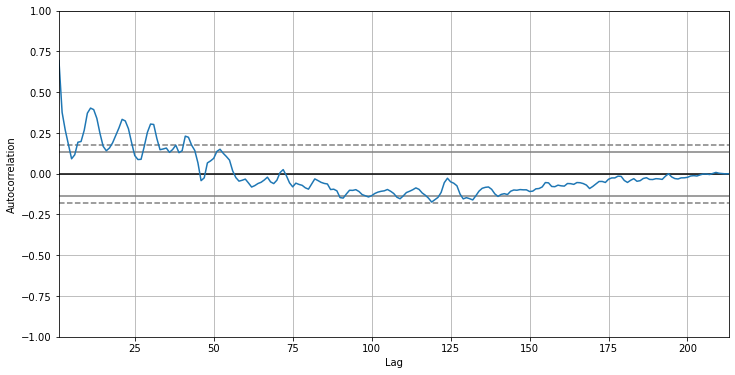

In [234]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2020)

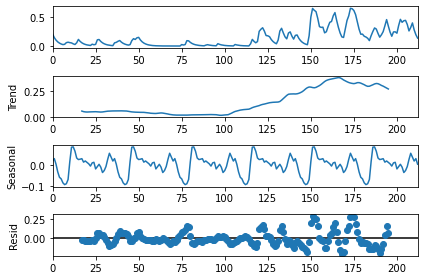

In [235]:
resultado_2020 = seasonal_decompose(st_2020_suavizado,period=35)
resultado_2020.plot();

MAPE:106.0
MAE:106.0
MQE:106.0


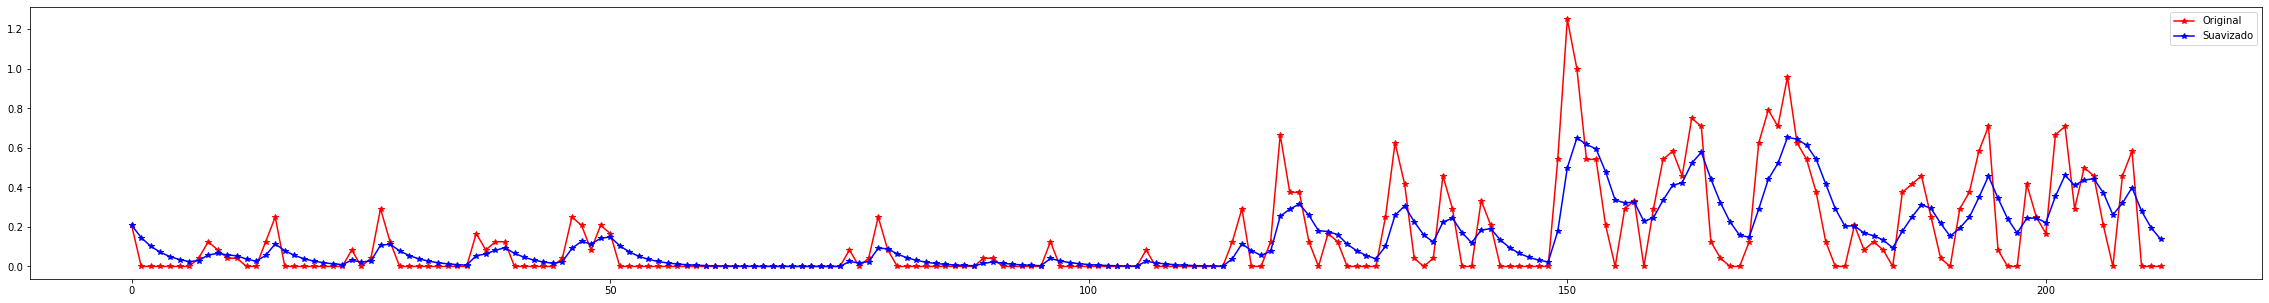

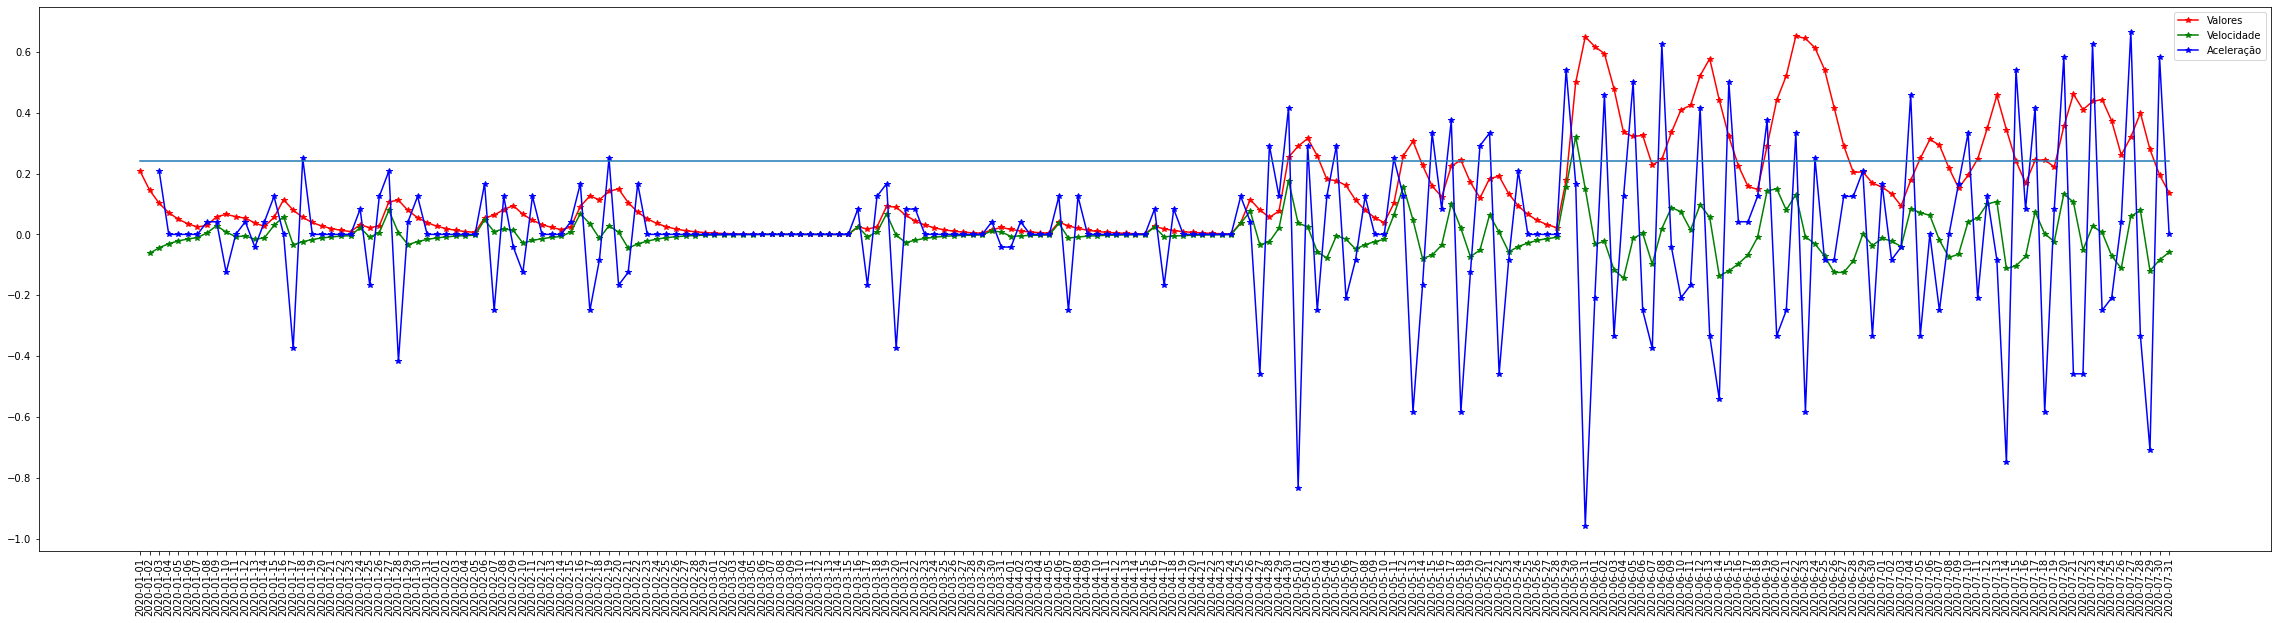

In [236]:
st_2020_suavizado = alisar_serie(dados_medios_completados_2020,p_v_2020);
plt.figure(figsize=(40,10))
plt.plot(st_2020_suavizado,'r*-',label='Valores')
plt.plot(st_2020_suavizado.diff(),'g*-',label='Velocidade')
vellocidade = st_2020_suavizado.diff()
plt.plot(velocidade.diff(),'b*-',label='Aceleração')
plt.plot([i for i in range(st_2020_suavizado.shape[0])],[serie_5_anos.mean() for i in range(st_2020_suavizado.shape[0])])
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2020.values],rotation=90)
plt.legend(loc='best')
plt.show()

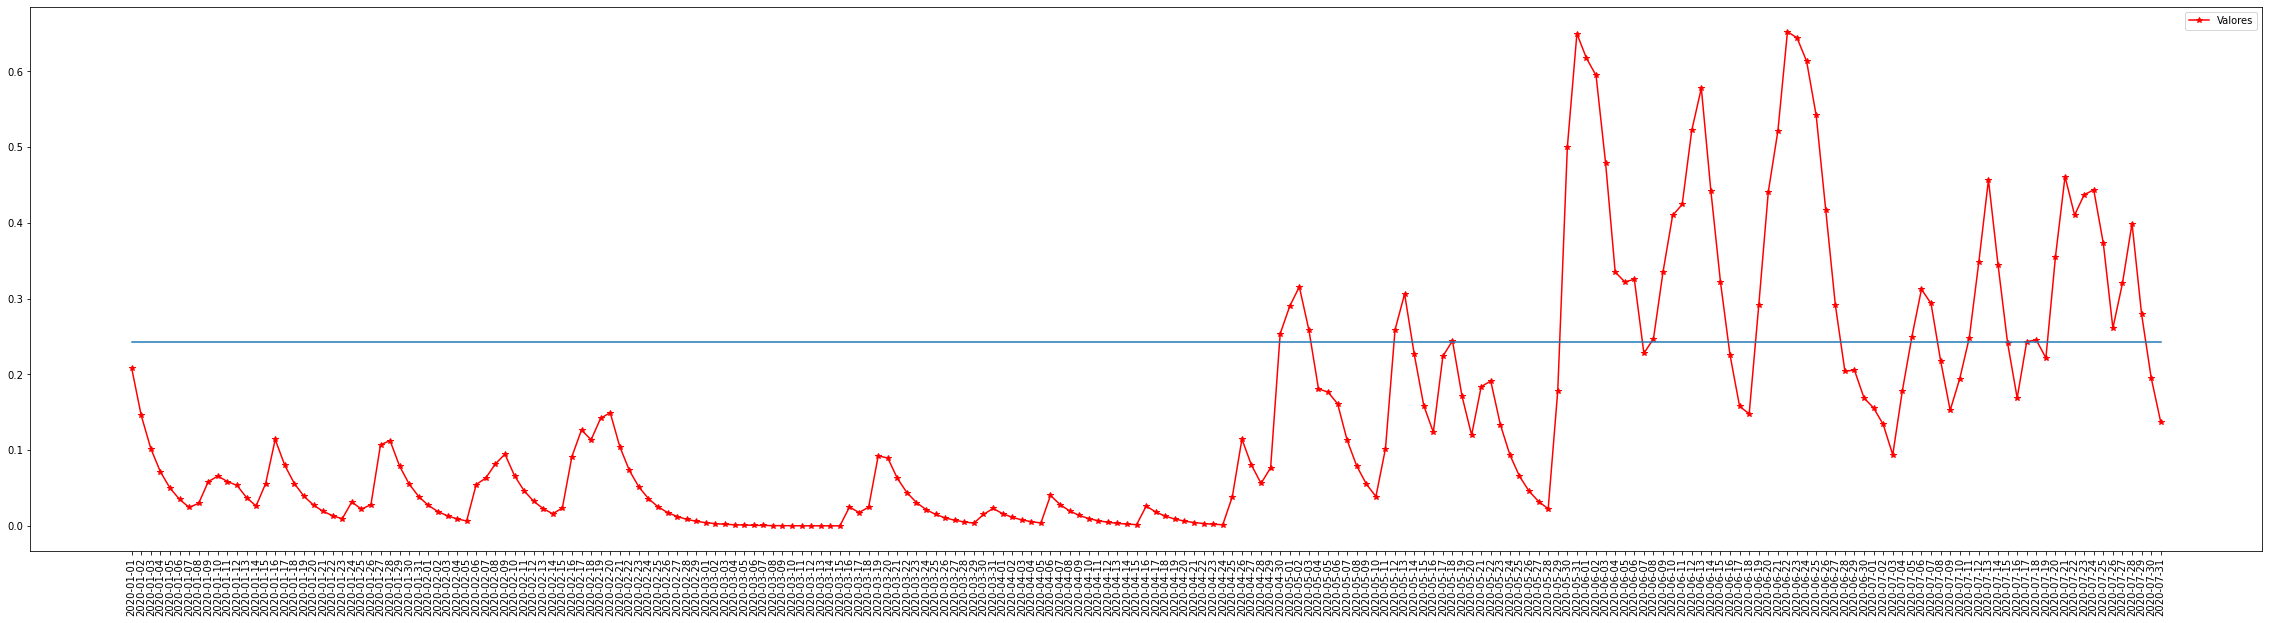

In [237]:
plt.figure(figsize=(40,10))
plt.plot(st_2020_suavizado,'r*-',label='Valores')
plt.plot([i for i in range(st_2020_suavizado.shape[0])],[serie_5_anos.mean() for i in range(st_2020_suavizado.shape[0])])
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2020.values],rotation=90)
plt.legend(loc='best')
plt.show()

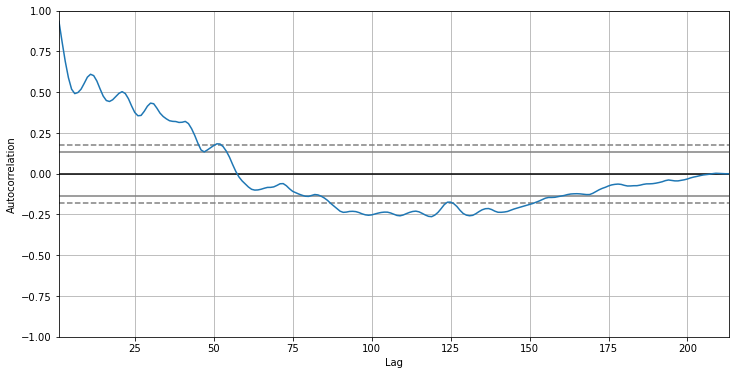

In [238]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2020_suavizado)

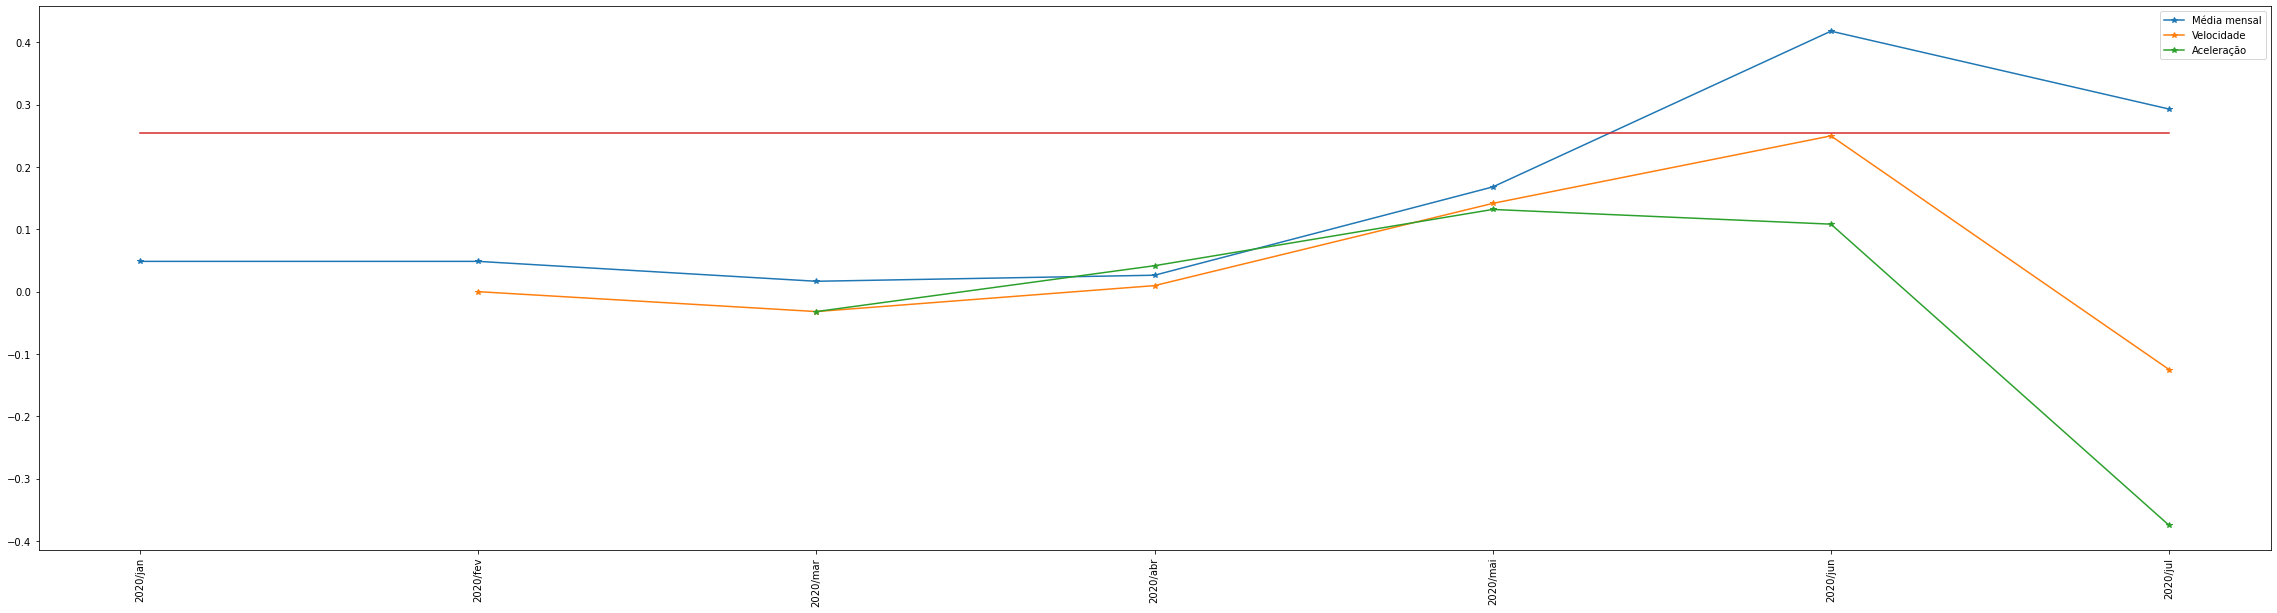

In [239]:
plt.figure(figsize=(40,10))
plt.plot(dados_mensais_medios_2020,'*-',label='Média mensal')
plt.plot(dados_mensais_medios_2020.diff(),'*-',label='Velocidade')
plt.plot(dados_mensais_medios_2020.diff().diff(),'*-',label='Aceleração')
plt.plot([i for i in range(dados_mensais_medios_2020.shape[0])],[serie_5_anos_suavizado.mean() for i in range(dados_mensais_medios_2020.shape[0])])
plt.xticks([i for i in range(dados_mensais_medios_2020.shape[0])],[i[0] for i in messes[21:28].values],rotation=90)
plt.legend(loc='best')
plt.show()

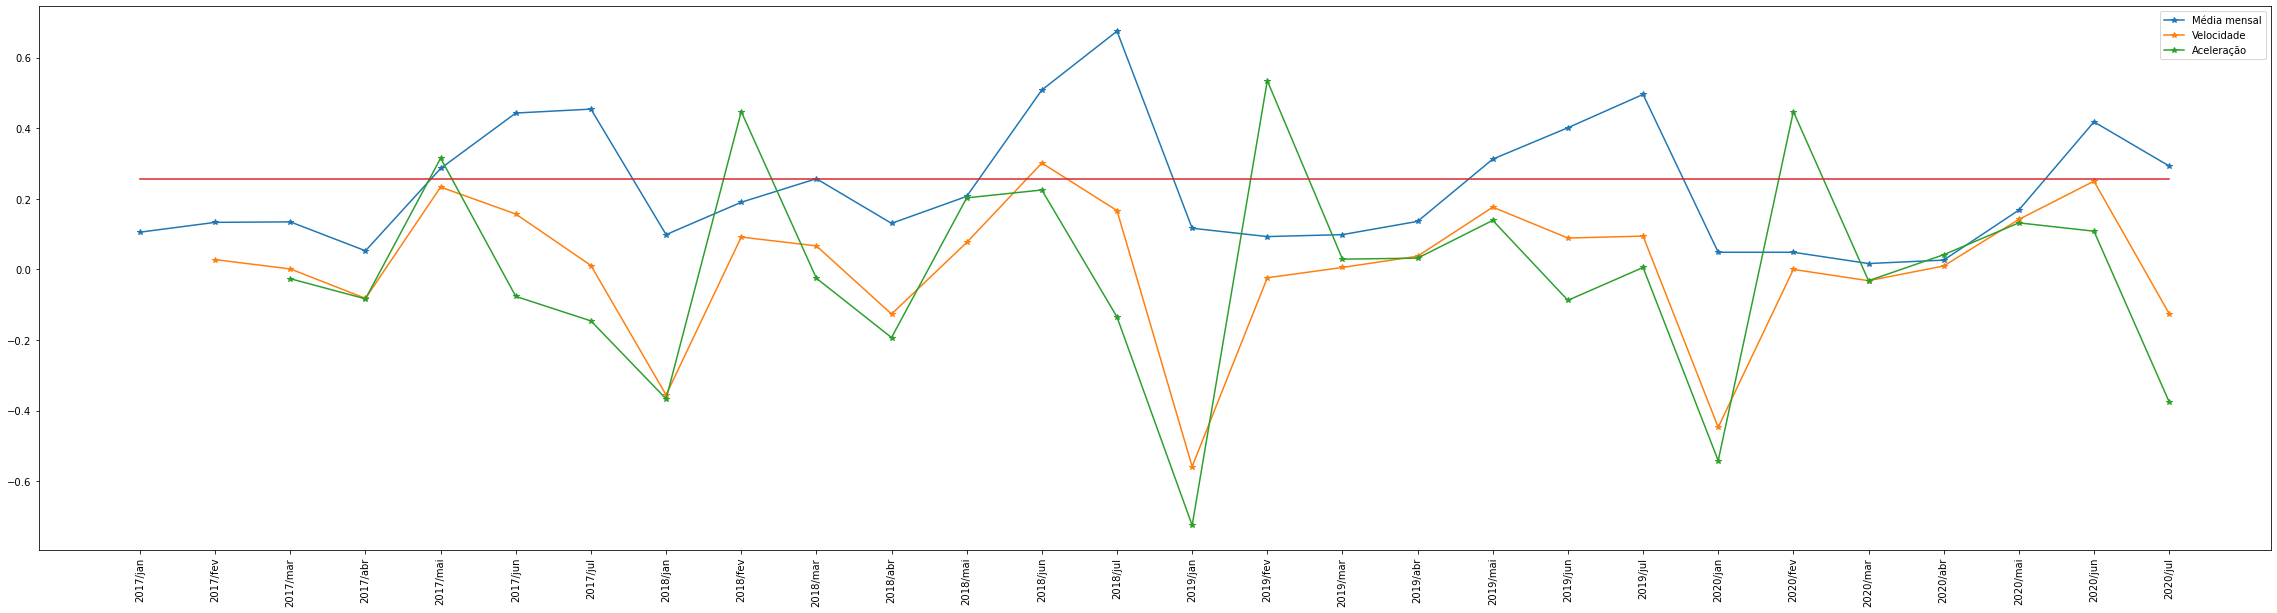

In [240]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_2017,'*-',label='Média mensal')
plt.plot(serie_completa_2017.diff(),'*-',label='Velocidade')
plt.plot(serie_completa_2017.diff().diff(),'*-',label='Aceleração')
plt.plot([i for i in range(serie_completa_2017.shape[0])],[serie_5_anos_suavizado.mean() for i in range(serie_completa_2017.shape[0])])
plt.xticks([i for i in range(serie_completa_2017.shape[0])],[i[0] for i in messes.values],rotation=90)
plt.legend(loc='best')
plt.show()